# Notebook for Jacobsville sandstone Pmag analyses

SC1: Snake Creek pmag site. Fine to medium sandstone. Coherent and strong material but have relatively low magnetization. Commonly have NRMs of E-5 emu. The high temperature (>660 degree C components are not very well resolved in demagnetization). 

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import norm
import scipy.stats as st
import matplotlib.pyplot as plt
import pmagpy.pmag as pmag
import pmagpy.ipmag as ipmag
from pmagpy import pmagplotlib

import matplotlib
import matplotlib.colors as colors
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
from cartopy import config
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
Laurentia_outline = ShapelyFeature(Reader('../Data/Laurentia_shape/Laurentia.shp').geometries(),
                                ccrs.PlateCarree(), facecolor = 'none', edgecolor='black')

In [3]:
def angle_to_distance(angle):
    return angle/180*np.pi*6371

In [4]:
def bin_trace(lon_samples, lat_samples, resolution):
    """
    Given a trace of samples in longitude and latitude, bin them
    in latitude and longitude, and normalize the bins so that
    the integral of probability density over the sphere is one.

    The resolution keyword gives the number of divisions in latitude.
    The divisions in longitude is twice that.
    """
    lats = np.linspace(-90., 90., resolution, endpoint=True)
    lons = np.linspace(-180., 180., 2 * resolution, endpoint=True)
    lon_grid, lat_grid = np.meshgrid(lons, lats)
    hist = np.zeros_like(lon_grid)

    dlon = 360. / (2. * resolution)
    dlat = 180. / resolution

    for lon, lat in zip(lon_samples, lat_samples):

        lon = np.mod(lon, 360.)
        if lon > 180.:
            lon = lon - 360.
        if lat < -90. or lat > 90.:
            # Just skip invalid latitudes if they happen to arise
            continue

        lon_index = int(np.floor((lon + 180.) / dlon))
        lat_index = int(np.floor((lat + 90.) / dlat))
        hist[lat_index, lon_index] += 1

    lat_grid += dlat / 2.
    lon_grid += dlon / 2.
    return lon_grid, lat_grid, hist


def density_distribution(lon_samples, lat_samples, resolution=30):
    count = len(lon_samples)
    lon_grid, lat_grid, hist = bin_trace(lon_samples, lat_samples, resolution)
    return lon_grid, lat_grid, hist / count


def cumulative_density_distribution(lon_samples, lat_samples, resolution=30):

    lon_grid, lat_grid, hist = bin_trace(lon_samples, lat_samples, resolution)

    # Compute the cumulative density
    hist = hist.ravel()
    i_sort = np.argsort(hist)[::-1]
    i_unsort = np.argsort(i_sort)
    hist_cumsum = hist[i_sort].cumsum()
    hist_cumsum /= hist_cumsum[-1]

    return lon_grid, lat_grid, hist_cumsum[i_unsort].reshape(lat_grid.shape)


def plot_distributions(ax, lon_samples, lat_samples, to_plot='d', resolution=100, **kwargs):

    cmap=kwargs.get('cmap', 'viridis')

    artists = []

    if 'd' in to_plot:
        lon_grid, lat_grid, density = density_distribution(
            lon_samples, lat_samples, resolution)
        density = ma.masked_where(density <= 0.05*density.max(), density)
        a = ax.pcolormesh(lon_grid, lat_grid, density, cmap=cmap,
                          transform=ccrs.PlateCarree())
        artists.append(a)

    if 'e' in to_plot:
        lon_grid, lat_grid, cumulative_density = cumulative_density_distribution(
            lon_samples, lat_samples, resolution)
        a = ax.contour(lon_grid, lat_grid, cumulative_density, levels=[
                       0.95], colors=kwargs.get('colors', 'k'), transform=ccrs.PlateCarree(), 
                       linewidths=kwargs.get('lw', 1), zorder = kwargs.get('zorder', 100))
        artists.append(a)

    if 's' in to_plot:
        a = ax.scatter(lon_samples, lat_samples, color=kwargs.get('color', 'C0'), alpha=0.1, transform=ccrs.PlateCarree(), edgecolors=None, **kwargs)
        artists.append(a)

    return artists

In [5]:
def plot_vgp(map_axis, vgp_lon=None, vgp_lat=None, di_block=None, label='', color='k', marker='o',
             edge='black', markersize=20, alpha=1, legend=False):
    """
    This function plots a paleomagnetic pole position on a cartopy map axis.


    Before this function is called, a plot needs to be initialized with code
    such as that in the make_orthographic_map function.

    Example
    -------
    >>> vgps = ipmag.fishrot(dec=200,inc=30)
    >>> vgp_lon_list,vgp_lat_list,intensities= ipmag.unpack_di_block(vgps)
    >>> map_axis = ipmag.make_orthographic_map(central_longitude=200,central_latitude=30)
    >>> ipmag.plot_vgp(map_axis,vgp_lon=vgp_lon_list,vgp_lat=vgp_lat_list,color='red',markersize=40)

    Required Parameters
    -----------
    map_axis : the name of the current map axis that has been developed using cartopy
    plon : the longitude of the paleomagnetic pole being plotted (in degrees E)
    plat : the latitude of the paleomagnetic pole being plotted (in degrees)

    Optional Parameters (defaults are used if not specified)
    -----------
    color : the color desired for the symbol (default is 'k' aka black)
    marker : the marker shape desired for the pole mean symbol (default is 'o' aka a circle)
    edge : the color of the edge of the marker (default is black)
    markersize : size of the marker in pt (default is 20)
    alpha : the transparency of the points (defaul is 1 which is opaque, 0 is fully transparent)
    label : the default is no label. Labels can be assigned.
    legend : the default is no legend (False). Putting True will plot a legend.
    """
#     if not has_cartopy:
#         print('-W- cartopy must be installed to run ipmag.plot_vgp')
#         return
    if di_block != None:
        di_lists = unpack_di_block(di_block)
        if len(di_lists) == 3:
            vgp_lon, vgp_lat, intensity = di_lists
        if len(di_lists) == 2:
            vgp_lon, vgp_lat = di_lists
    map_axis.scatter(vgp_lon, vgp_lat, marker=marker, edgecolors=edge,
                     s=markersize, color=color, label=label, zorder=1, transform=ccrs.PlateCarree(), alpha=alpha)
    map_axis.set_global()
    if legend == True:
        plt.legend(loc=2)

In [6]:
def plot_pole_dp_dm(map_axis, plon, plat, slon, slat, dp, dm, pole_label='pole', 
                    pole_color='k', pole_edgecolor='k', pole_marker='o',
                    markersize=20, legend=True):

    dp_km = dp*111.32
    dm_km = dm*111.32
    map_axis.scatter(plon, plat, marker=pole_marker,
                     color=pole_color, edgecolors=pole_edgecolor, s=markersize,
                     label=pole_label, zorder=101, transform=ccrs.PlateCarree())

    # the orientation of the ellipse needs to be determined using the
    # two laws of cosines for spherical triangles where the triangle is
    # A: site, B: north pole, C: paleomagnetic pole (see Fig. A.2 of Butler)

    site_lon_rad = np.deg2rad(slon)
    site_lat_rad = np.deg2rad(slat)
    c_rad = np.deg2rad(90-slat)

    pole_lon_rad = np.deg2rad(plon)
    pole_lat_rad = np.deg2rad(plat)
    a_rad = np.deg2rad(90-plat)

    B_rad = np.abs(pole_lon_rad-site_lon_rad)

    cos_b = np.cos(c_rad)*np.cos(a_rad) + np.sin(c_rad) * \
        np.sin(a_rad)*np.cos(B_rad)
    b_rad = np.arccos(cos_b)

    sin_C = (np.sin(B_rad)/np.sin(b_rad))*np.sin(c_rad)
    C_rad = np.arcsin(sin_C)

    # need to make the rotation of the ellipse go the right way
    if slon-plon > 180:
        if plon >= slon and plat >= slat:
            C_deg = -np.abs(np.rad2deg(C_rad))
        elif plon <= slon and plat >= slat:
            C_deg = np.abs(np.rad2deg(C_rad))
        elif plon >= slon and plat <= slat:
            C_deg = np.abs(np.rad2deg(C_rad))
        elif plon <= slon and plat <= slat:
            C_deg = -np.abs(np.rad2deg(C_rad))
    elif slon-plon <= 180:
        if plon >= slon and plat >= slat:
            C_deg = np.abs(np.rad2deg(C_rad))
        elif plon <= slon and plat >= slat:
            C_deg = -np.abs(np.rad2deg(C_rad))
        elif plon >= slon and plat <= slat:
            C_deg = -np.abs(np.rad2deg(C_rad))
        elif plon <= slon and plat <= slat:
            C_deg = np.abs(np.rad2deg(C_rad))

#     print(C_deg)
    ipmag.ellipse(map_axis, plon, plat, dp_km, dm_km, C_deg, color=pole_color)

    if legend == True:
        plt.legend(loc=2)

In [7]:
def plot_pole_ellipse(map_axis, dictionary, 
                      color='k', edgecolor='k', marker='s', 
                      markersize=20, label='', alpha=1.0, lw=1, lower=True):
    """
    Plot a mean pole confidence ellipse associated with a Kent distribution

    Parameters
    -----------
    map_axis : the name of the current map axis that has been developed using cartopy
    dictionary : a dictionary generated by the pmag.dobingham or pmag.dokent functions
    
    Optional Parameters (defaults are used if not specified)
    -----------
    color : symbol color; the default color is black. Other colors can be chosen (e.g. 'r')
    marker : the default marker is a circle. Other symbols can be chosen (e.g. 's')
    markersize : the default is 20. Other size can be chosen
    label : the default is no label. Labels can be assigned.
    legend : the default is no legend ('no'). Putting 'yes' will plot a legend.
    filled_pole : if True, the A95 ellipse will be filled with color
    fill_color : color of fill; the default is black.
    fill_alpha : transparency of filled ellipse (the default is 1.0; no transparency).
    lower: hemisphere projection of the ellipse, default is lower hemisphere projection
    """
    pars = []
    pars.append(dictionary['dec'])
    pars.append(dictionary['inc'])
    pars.append(dictionary['Zeta'])
    pars.append(dictionary['Zdec'])
    pars.append(dictionary['Zinc'])
    pars.append(dictionary['Eta'])
    pars.append(dictionary['Edec'])
    pars.append(dictionary['Einc'])

    map_axis.scatter(dictionary['dec'], dictionary['inc'], marker=marker,
                     color=color, edgecolors=edgecolor, s=markersize,
                     label=label, zorder=101, transform=ccrs.PlateCarree())

    fignum=1
    ellipse_points = np.array(pmagplotlib.plot_ell(fignum, pars, lower=lower, plot=False)).T
    map_axis.plot(ellipse_points[0], ellipse_points[1], color=color,
                 transform=ccrs.Geodetic(), alpha=alpha, lw=lw)
    
    return map_axis

## Compile previous data from the Jacobsville Sandstone

## Dubois (1962) 

- Du Bois, P. M. (1962). Palaeomagnetism and Correlation Fo Keweenawan Rocks. La Commission, Energie, mines et ressources Canada.
- there are data from both the Keweenaw Peninsula and from Sault Ste Marie
- the interpretation that the sedimentary formation from Sault Ste Marie are Jacobsville equivalent is interesting but we don't have detrital zircon support
- and given that SSM pmag remanence are more northerly than the Jacobsville direction, it could be that SSM sediments are slightly of different age than Keweenaw Jacobsville, could be time equivalent with Freda. In any case we choose to not include SSM specimens/sites in the comparison analyses with our data. 


In [8]:
Dubois1962a_samples = pd.read_csv('../Data/Pmag_compiled/Dubois1962a_samples.txt', sep='\t', header = 1)
Dubois1962a_samples = ipmag.vgp_calc(Dubois1962a_samples,   tilt_correction='no',
    site_lon='lon',
    site_lat='lat',
    dec_is='dir_dec',
    inc_is='dir_inc',)
Dubois1962a_samples['Plon'] = Dubois1962a_samples['vgp_lon']
Dubois1962a_samples['Plat'] = Dubois1962a_samples['vgp_lat']
Dubois1962a_samples.head()

site            location  dir_dec  dir_inc  lat   lon  geologic_classes  \
0  CA1  Keweenaw Peninsula    260.5    -22.0   47 -88.5               NaN   
1   J1  Keweenaw Peninsula    219.5    -15.5   47 -88.5               NaN   
2   J4  Keweenaw Peninsula    239.5    -27.5   47 -88.5               NaN   
3   J5  Keweenaw Peninsula    219.5     43.0   47 -88.5               NaN   
4   J6  Keweenaw Peninsula    245.5    -32.0   47 -88.5               NaN   

   geologic_types  lithologies  method_codes  ...  result_type  dip_trend  \
0             NaN          NaN           NaN  ...          NaN        NaN   
1             NaN          NaN           NaN  ...          NaN        NaN   
2             NaN          NaN           NaN  ...          NaN        NaN   
3             NaN          NaN           NaN  ...          NaN        NaN   
4             NaN          NaN           NaN  ...          NaN        NaN   

   dip  paleolatitude    vgp_lat     vgp_lon  vgp_lat_rev  vgp_lon_rev  \
0  NaN     -11.420796 -14.782534  180.508784    14.782534     0.508784   
1  NaN      -7.894424 -38.441075  217.946992    38.441075    37.946992   
2  NaN     -14.589431 -31.278642  194.168393    31.278642    14.168393   
3  NaN      24.997641  -9.665423  235.711499     9.665423    55.711499   
4  NaN     -17.350615 -29.212765  187.161425    29.212765     7.161425   

         Plon       Plat  
0  180.508784 -14.782534  
1  217.946992 -38.441075  
2  194.168393 -31.278642  
3  235.711499  -9.665423  
4  187.161425 -29.212765  

[5 rows x 21 columns]

In [9]:
Dubois1962a_samples_kewee = Dubois1962a_samples[Dubois1962a_samples['location'] == 'Keweenaw Peninsula']
Dubois1962a_samples_Marie = Dubois1962a_samples[Dubois1962a_samples['location'] == 'Sault Ste. Marie']

Dubois1962a_samples_kewee_mean = ipmag.fisher_mean(Dubois1962a_samples_kewee['dir_dec'].tolist(),
                                                   Dubois1962a_samples_kewee['dir_inc'].tolist())
Dubois1962a_samples_Marie_mean = ipmag.fisher_mean(Dubois1962a_samples_Marie['dir_dec'].tolist(),
                                                   Dubois1962a_samples_Marie['dir_inc'].tolist())

Dubois1962a_samples_kewee_mean_pole = ipmag.fisher_mean(Dubois1962a_samples_kewee['vgp_lon'].tolist(),
                                                        Dubois1962a_samples_kewee['vgp_lat'].tolist())
Dubois1962a_samples_Marie_mean_pole = ipmag.fisher_mean(Dubois1962a_samples_Marie['vgp_lon'].tolist(),
                                                        Dubois1962a_samples_Marie['vgp_lat'].tolist())

### Keweenaw directions

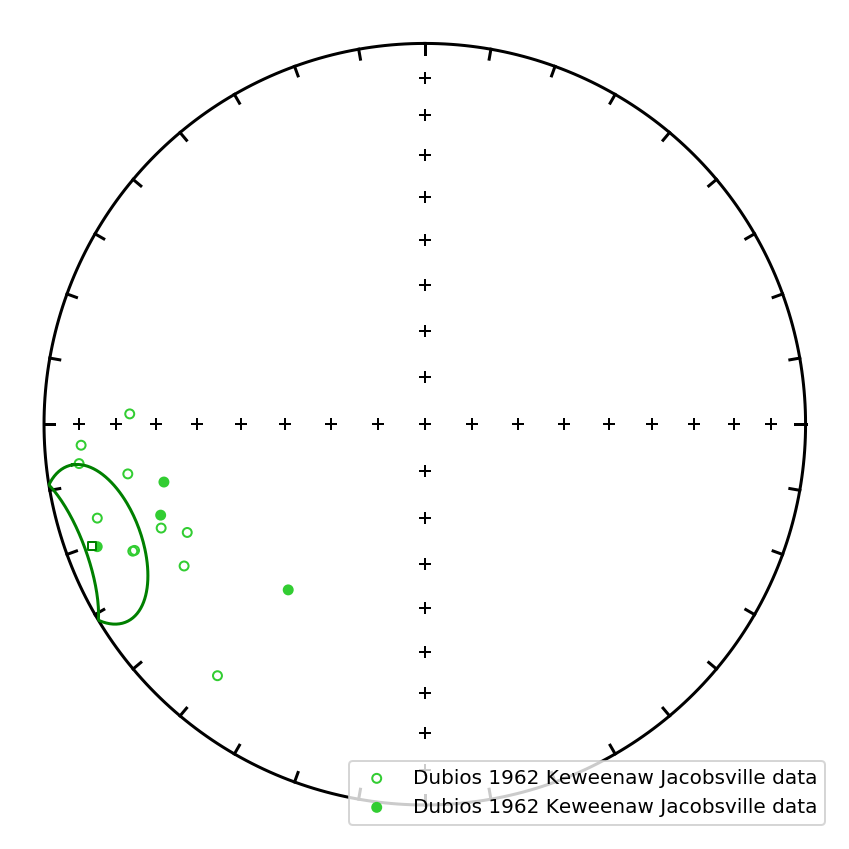

In [10]:
fignum = 1
plt.figure(num=fignum,figsize=(6,6))
ipmag.plot_net(fignum)

ipmag.plot_di(Dubois1962a_samples_kewee['dir_dec'].tolist(),Dubois1962a_samples_kewee['dir_inc'].tolist(),
              color='limegreen',label='Dubios 1962 Keweenaw Jacobsville data')
ipmag.plot_di_mean(Dubois1962a_samples_kewee_mean['dec'],Dubois1962a_samples_kewee_mean['inc'],Dubois1962a_samples_kewee_mean['alpha95'],
                   color='green', marker = 's')
plt.legend(loc=4)
# plt.savefig('../Figures/Pmag/Dubois1962_Keweenaw_directions.pdf')
plt.show()

<Figure size 360x360 with 0 Axes>

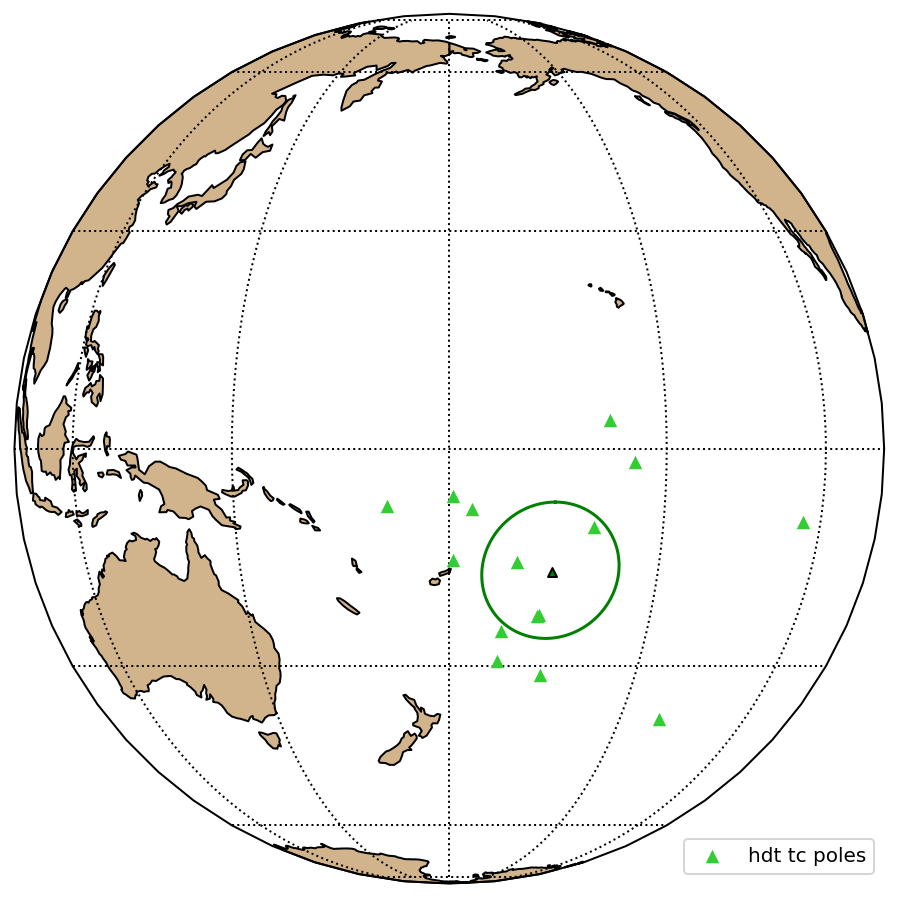

In [11]:
plt.figure(figsize=(5, 5))
map_axis=ipmag.make_orthographic_map(central_longitude=180,central_latitude=0)

ipmag.plot_vgp(map_axis, Dubois1962a_samples_kewee['vgp_lon'].tolist(), 
               Dubois1962a_samples_kewee['vgp_lat'].tolist(), markersize = 45, marker = '^', color = 'limegreen', edge='none', label = 'hdt tc poles')

ipmag.plot_pole(map_axis, Dubois1962a_samples_kewee_mean_pole['dec'], 
                Dubois1962a_samples_kewee_mean_pole['inc'], 
                Dubois1962a_samples_kewee_mean_pole['alpha95'], 
                color = 'green', marker = '^')

plt.legend(loc=4)
# plt.savefig('../Figures/Pmag/Dubois1962_Keweenaw_poles.pdf')
plt.show()

### SSM directions

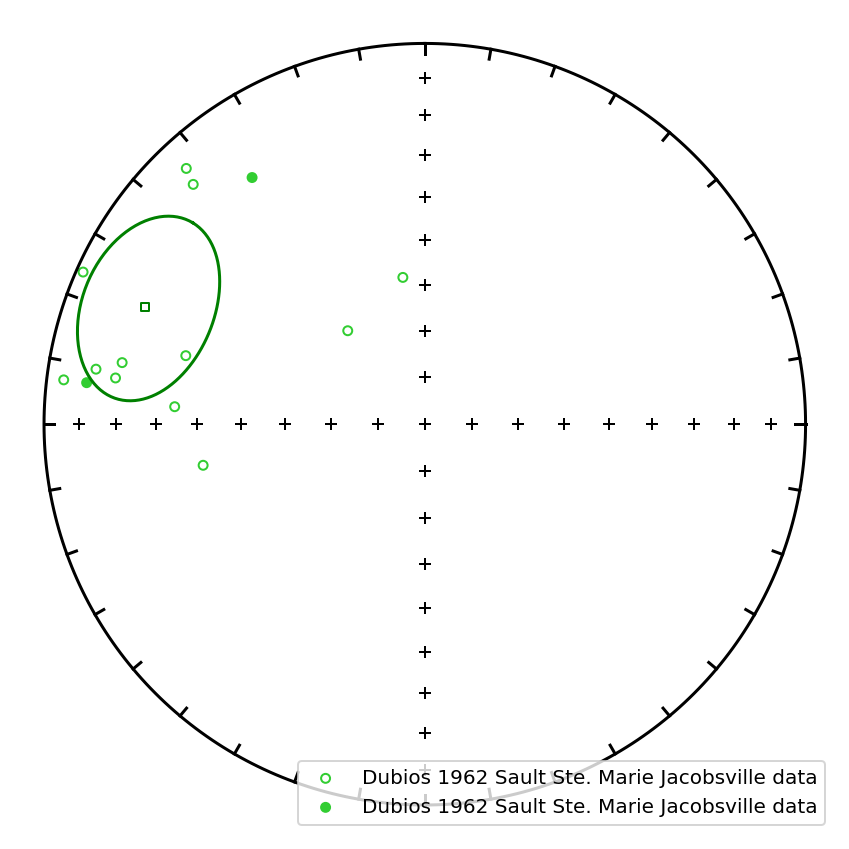

In [12]:
fignum = 1
plt.figure(num=fignum,figsize=(6,6))
ipmag.plot_net(fignum)

ipmag.plot_di(Dubois1962a_samples_Marie['dir_dec'].tolist(),Dubois1962a_samples_Marie['dir_inc'].tolist(),
              color='limegreen',label='Dubios 1962 Sault Ste. Marie Jacobsville data')
ipmag.plot_di_mean(Dubois1962a_samples_Marie_mean['dec'],Dubois1962a_samples_Marie_mean['inc'],Dubois1962a_samples_Marie_mean['alpha95'],
                   color='green', marker = 's')
plt.legend(loc=4)
# plt.savefig('../Figures/Pmag/Dubois1962_SSM_directions.pdf')
plt.show()

<Figure size 360x360 with 0 Axes>

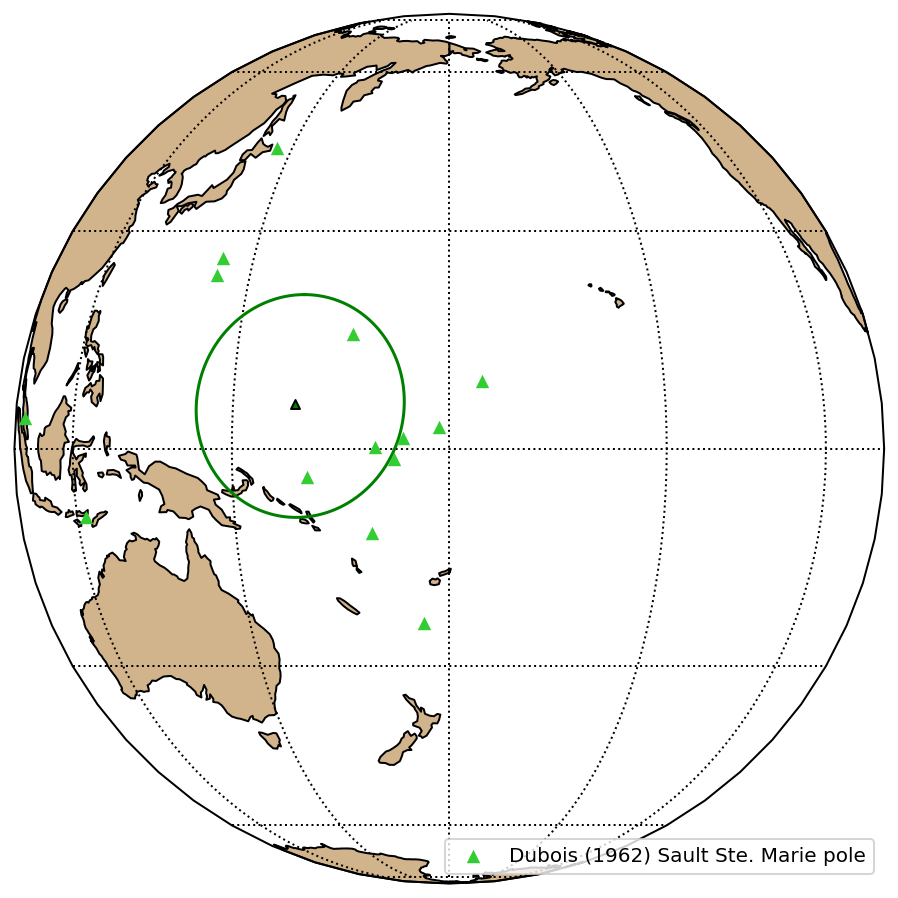

In [13]:
plt.figure(figsize=(5, 5))
map_axis=ipmag.make_orthographic_map(central_longitude=180,central_latitude=0)

ipmag.plot_vgp(map_axis, Dubois1962a_samples_Marie['vgp_lon'].tolist(), 
               Dubois1962a_samples_Marie['vgp_lat'].tolist(), markersize = 45, marker = '^', color = 'limegreen', edge='none', label = 'Dubois (1962) Sault Ste. Marie pole')

ipmag.plot_pole(map_axis, Dubois1962a_samples_Marie_mean_pole['dec'], 
                Dubois1962a_samples_Marie_mean_pole['inc'], 
                Dubois1962a_samples_Marie_mean_pole['alpha95'], 
                color = 'green', marker = '^')

plt.legend(loc=4)
# plt.savefig('../Figures/Pmag/Dubois1962_Keweenaw_poles.pdf')
plt.show()

## Roy and Robertson (1978)

This study collected 257 specimens (37 sites - site here means one section) of the Jacobsville Sandstone from the Keweenaw Peninsula, Marquette area, and Sault ste. Marie area of Canada. Thermal demagnetization, AF, as well as chemical leaching methods were used to demagnetize the sandstone samples and it is interpreted that a total of three components exist in the sandstone. 

It is found that the Jacobsville Sandstone from Sault Ste. Marie area have a pole position in the northern hemisphere whereas the sandstone in the Keweenaw Peninsula and marquette regions are of southern hemisphere, with the Keweenaw pole being more southerly than the Marquette pole. Similar results were found by Duboise (1962), data shown above.

The demagnetization protocol was cleaning. Chemical leaching is often 6700 hours, thermal demag is at 675 degree C, AF demag at 290 mT. 

**A major question: what is the definition of site for Roy (1978)? In Table 1 they listed the "site mean results" but also note the stratigraphic separation between different sites are often within 1 m. It seems that they are treating a stratigraphic horizon as one site and collect samples/specimens within one horizon and group them into an individual site. This is different from what we do - we collect samples across horizons and group all samples collected within one exposed Jacobsville strat section as one site. **

Their J2 remanence is very similar to our lt component - low temperature overprint of present day local field direction. It is still interesting, however, that some of the carrier of this component might have a coercivity of 200 mT - indicating that some of the pigmentary hematite wad contributing to the overprint. It is also interesting that their J2 direction mean is similar to our lt mean direction - a bit more easterly than expected!

Their J1 remanence is a shallow direction remanence consistent with our hdt component result. Their cut off between this J1 component and J2 component is set to be 100 hours, 600 degree C, or 200 mT treatment. 

- Roy, J. L., & Robertson, W. A. (1978). Paleomagnetism of the Jacobsville Formation and the apparent polar path for the interval− 1100 to− 670 my for North America. Journal of Geophysical Research: Solid Earth, 83(B3), 1289-1304.

Only J1 directions are compiled.

In [14]:
Roy1978a_sites = pd.read_csv('../Data/Pmag_compiled/Roy1978a_sites.txt', sep='\t', header=1)
Roy1978a_sites = Roy1978a_sites.dropna(axis=0)
Roy1978a_sites = ipmag.vgp_calc(Roy1978a_sites,tilt_correction='no',
    site_lon='lon',
    site_lat='lat',
    dec_is='dir_dec',
    inc_is='dir_inc',)
Roy1978a_sites.head()

site           location Area  dir_dec  dir_inc  dir_k  dir_n_samples  \
0     1  Northern Michigan    A    249.0    -11.0   52.0              5   
1     2  Northern Michigan    A    238.0     -5.0   63.0              7   
2     3  Northern Michigan    A    244.0     -1.0   59.0              7   
3     4  Northern Michigan    A    252.0    -12.0  148.0              5   
4     5  Northern Michigan    A    269.0      3.0   15.0              6   

   dir_n_specimens  dir_n_total_specimens  dir_alpha95  ...   lon   Plon  \
0                5                      5         11.0  ... -88.2  193.0   
1                7                      7          8.0  ... -87.2  204.0   
2                7                      7          8.0  ... -86.2  261.0   
3                5                      5          6.0  ... -85.2  191.0   
4                6                      6         21.0  ... -84.2  186.0   

   Plat  grain_size sample_color paleolatitude    vgp_lat     vgp_lon  \
0 -18.0     unknown      unknown     -5.551151 -18.239057  193.742487   
1 -23.0     unknown      unknown     -2.504769 -23.025711  205.788819   
2 -18.0     unknown      unknown     -0.500038 -17.679252  203.184762   
3 -17.0     unknown      unknown     -6.066525 -16.622061  194.058103   
4  -2.0     unknown      unknown      1.501029   0.425113  187.552767   

   vgp_lat_rev  vgp_lon_rev  
0    18.239057    13.742487  
1    23.025711    25.788819  
2    17.679252    23.184762  
3    16.622061    14.058103  
4    -0.425113     7.552767  

[5 rows x 21 columns]

**calculated pole position using rough general site location shows inconsistent values for site 3 - the provided pole longitude is way too easterly than calculated. The value should be around 200, but the table in Roy and Robertson (1978) has 261E. In this compilation, we will exclude this site from Roy and Robertson (1978)**

In [15]:
Roy1978a_sites = Roy1978a_sites[Roy1978a_sites['site'] != 3]
Roy1978a_sites_normal = Roy1978a_sites[Roy1978a_sites['dir_dec'] > 180]
Roy1978a_sites_reversed = Roy1978a_sites[Roy1978a_sites['dir_dec'] < 180]

In [16]:
Roy1978a_sites_A = Roy1978a_sites[Roy1978a_sites['Area'] == 'A']
Roy1978a_sites_B = Roy1978a_sites[Roy1978a_sites['Area'] == 'B']
Roy1978a_sites_C = Roy1978a_sites[Roy1978a_sites['Area'] == 'C']

Roy1978a_sites_A_mean_pole = ipmag.fisher_mean(Roy1978a_sites_A['Plon'].tolist(),
                                                        Roy1978a_sites_A['Plat'].tolist())
Roy1978a_sites_B_mean_pole = ipmag.fisher_mean(Roy1978a_sites_B['Plon'].tolist(),
                                                        Roy1978a_sites_B['Plat'].tolist())
Roy1978a_sites_C_mean_pole = ipmag.fisher_mean(Roy1978a_sites_C['Plon'].tolist(),
                                                        Roy1978a_sites_C['Plat'].tolist())

In [17]:
Roy1978a_sites_mean = ipmag.fisher_mean(Roy1978a_sites['dir_dec'].tolist(), Roy1978a_sites['dir_inc'].tolist())

Roy1978a_sites_mean_pole = ipmag.fisher_mean(Roy1978a_sites['Plon'].tolist(),
                                                        Roy1978a_sites['Plat'].tolist())
ipmag.print_pole_mean(Roy1978a_sites_mean_pole)

Plon: 181.3  Plat: -5.3
Number of directions in mean (n): 29
Angular radius of 95% confidence (A_95): 5.1
Precision parameter (k) estimate: 28.8


### all J1 directions and poles

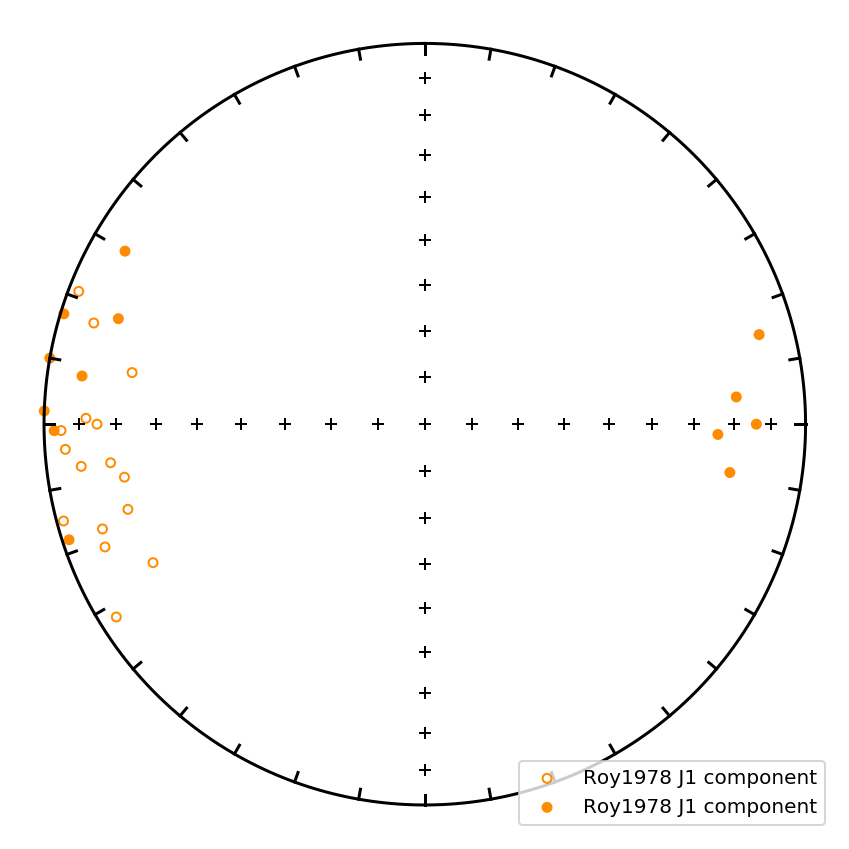

In [18]:
fignum = 1
plt.figure(num=fignum,figsize=(6,6))
ipmag.plot_net(fignum)

ipmag.plot_di(Roy1978a_sites['dir_dec'].tolist(),Roy1978a_sites['dir_inc'].tolist(),color='darkorange',label='Roy1978 J1 component')

# ipmag.plot_di_mean(Roy1978a_sites_mean['dec'],Roy1978a_sites_mean['inc'],Roy1978a_sites_mean['alpha95'],
#                    color='red', marker = 's')

plt.legend(loc=4)
# plt.savefig('../Figures/Pmag/Roy1978_J1_directions.pdf')
plt.show()

<Figure size 360x360 with 0 Axes>

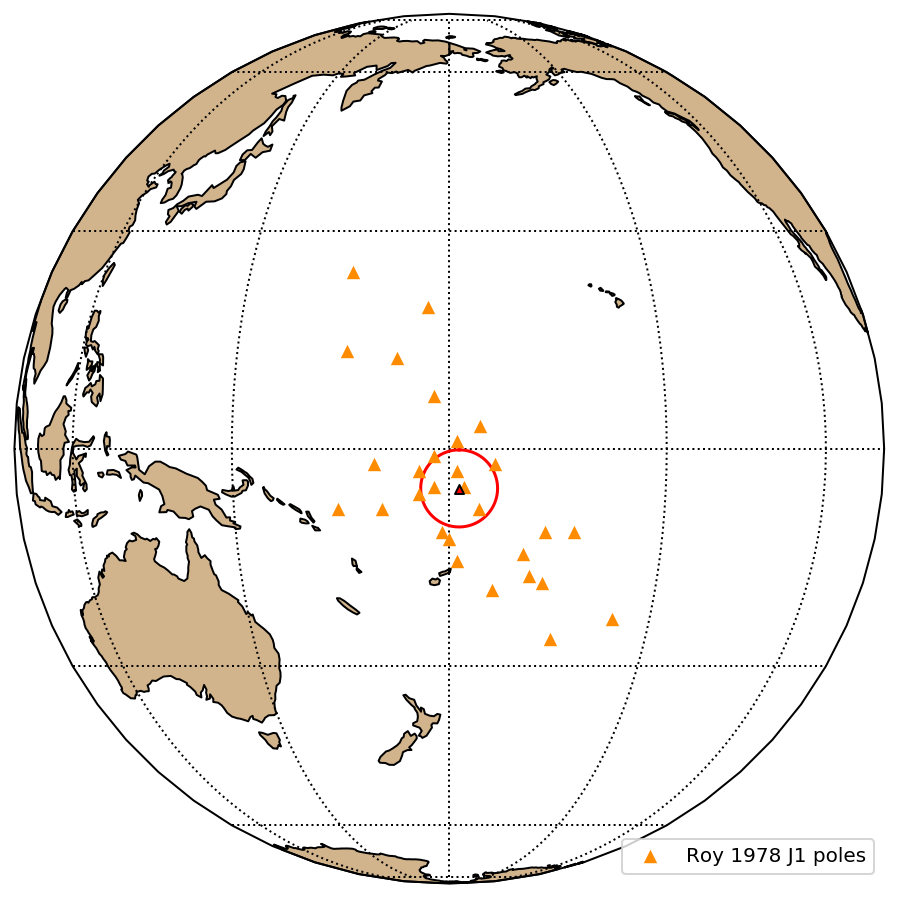

In [19]:
plt.figure(figsize=(5, 5))
map_axis=ipmag.make_orthographic_map(central_longitude=180,central_latitude=0)

ipmag.plot_vgp(map_axis, Roy1978a_sites['Plon'].tolist(), 
               Roy1978a_sites['Plat'].tolist(), 
               markersize = 45, 
               marker = '^', 
               color = 'darkorange', 
               edge='none', 
               label = 'Roy 1978 J1 poles')

ipmag.plot_pole(map_axis, Roy1978a_sites_mean_pole['dec'], 
                Roy1978a_sites_mean_pole['inc'], 
                Roy1978a_sites_mean_pole['alpha95'], 
                color = 'red', marker = '^')

plt.legend(loc=4)
# plt.savefig('../Figures/Pmag/Roy1978_J1_poles.pdf')
plt.show()

### Keweenaw directions

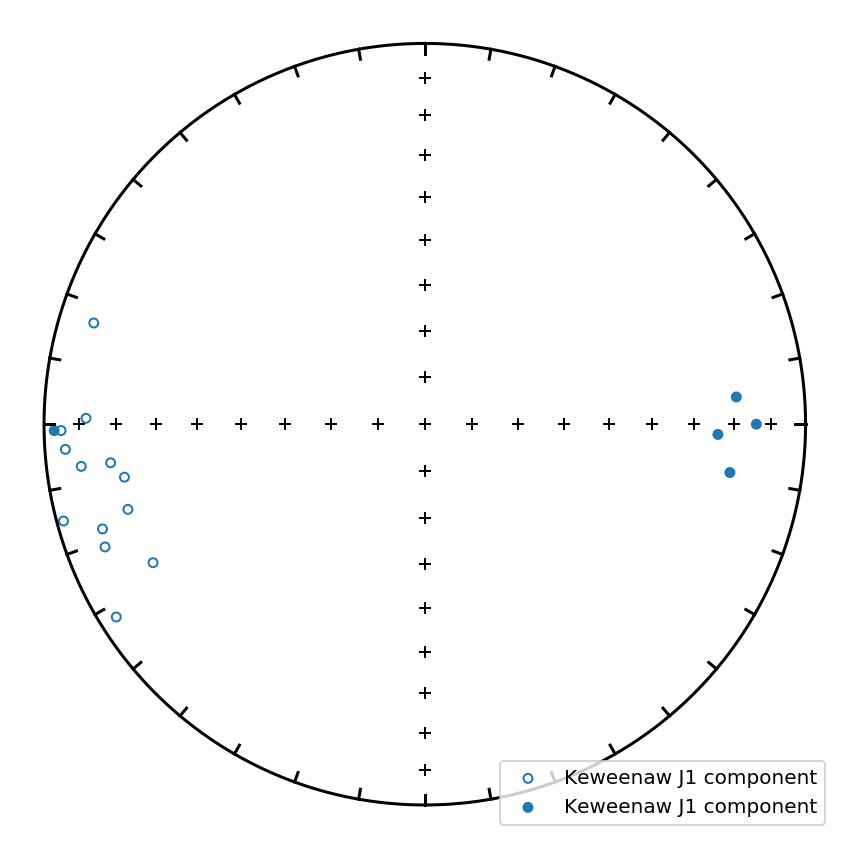

In [20]:
fignum = 1
plt.figure(num=fignum,figsize=(6,6))
ipmag.plot_net(fignum)

ipmag.plot_di(Roy1978a_sites_A['dir_dec'].tolist(),Roy1978a_sites_A['dir_inc'].tolist(),color='C0',label='Keweenaw J1 component')

# ipmag.plot_di_mean(Roy1978a_sites_mean['dec'],Roy1978a_sites_mean['inc'],Roy1978a_sites_mean['alpha95'],
#                    color='red', marker = 's')

plt.legend(loc=4)
# plt.savefig('../Figures/Pmag/Roy1978_Keweenaw_directions.pdf')
plt.show()

<Figure size 360x360 with 0 Axes>

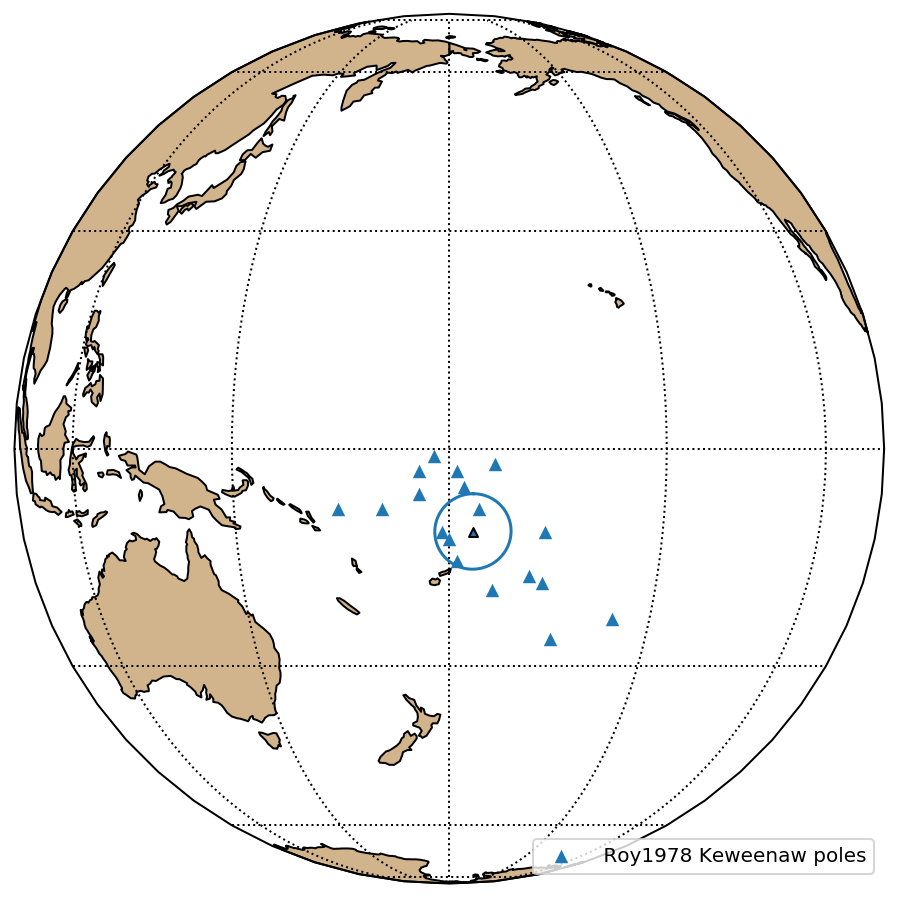

In [21]:
plt.figure(figsize=(5, 5))
map_axis=ipmag.make_orthographic_map(central_longitude=180,central_latitude=0)

ipmag.plot_vgp(map_axis, Roy1978a_sites_A['Plon'].tolist(), 
               Roy1978a_sites_A['Plat'].tolist(), 
               markersize = 45, 
               marker = '^',
               color = 'C0', 
               edge='none', 
               label = ' Roy1978 Keweenaw poles')

ipmag.plot_pole(map_axis, Roy1978a_sites_A_mean_pole['dec'], 
                Roy1978a_sites_A_mean_pole['inc'], 
                Roy1978a_sites_A_mean_pole['alpha95'], 
                color = 'C0', marker = '^')

plt.legend(loc=4)
# plt.savefig('../Figures/Pmag/Roy1978_Keweenaw_poles.pdf')
plt.show()

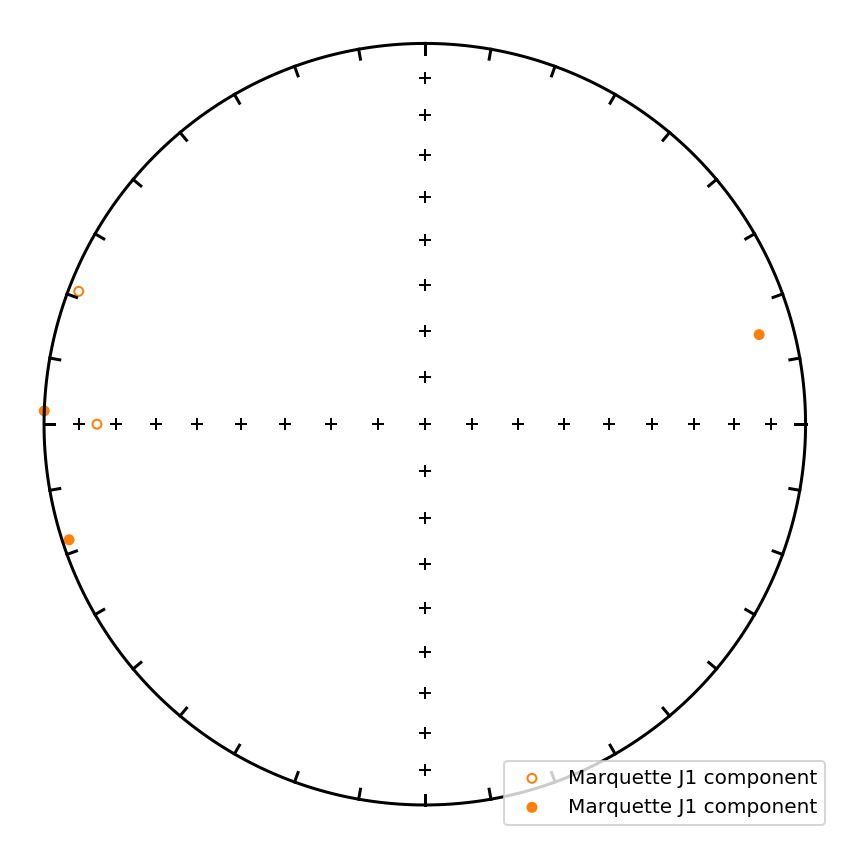

In [22]:
fignum = 1
plt.figure(num=fignum,figsize=(6,6))
ipmag.plot_net(fignum)

ipmag.plot_di(Roy1978a_sites_B['dir_dec'].tolist(),Roy1978a_sites_B['dir_inc'].tolist(),color='C1',label='Marquette J1 component')

# ipmag.plot_di_mean(Roy1978a_sites_mean['dec'],Roy1978a_sites_mean['inc'],Roy1978a_sites_mean['alpha95'],
#                    color='red', marker = 's')

plt.legend(loc=4)
# plt.savefig('../Figures/Pmag/Roy1978_Marquette_directions.pdf')
plt.show()

<Figure size 360x360 with 0 Axes>

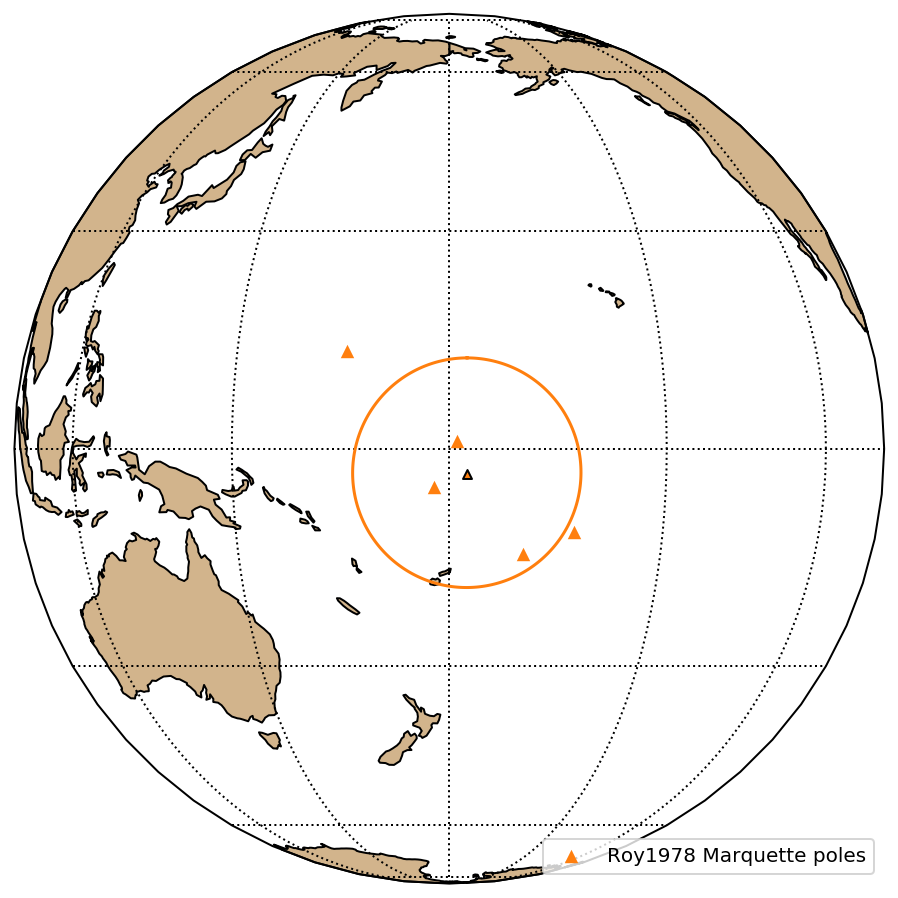

In [23]:
plt.figure(figsize=(5, 5))
map_axis=ipmag.make_orthographic_map(central_longitude=180,central_latitude=0)

ipmag.plot_vgp(map_axis, Roy1978a_sites_B['Plon'].tolist(), 
               Roy1978a_sites_B['Plat'].tolist(), 
               markersize = 45, 
               marker = '^', 
               color = 'C1', 
               edge='none', 
               label = 'Roy1978 Marquette poles')

ipmag.plot_pole(map_axis, Roy1978a_sites_B_mean_pole['dec'], 
                Roy1978a_sites_B_mean_pole['inc'], 
                Roy1978a_sites_B_mean_pole['alpha95'], 
                color = 'C1', marker = '^')

plt.legend(loc=4)
# plt.savefig('../Figures/Pmag/Roy1978_Marquette_poles.pdf')
plt.show()

### SSM directions

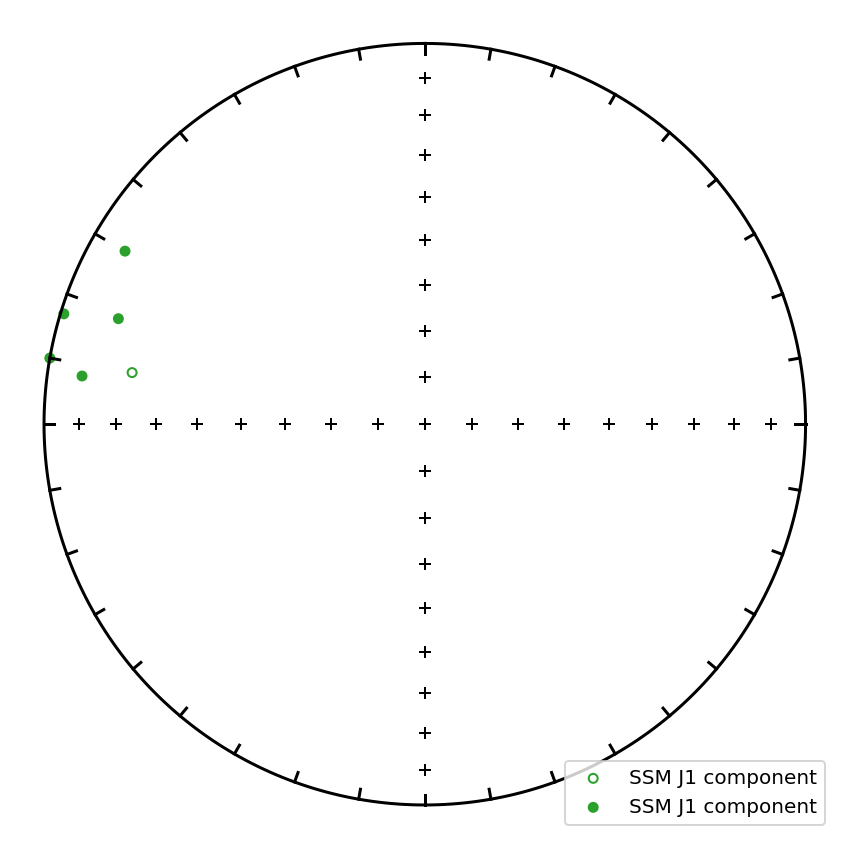

In [24]:
fignum = 1
plt.figure(num=fignum,figsize=(6,6))
ipmag.plot_net(fignum)

ipmag.plot_di(Roy1978a_sites_C['dir_dec'].tolist(),Roy1978a_sites_C['dir_inc'].tolist(),color='C2',label='SSM J1 component')

# ipmag.plot_di_mean(Roy1978a_sites_mean['dec'],Roy1978a_sites_mean['inc'],Roy1978a_sites_mean['alpha95'],
#                    color='red', marker = 's')

plt.legend(loc=4)
# plt.savefig('../Figures/Pmag/Roy1978_SSM_directions.pdf')
plt.show()

<Figure size 360x360 with 0 Axes>

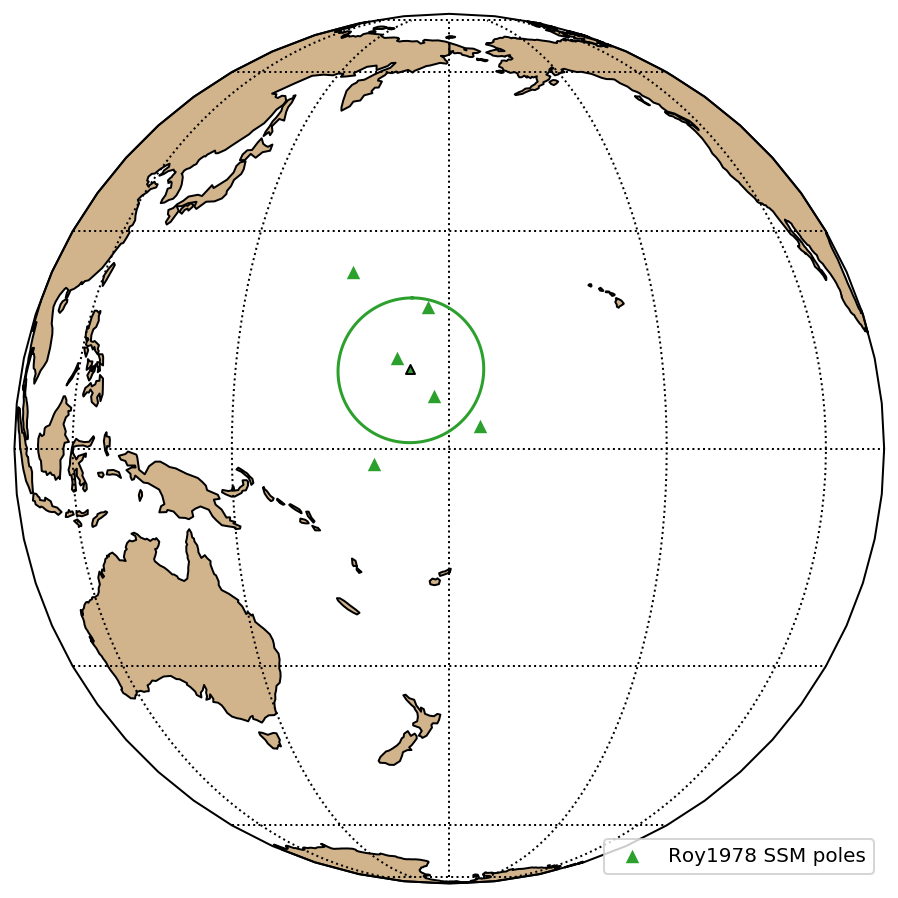

In [25]:
plt.figure(figsize=(5, 5))
map_axis=ipmag.make_orthographic_map(central_longitude=180,central_latitude=0)

ipmag.plot_vgp(map_axis, Roy1978a_sites_C['Plon'].tolist(), 
               Roy1978a_sites_C['Plat'].tolist(), 
               markersize = 45, 
               marker = '^', 
               color = 'C2', 
               edge='none', 
               label = 'Roy1978 SSM poles')

ipmag.plot_pole(map_axis, Roy1978a_sites_C_mean_pole['dec'], 
                Roy1978a_sites_C_mean_pole['inc'], 
                Roy1978a_sites_C_mean_pole['alpha95'], 
                color = 'C2', marker = '^')

plt.legend(loc=4)
# plt.savefig('../Figures/Pmag/Roy1978_SSM_poles.pdf')
plt.show()

**There are three possible explanations for the discrepancy between the J1 component directions in Keweenaw area and the Sault Ste. Marie area: (1) the directions reflect the sediments at SSM are older - with the Sault Ste. Marie Jacobsville being older (ca. 1050 Ma), closer to the Nonesuch-Freda pole position. This can be supported by the fact that the mean pole of all sites from Roy (1978) overlaps with the Nonesuch pole position. And this is consistent with that the Keweenaw Peninsulaa Jacobsville is younger (near the top, ca. 995 Ma) of the stratigraphic section of the whoe Jacobsville sedimentary package. (2) the directions reflect the Jacobsville spans much longer deposition time. (3) the directions are in fact inaccurate and insufficient to draw that conclusion. When we divide the data by area, we do not see many "site" level data for the different areas in Roy (1978) and that we do not see enough siltstone facies being used. According to the description from that study, a lot of the material are of coarse or very coarse lithology, and the color of the samples used vary from red to grey - indicating a great variety in hematite abundance. Such variable lithologies of the pmag samples pose complexities to the pmag data interpretation. In addition, Roy (1978) did not discuss inclination shallowing problem - although inclination shallowing may not be significant, it is necessary to investigate the issue with sedimentary paleomagnetic directions, especially when associated with red beds.**

## Combine poles from Sault Ste. Marie area from Dubois (1962) and Roy and Robertson (1978)

In [26]:
Jacobsville_SSM = pd.concat([Roy1978a_sites_C, Dubois1962a_samples_Marie])
Jacobsville_SSM_mean_pole = ipmag.fisher_mean(Jacobsville_SSM['Plon'].tolist(), Jacobsville_SSM['Plat'].tolist())

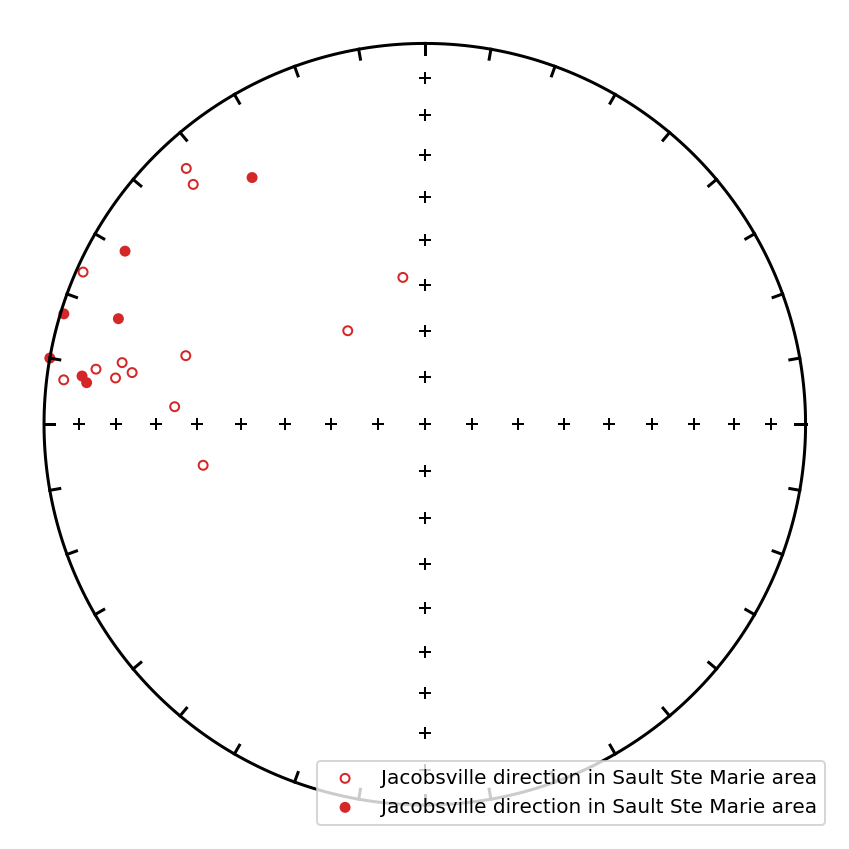

In [27]:
fignum = 1
plt.figure(num=fignum,figsize=(6,6))
ipmag.plot_net(fignum)

ipmag.plot_di(Jacobsville_SSM['dir_dec'].tolist(),Jacobsville_SSM['dir_inc'].tolist(),color='C3',label='Jacobsville direction in Sault Ste Marie area')

plt.legend(loc=4)
# plt.savefig('../Figures/specimen_directions.pdf')
plt.show()

<Figure size 360x360 with 0 Axes>

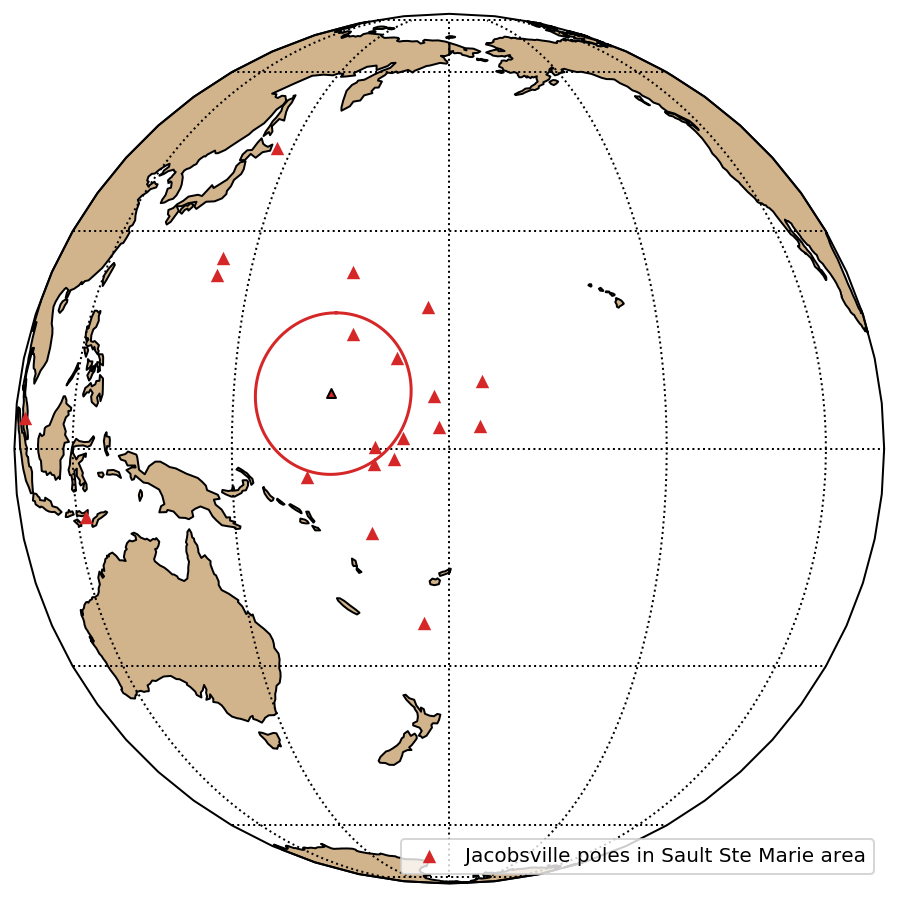

In [28]:
plt.figure(figsize=(5, 5))
map_axis=ipmag.make_orthographic_map(central_longitude=180,central_latitude=0)

ipmag.plot_vgp(map_axis, Jacobsville_SSM['Plon'].tolist(), 
               Jacobsville_SSM['Plat'].tolist(), markersize = 45, marker = '^', color = 'C3', edge='none', label = 'Jacobsville poles in Sault Ste Marie area')

ipmag.plot_pole(map_axis, Jacobsville_SSM_mean_pole['dec'], 
                Jacobsville_SSM_mean_pole['inc'], 
                Jacobsville_SSM_mean_pole['alpha95'], 
                color = 'C3', marker = '^')

plt.legend(loc=4)
plt.show()

## New pmag data from this study

- we collected new red bed fine sand or siltstones of Jacobsville across several strats near 

In [29]:
Jacobsville_site_locations = pd.read_csv('../Data/Jacobsville_site_locations.csv', index_col='site')
Jacobsville_specimen_data = pd.read_csv('../Data/Pmag_new/specimens.txt', sep='\t', header=1)
Jacobsville_sample_data = pd.read_csv('../Data/Pmag_new/samples.txt', sep='\t', header = 1)

Jacobsville_specimen_data = pd.merge(Jacobsville_specimen_data, 
                                     Jacobsville_sample_data[['sample', 'bed_dip', 'bed_dip_direction']], 
                                     left_on='sample', right_on='sample')

# add site location to specimens to help calculate vgp
Jacobsville_specimen_data['latitude'] = [Jacobsville_site_locations['latitude'][i] for i in Jacobsville_specimen_data['site']]
Jacobsville_specimen_data['longitude'] = [Jacobsville_site_locations['longitude'][i] for i in Jacobsville_specimen_data['site']]

Jacobsville_specimen_data = ipmag.vgp_calc(Jacobsville_specimen_data, tilt_correction='no', site_lon='longitude', site_lat='latitude', dec_is='dir_dec', inc_is='dir_inc')

Jacobsville_specimen_data['Plon'] = [Jacobsville_specimen_data['vgp_lon_rev'][i] if Jacobsville_specimen_data['dir_dec'][i]<180 else Jacobsville_specimen_data['vgp_lon'][i] for i in range(Jacobsville_specimen_data.shape[0])]
Jacobsville_specimen_data['Plat'] = [Jacobsville_specimen_data['vgp_lat_rev'][i] if Jacobsville_specimen_data['dir_dec'][i]<180 else Jacobsville_specimen_data['vgp_lat'][i] for i in range(Jacobsville_specimen_data.shape[0])]

Jacobsville_specimen_data.head()

specimen       experiments   sample  dir_alpha95 dir_comp  dir_dec  dir_inc  \
0  AF1-10a               NaN  AF1-10a          NaN      NaN      NaN      NaN   
1  AF1-10a  AF1-10a_LP-DIR-T  AF1-10a          NaN      hdt    276.4    -11.9   
2  AF1-10a  AF1-10a_LP-DIR-T  AF1-10a          NaN      hdt    276.5    -11.3   
3  AF1-10a  AF1-10a_LP-DIR-T  AF1-10a          NaN      hdt     51.2     48.2   
4  AF1-11a  AF1-11a_LP-DIR-T  AF1-11a          NaN      hdt    276.5     -9.6   

   dir_n_comps  dir_n_measurements  dir_tilt_correction  ...  \
0          NaN                 NaN                  NaN  ...   
1          1.0                13.0                100.0  ...   
2          1.0                13.0                  0.0  ...   
3          1.0                13.0                 -1.0  ...   
4          1.0                13.0                100.0  ...   

   bed_dip_direction  latitude  longitude  paleolatitude    vgp_lat  \
0              332.0  46.48098  -89.09036            NaN        NaN   
1              332.0  46.48098  -89.09036      -6.014864   0.019994   
2              332.0  46.48098  -89.09036      -5.705480   0.313681   
3              332.0  46.48098  -89.09036      29.214775  46.930311   
4              332.0  46.48098  -89.09036      -4.833926   0.949288   

      vgp_lon vgp_lat_rev vgp_lon_rev        Plon       Plat  
0         NaN         NaN         NaN         NaN        NaN  
1  172.135389   -0.019994  352.135389  172.135389   0.019994  
2  172.274538   -0.313681  352.274538  172.274538   0.313681  
3    5.991339  -46.930311  185.991339  185.991339 -46.930311  
4  172.870907   -0.949288  352.870907  172.870907   0.949288  

[5 rows x 37 columns]

In [30]:
AF1_spec_data = Jacobsville_specimen_data[Jacobsville_specimen_data['specimen'].str.contains('AF1')]
AF2_spec_data = Jacobsville_specimen_data[Jacobsville_specimen_data['specimen'].str.contains('AF2')]
AFC_spec_data = Jacobsville_specimen_data[Jacobsville_specimen_data['specimen'].str.contains('AFC')]
HF1_spec_data = Jacobsville_specimen_data[Jacobsville_specimen_data['specimen'].str.contains('HF1')]
HF2_spec_data = Jacobsville_specimen_data[Jacobsville_specimen_data['specimen'].str.contains('HF2')]
HF3_spec_data = Jacobsville_specimen_data[Jacobsville_specimen_data['specimen'].str.contains('HF3')]
HF4_spec_data = Jacobsville_specimen_data[Jacobsville_specimen_data['specimen'].str.contains('HF4')]
HF5_spec_data = Jacobsville_specimen_data[Jacobsville_specimen_data['specimen'].str.contains('HF5')]
HF6_spec_data = Jacobsville_specimen_data[Jacobsville_specimen_data['specimen'].str.contains('HF6')]
HF7_spec_data = Jacobsville_specimen_data[Jacobsville_specimen_data['specimen'].str.contains('HF7')]
HFC_spec_data = Jacobsville_specimen_data[Jacobsville_specimen_data['specimen'].str.contains('HFC')]

JK2_spec_data = Jacobsville_specimen_data[Jacobsville_specimen_data['specimen'].str.contains('JK2')]
JK3_spec_data = Jacobsville_specimen_data[Jacobsville_specimen_data['specimen'].str.contains('JK3')]
NW1_spec_data = Jacobsville_specimen_data[Jacobsville_specimen_data['specimen'].str.contains('NW1')]
NW2_spec_data = Jacobsville_specimen_data[Jacobsville_specimen_data['specimen'].str.contains('NW2')]
SC1_spec_data = Jacobsville_specimen_data[Jacobsville_specimen_data['specimen'].str.contains('SC1')]

- lt component: low temperature component of the fit, using geographic coordinates
- mt component: mid temperture component, compare geographic and tilt corrected coordinates
- hdt component: high temperature component, compare geographic and tilt corrected coordinates

In [31]:
AF1_spec_hct_tc = AF1_spec_data[(AF1_spec_data['dir_comp'] == 'hct') & (AF1_spec_data['dir_tilt_correction'] == 100)]
AF1_spec_hdt_tc = AF1_spec_data[(AF1_spec_data['dir_comp'] == 'hdt') & (AF1_spec_data['dir_tilt_correction'] == 100)]

AF2_spec_hct_tc = AF2_spec_data[(AF2_spec_data['dir_comp'] == 'hct') & (AF2_spec_data['dir_tilt_correction'] == 100)]
AF2_spec_hdt_tc = AF2_spec_data[(AF2_spec_data['dir_comp'] == 'hdt') & (AF2_spec_data['dir_tilt_correction'] == 100)]

AFC_spec_hct_tc = AFC_spec_data[(AFC_spec_data['dir_comp'] == 'hct') & (AFC_spec_data['dir_tilt_correction'] == 100)]
AFC_spec_hdt_tc = AFC_spec_data[(AFC_spec_data['dir_comp'] == 'hdt') & (AFC_spec_data['dir_tilt_correction'] == 100)]

HF1_spec_hct_tc = HF1_spec_data[(HF1_spec_data['dir_comp'] == 'hct') & (HF1_spec_data['dir_tilt_correction'] == 100)]
HF1_spec_hdt_tc = HF1_spec_data[(HF1_spec_data['dir_comp'] == 'hdt') & (HF1_spec_data['dir_tilt_correction'] == 100)]

HF2_spec_hct_tc = HF2_spec_data[(HF2_spec_data['dir_comp'] == 'hct') & (HF2_spec_data['dir_tilt_correction'] == 100)]
HF2_spec_hdt_tc = HF2_spec_data[(HF2_spec_data['dir_comp'] == 'hdt') & (HF2_spec_data['dir_tilt_correction'] == 100)]

HF3_spec_hct_tc = HF3_spec_data[(HF3_spec_data['dir_comp'] == 'hct') & (HF3_spec_data['dir_tilt_correction'] == 100)]
HF3_spec_hdt_tc = HF3_spec_data[(HF3_spec_data['dir_comp'] == 'hdt') & (HF3_spec_data['dir_tilt_correction'] == 100)]

HF4_spec_hct_tc = HF4_spec_data[(HF4_spec_data['dir_comp'] == 'hct') & (HF4_spec_data['dir_tilt_correction'] == 100)]
HF4_spec_hdt_tc = HF4_spec_data[(HF4_spec_data['dir_comp'] == 'hdt') & (HF4_spec_data['dir_tilt_correction'] == 100)]

HF5_spec_hct_tc = HF5_spec_data[(HF5_spec_data['dir_comp'] == 'hct') & (HF5_spec_data['dir_tilt_correction'] == 100)]
HF5_spec_hdt_tc = HF5_spec_data[(HF5_spec_data['dir_comp'] == 'hdt') & (HF5_spec_data['dir_tilt_correction'] == 100)]

HF6_spec_hct_tc = HF6_spec_data[(HF6_spec_data['dir_comp'] == 'hct') & (HF6_spec_data['dir_tilt_correction'] == 100)]
HF6_spec_hdt_tc = HF6_spec_data[(HF6_spec_data['dir_comp'] == 'hdt') & (HF6_spec_data['dir_tilt_correction'] == 100)]

HF7_spec_hct_tc = HF7_spec_data[(HF7_spec_data['dir_comp'] == 'hct') & (HF7_spec_data['dir_tilt_correction'] == 100)]
HF7_spec_hdt_tc = HF7_spec_data[(HF7_spec_data['dir_comp'] == 'hdt') & (HF7_spec_data['dir_tilt_correction'] == 100)]

HFC_spec_hct_tc = HFC_spec_data[(HFC_spec_data['dir_comp'] == 'hct') & (HFC_spec_data['dir_tilt_correction'] == 100)]
HFC_spec_hdt_tc = HFC_spec_data[(HFC_spec_data['dir_comp'] == 'hdt') & (HFC_spec_data['dir_tilt_correction'] == 100)]

SC1_spec_lt_gc = SC1_spec_data[(SC1_spec_data['dir_comp'] == 'lt') & (SC1_spec_data['dir_tilt_correction'] == 0)]
SC1_spec_hct_tc = SC1_spec_data[(SC1_spec_data['dir_comp'] == 'hct') & (SC1_spec_data['dir_tilt_correction'] == 100)]
SC1_spec_hdt_gc = SC1_spec_data[(SC1_spec_data['dir_comp'] == 'hdt') & (SC1_spec_data['dir_tilt_correction'] == 0)]
SC1_spec_hdt_tc = SC1_spec_data[(SC1_spec_data['dir_comp'] == 'hdt') & (SC1_spec_data['dir_tilt_correction'] == 100)]

JK2_spec_hct_tc = JK2_spec_data[(JK2_spec_data['dir_comp'] == 'hct') & (JK2_spec_data['dir_tilt_correction'] == 100)]
JK2_spec_hdt_tc = JK2_spec_data[(JK2_spec_data['dir_comp'] == 'hdt') & (JK2_spec_data['dir_tilt_correction'] == 100)]

JK3_spec_hct_tc = JK3_spec_data[(JK3_spec_data['dir_comp'] == 'hct') & (JK3_spec_data['dir_tilt_correction'] == 100)]
JK3_spec_hdt_tc = JK3_spec_data[(JK3_spec_data['dir_comp'] == 'hdt') & (JK3_spec_data['dir_tilt_correction'] == 100)]

NW1_spec_hct_tc = NW1_spec_data[(NW1_spec_data['dir_comp'] == 'hct') & (NW1_spec_data['dir_tilt_correction'] == 100)]
NW1_spec_hdt_tc = NW1_spec_data[(NW1_spec_data['dir_comp'] == 'hdt') & (NW1_spec_data['dir_tilt_correction'] == 100)]
NW1_spec_hdt_gc = NW1_spec_data[(NW1_spec_data['dir_comp'] == 'hdt') & (NW1_spec_data['dir_tilt_correction'] == 0)]

NW2_spec_hct_tc = NW2_spec_data[(NW2_spec_data['dir_comp'] == 'hct') & (NW2_spec_data['dir_tilt_correction'] == 100)]
NW2_spec_hdt_tc = NW2_spec_data[(NW2_spec_data['dir_comp'] == 'hdt') & (NW2_spec_data['dir_tilt_correction'] == 100)]
NW2_spec_hdt_gc = NW2_spec_data[(NW2_spec_data['dir_comp'] == 'hdt') & (NW2_spec_data['dir_tilt_correction'] == 0)]

### AF1

- this is the Agate Falls section collected from river left during field season 2020
- This section at Agate Falls has dual polarities and it likely captured a transitional field with specimen 16a and 17a. We interpret these two specimens to have captured a transitional field because 17a which is stratigraphically higher than (about 60 cm) the specimen 16a has similar normal direction but is closer to the reversed polarity directions, which are captured by specimens 18 to 24. 
- specimen 1-15 record exactly same W and up direction just as AF2 specimen 9-22 do. 

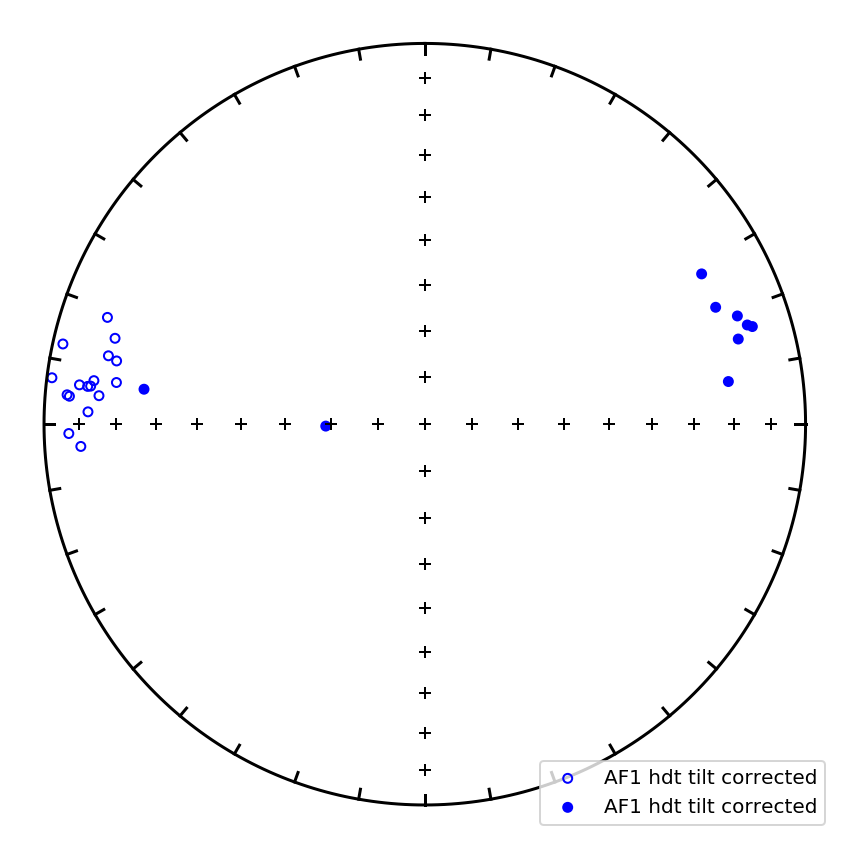

In [32]:
fignum = 1
plt.figure(num=fignum,figsize=(6,6))
ipmag.plot_net(fignum)
ipmag.plot_di(AF1_spec_hdt_tc['dir_dec'].tolist(),AF1_spec_hdt_tc['dir_inc'].tolist(),color='b',label='AF1 hdt tilt corrected')


plt.legend(loc=4)
plt.show()

In [33]:
# drop 16a and 17a
AF1_spec_hdt_tc_transition = AF1_spec_hdt_tc[AF1_spec_hdt_tc['specimen'].str.contains('-16a|-17a')]
AF1_spec_hdt_tc = AF1_spec_hdt_tc[~AF1_spec_hdt_tc['specimen'].str.contains('-16a|-17a')]
AF1_spec_hdt_tc_N = AF1_spec_hdt_tc[AF1_spec_hdt_tc['dir_inc'] < 0]
AF1_spec_hdt_tc_R = AF1_spec_hdt_tc[AF1_spec_hdt_tc['dir_inc'] > 0]
AF1_spec_hdt_tc_N_mean = ipmag.fisher_mean(AF1_spec_hdt_tc_N['dir_dec'].tolist(), AF1_spec_hdt_tc_N['dir_inc'].tolist())
AF1_spec_hdt_tc_R_mean = ipmag.fisher_mean(AF1_spec_hdt_tc_R['dir_dec'].tolist(), AF1_spec_hdt_tc_R['dir_inc'].tolist())
AF1_spec_hct_tc_mean = ipmag.fisher_mean(AF1_spec_hct_tc['dir_dec'].tolist(), AF1_spec_hct_tc['dir_inc'].tolist())

In [34]:
AF1_spec_hdt_tc_N_mean_pole = ipmag.fisher_mean(AF1_spec_hdt_tc_N['vgp_lon'].tolist(), AF1_spec_hdt_tc_N['vgp_lat'].tolist())
AF1_spec_hdt_tc_R_mean_pole = ipmag.fisher_mean(AF1_spec_hdt_tc_R['vgp_lon_rev'].tolist(), AF1_spec_hdt_tc_R['vgp_lat_rev'].tolist())
AF1_spec_hct_tc_mean_pole = ipmag.fisher_mean(AF1_spec_hct_tc['vgp_lon_rev'].tolist(), AF1_spec_hct_tc['vgp_lat_rev'].tolist())

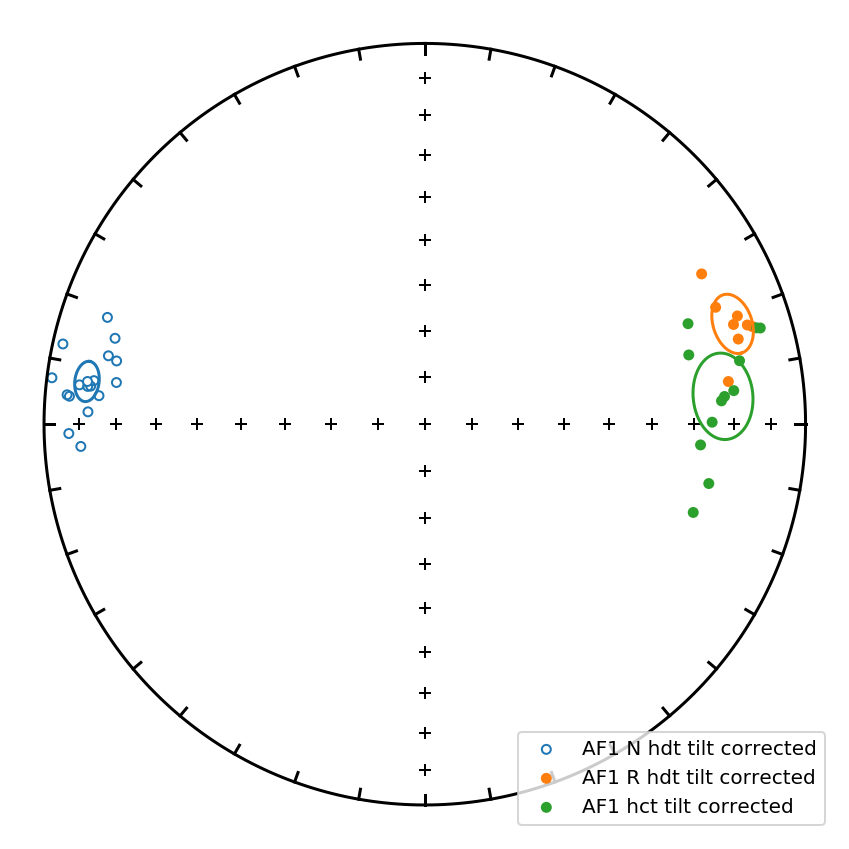

In [35]:
fignum = 1
plt.figure(num=fignum,figsize=(6,6))
ipmag.plot_net(fignum)
ipmag.plot_di(AF1_spec_hdt_tc_N['dir_dec'].tolist(),AF1_spec_hdt_tc_N['dir_inc'].tolist(),color='C0',label='AF1 N hdt tilt corrected')
ipmag.plot_di(AF1_spec_hdt_tc_R['dir_dec'].tolist(),AF1_spec_hdt_tc_R['dir_inc'].tolist(),color='C1',label='AF1 R hdt tilt corrected')
ipmag.plot_di_mean(AF1_spec_hdt_tc_N_mean['dec'], AF1_spec_hdt_tc_N_mean['inc'], AF1_spec_hdt_tc_N_mean['alpha95'], color = 'C0')
ipmag.plot_di_mean(AF1_spec_hdt_tc_R_mean['dec'], AF1_spec_hdt_tc_R_mean['inc'], AF1_spec_hdt_tc_R_mean['alpha95'], color = 'C1')
ipmag.plot_di(AF1_spec_hct_tc['dir_dec'].tolist(),AF1_spec_hct_tc['dir_inc'].tolist(),color='C2',label='AF1 hct tilt corrected')
ipmag.plot_di_mean(AF1_spec_hct_tc_mean['dec'], AF1_spec_hct_tc_mean['inc'], AF1_spec_hct_tc_mean['alpha95'], color = 'C2')

plt.legend(loc=4)
# plt.title('dual polarity without transition field captured by Agate Falls specimens')
# plt.savefig('../Figures/Pmag/AF1_directions.pdf')
plt.show()

<Figure size 360x360 with 0 Axes>

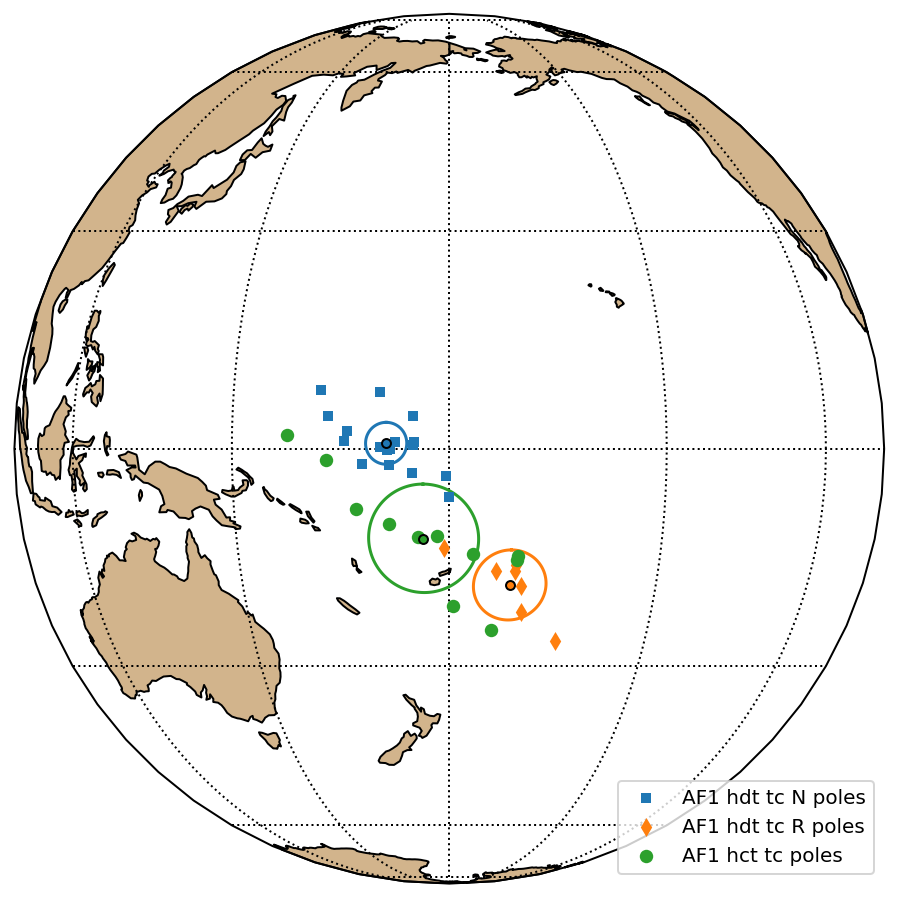

In [36]:
plt.figure(figsize=(5, 5))
map_axis=ipmag.make_orthographic_map(central_longitude=180,central_latitude=0)

ipmag.plot_vgp(map_axis, AF1_spec_hdt_tc_N['vgp_lon'].tolist(), 
               AF1_spec_hdt_tc_N['vgp_lat'].tolist(), 
               markersize = 25, 
               marker = 's', 
               color = 'C0', 
               edge='none', 
               label = 'AF1 hdt tc N poles')

ipmag.plot_vgp(map_axis, AF1_spec_hdt_tc_R['vgp_lon_rev'].tolist(), 
               AF1_spec_hdt_tc_R['vgp_lat_rev'].tolist(), 
               markersize = 45, 
               marker = 'd', 
               color = 'C1', 
               edge='none', 
               label = 'AF1 hdt tc R poles')

ipmag.plot_vgp(map_axis, AF1_spec_hct_tc['vgp_lon_rev'].tolist(), 
               AF1_spec_hct_tc['vgp_lat_rev'].tolist(), 
               markersize = 45, 
               marker = 'o', 
               color = 'C2', 
               edge='none', 
               label = 'AF1 hct tc poles')

ipmag.plot_pole(map_axis, AF1_spec_hdt_tc_N_mean_pole['dec'], 
                AF1_spec_hdt_tc_N_mean_pole['inc'], 
                AF1_spec_hdt_tc_N_mean_pole['alpha95'], 
                color = 'C0', marker = 'o')
ipmag.plot_pole(map_axis, AF1_spec_hdt_tc_R_mean_pole['dec'], 
                AF1_spec_hdt_tc_R_mean_pole['inc'], 
                AF1_spec_hdt_tc_R_mean_pole['alpha95'], 
                color = 'C1', marker = 'o')
ipmag.plot_pole(map_axis, AF1_spec_hct_tc_mean_pole['dec'], 
                AF1_spec_hct_tc_mean_pole['inc'], 
                AF1_spec_hct_tc_mean_pole['alpha95'], 
                color = 'C2', marker = 'o')

plt.legend(loc=4)
# plt.savefig('../Figures/Pmag/AF1_poles.pdf')
plt.show()

**It is interesting that the mean pole positions derived from the normal and reversed directions do not share a common mean. Given their stratigraphic relationship that the reversed polarity is up section from the normal direction, it is likely that the discrepancy between the pole position is partly caused by Laurentia's continued motion during the deposition of Jacobsville. Or it could be that our current sample number is not enough for averaging out the paleosecular variation. Note that there is about 60 cm distance between specimen 16a and 17a, which might provide us an estimate for the depositional rate/age estimate for the section of the Jacobsville?**

### AF2 

- this is the Agate Falls section collected from river right during field season 2021

- 1-8 specimens are SW and down, 9-22 are tightly clustered W and up - confirming that AF1 was sampling a bit of excursion, and under sampling the PSV

- specimen 5a has wierd declination. it could be an excursion or orienting issue

- specimen 23a records a transitional field between 22a and 24a when the reversal occurs (N-R). 

- specimens 43a is at the top of the section of AF2 - it could have captured a transitional field perhaps during or after the reversed chron. 

- These three specimens will not be included for mean pole/direction calculation. 

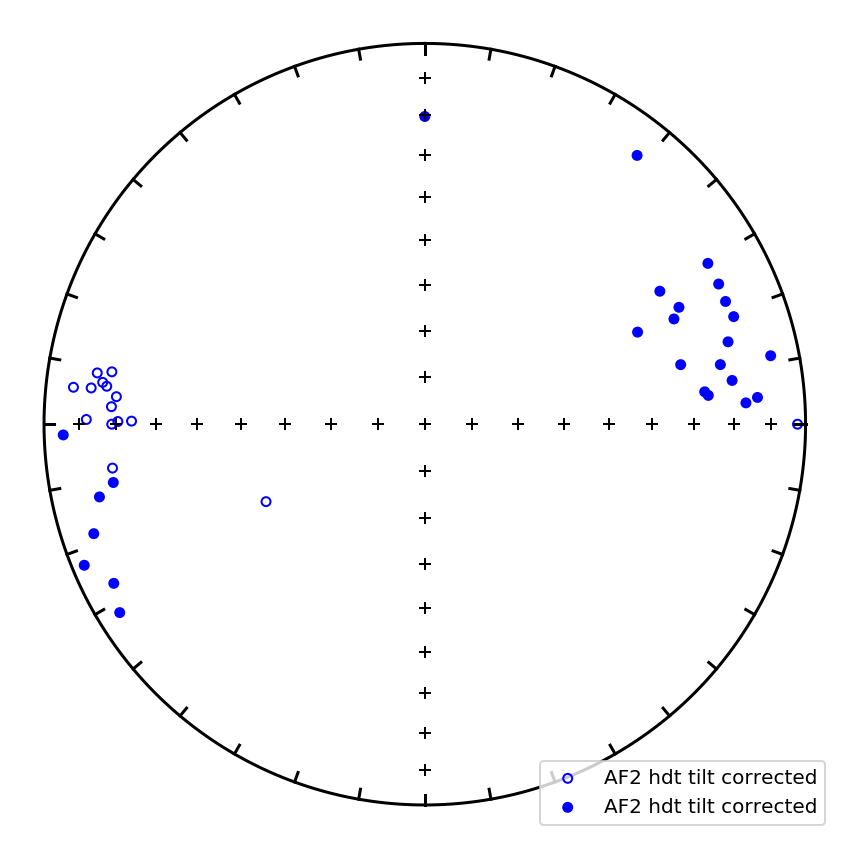

In [37]:
fignum = 1
plt.figure(num=fignum,figsize=(6,6))
ipmag.plot_net(fignum)
ipmag.plot_di(AF2_spec_hdt_tc['dir_dec'].tolist(),AF2_spec_hdt_tc['dir_inc'].tolist(),color='b',label='AF2 hdt tilt corrected')


plt.legend(loc=4)
plt.show()

In [38]:
# drop 5a 23a 43a
AF2_spec_hdt_tc_transition = AF2_spec_hdt_tc[AF2_spec_hdt_tc['specimen'].str.contains('-23a|-43a')]
AF2_spec_hdt_tc = AF2_spec_hdt_tc[~AF2_spec_hdt_tc['specimen'].str.contains('-5a|-23a|-43a')]
AF2_spec_hdt_tc_N = AF2_spec_hdt_tc[AF2_spec_hdt_tc['dir_dec'] > 180]
AF2_spec_hdt_tc_R = AF2_spec_hdt_tc[AF2_spec_hdt_tc['dir_dec'] < 180]
AF2_spec_hdt_tc_N_mean = ipmag.fisher_mean(AF2_spec_hdt_tc_N['dir_dec'].tolist(), AF2_spec_hdt_tc_N['dir_inc'].tolist())
AF2_spec_hdt_tc_R_mean = ipmag.fisher_mean(AF2_spec_hdt_tc_R['dir_dec'].tolist(), AF2_spec_hdt_tc_R['dir_inc'].tolist())

AF2_spec_hct_tc_mean = ipmag.fisher_mean(AF2_spec_hct_tc['dir_dec'].tolist(), AF2_spec_hct_tc['dir_inc'].tolist())

In [39]:
AF2_spec_hdt_tc_N_mean_pole = ipmag.fisher_mean(AF2_spec_hdt_tc_N['vgp_lon'].tolist(), AF2_spec_hdt_tc_N['vgp_lat'].tolist())
AF2_spec_hdt_tc_R_mean_pole = ipmag.fisher_mean(AF2_spec_hdt_tc_R['vgp_lon_rev'].tolist(), AF2_spec_hdt_tc_R['vgp_lat_rev'].tolist())
AF2_spec_hct_tc_mean_pole = ipmag.fisher_mean(AF2_spec_hct_tc['vgp_lon_rev'].tolist(), AF2_spec_hct_tc['vgp_lat_rev'].tolist())

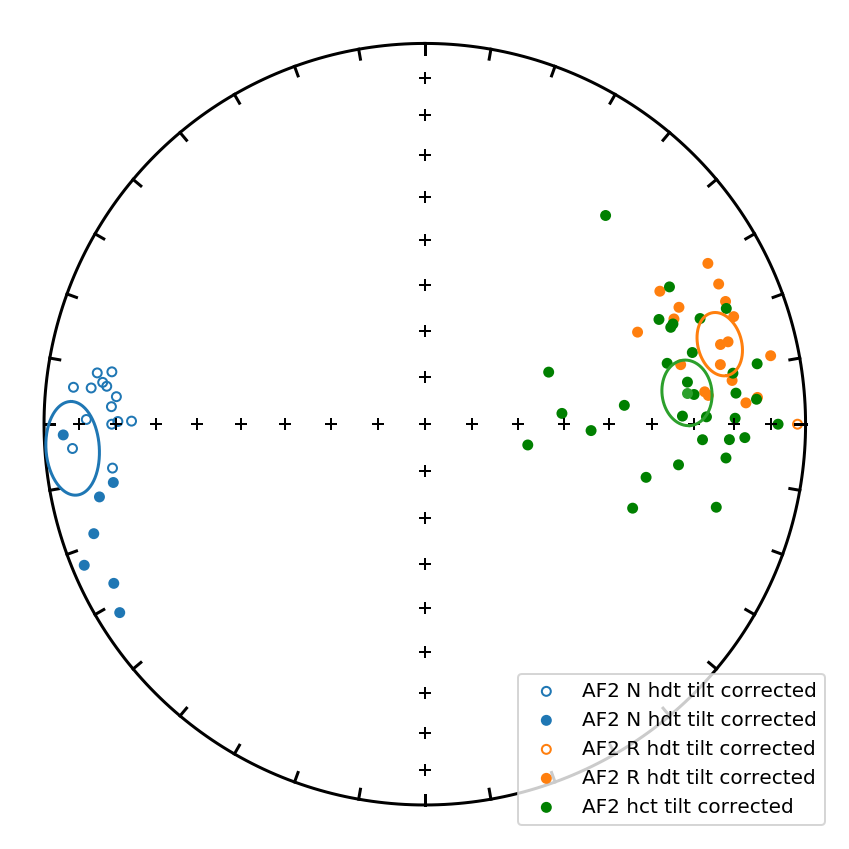

In [40]:
fignum = 1
plt.figure(num=fignum,figsize=(6,6))
ipmag.plot_net(fignum)
ipmag.plot_di(AF2_spec_hdt_tc_N['dir_dec'].tolist(),AF2_spec_hdt_tc_N['dir_inc'].tolist(),color='C0',label='AF2 N hdt tilt corrected')
ipmag.plot_di(AF2_spec_hdt_tc_R['dir_dec'].tolist(),AF2_spec_hdt_tc_R['dir_inc'].tolist(),color='C1',label='AF2 R hdt tilt corrected')
ipmag.plot_di_mean(AF2_spec_hdt_tc_N_mean['dec'], AF2_spec_hdt_tc_N_mean['inc'], AF2_spec_hdt_tc_N_mean['alpha95'], color = 'C0')
ipmag.plot_di_mean(AF2_spec_hdt_tc_R_mean['dec'], AF2_spec_hdt_tc_R_mean['inc'], AF2_spec_hdt_tc_R_mean['alpha95'], color = 'C1')
ipmag.plot_di(AF2_spec_hct_tc['dir_dec'].tolist(),AF2_spec_hct_tc['dir_inc'].tolist(),color='g',label='AF2 hct tilt corrected')
ipmag.plot_di_mean(AF2_spec_hct_tc_mean['dec'], AF2_spec_hct_tc_mean['inc'], AF2_spec_hct_tc_mean['alpha95'], color = 'C2')


plt.legend(loc=4)
# plt.title('dual polarity without transition field captured by Agate Falls specimens')
# plt.savefig('../Figures/Pmag/AF2_directions.pdf')
plt.show()

<Figure size 360x360 with 0 Axes>

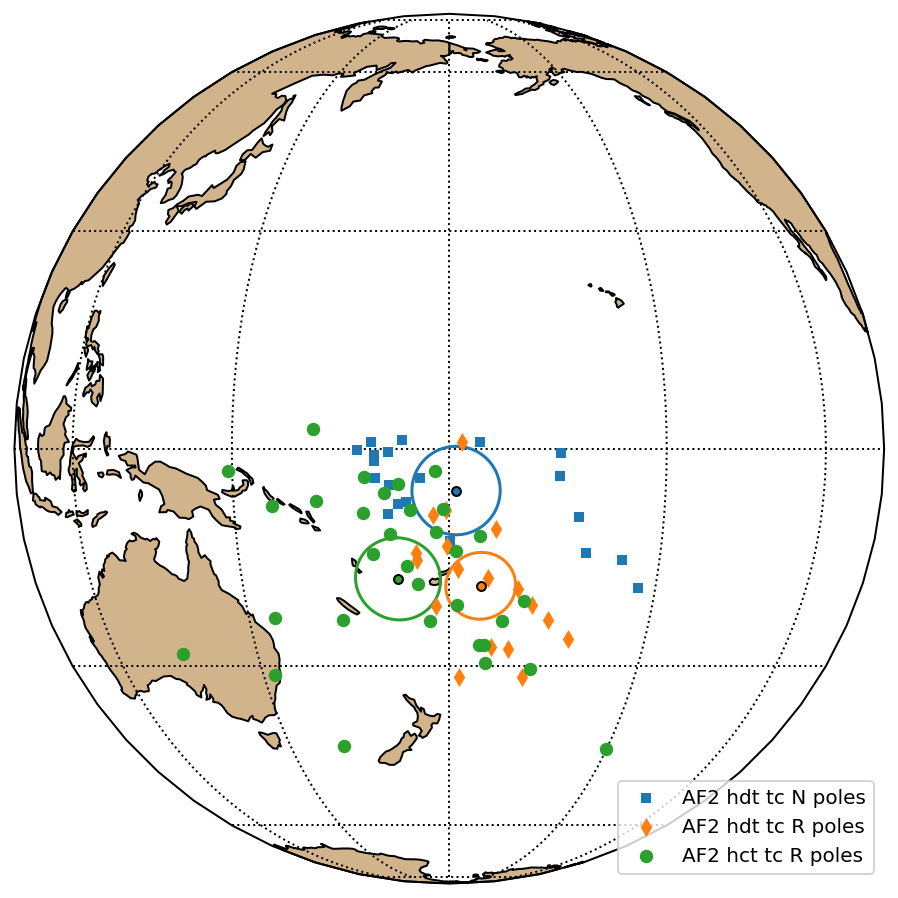

In [41]:
plt.figure(figsize=(5, 5))
map_axis=ipmag.make_orthographic_map(central_longitude=180,central_latitude=0)

ipmag.plot_vgp(map_axis, AF2_spec_hdt_tc_N['vgp_lon'].tolist(), 
               AF2_spec_hdt_tc_N['vgp_lat'].tolist(), 
               markersize = 25, 
               marker = 's', 
               color = 'C0', 
               edge='none', 
               label = 'AF2 hdt tc N poles')

ipmag.plot_vgp(map_axis, AF2_spec_hdt_tc_R['vgp_lon_rev'].tolist(), 
               AF2_spec_hdt_tc_R['vgp_lat_rev'].tolist(), 
               markersize = 45, 
               marker = 'd', 
               color = 'C1', 
               edge='none', 
               label = 'AF2 hdt tc R poles')

ipmag.plot_vgp(map_axis, AF2_spec_hct_tc['vgp_lon_rev'].tolist(), 
               AF2_spec_hct_tc['vgp_lat_rev'].tolist(), 
               markersize = 45, 
               marker = 'o', 
               color = 'C2', 
               edge='none', 
               label = 'AF2 hct tc R poles')

ipmag.plot_pole(map_axis, AF2_spec_hdt_tc_N_mean_pole['dec'], 
                AF2_spec_hdt_tc_N_mean_pole['inc'], 
                AF2_spec_hdt_tc_N_mean_pole['alpha95'], 
                color = 'C0', marker = 'o')
ipmag.plot_pole(map_axis, AF2_spec_hdt_tc_R_mean_pole['dec'], 
                AF2_spec_hdt_tc_R_mean_pole['inc'], 
                AF2_spec_hdt_tc_R_mean_pole['alpha95'], 
                color = 'C1', marker = 'o')
ipmag.plot_pole(map_axis, AF2_spec_hct_tc_mean_pole['dec'], 
                AF2_spec_hct_tc_mean_pole['inc'], 
                AF2_spec_hct_tc_mean_pole['alpha95'], 
                color = 'C2', marker = 'o')

plt.legend(loc=4)
# plt.savefig('../Figures/Pmag/AF2_poles.pdf')
plt.show()

### AFC

- there are only 6 specimens but the hdt components are random but the hct components are reversed, suggesting that hct is chemical remanence and the component is post rip-up which is during Jacobsville deposition (becase these are rip-ups within Jacobsville itself)

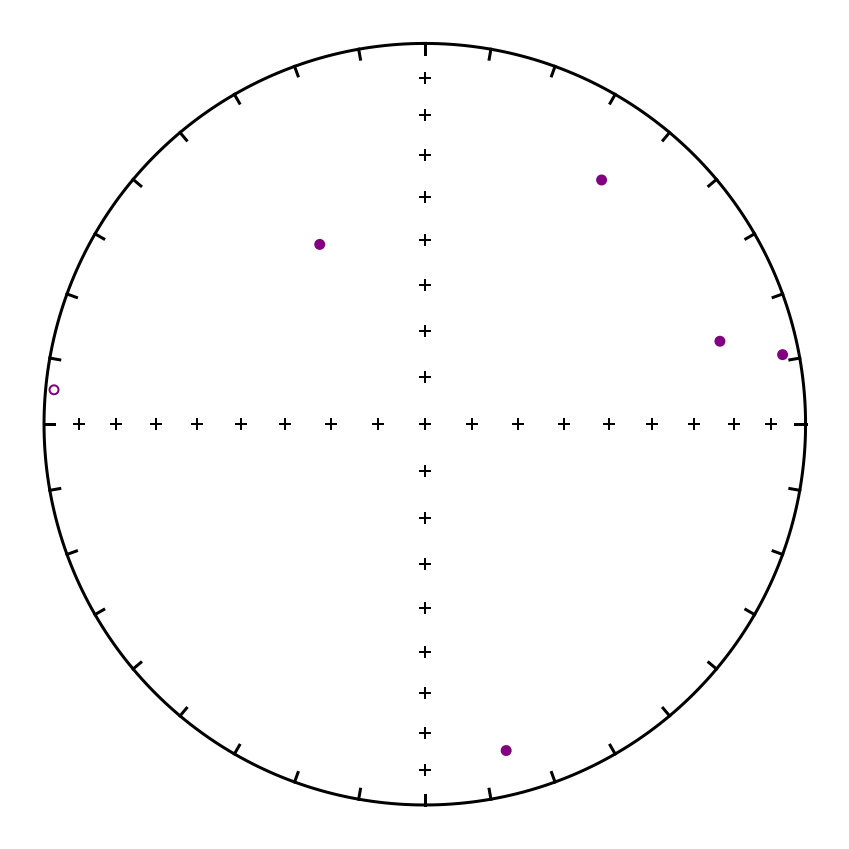

In [42]:
fignum = 1
plt.figure(num=fignum,figsize=(6,6))
ipmag.plot_net(fignum)
ipmag.plot_di(AFC_spec_hdt_tc['dir_dec'].tolist(),AFC_spec_hdt_tc['dir_inc'].tolist(),color='purple',label='AFC hdt tilt corrected')


# plt.legend(loc=4)
# plt.savefig('../Figures/Pmag/AFC_hdt.pdf', bbox_inches='tight')
plt.show()

In [43]:
AFC_hdt_tc_r = ipmag.fisher_mean(AFC_spec_hdt_tc['dir_dec'].tolist(),AFC_spec_hdt_tc['dir_inc'].tolist())['r']
AFC_hdt_tc_n = ipmag.fisher_mean(AFC_spec_hdt_tc['dir_dec'].tolist(),AFC_spec_hdt_tc['dir_inc'].tolist())['n']

ipmag.conglomerate_test_Watson(AFC_hdt_tc_r, AFC_hdt_tc_n)

R = 2.3364047928793688
Ro_95 = 3.85
Ro_99 = 4.48
This population "passes" a conglomerate test as the null hypothesis of randomness cannot be rejected at the 95% confidence level


{'n': 6, 'R': 2.3364047928793688, 'Ro_95': 3.85, 'Ro_99': 4.48}

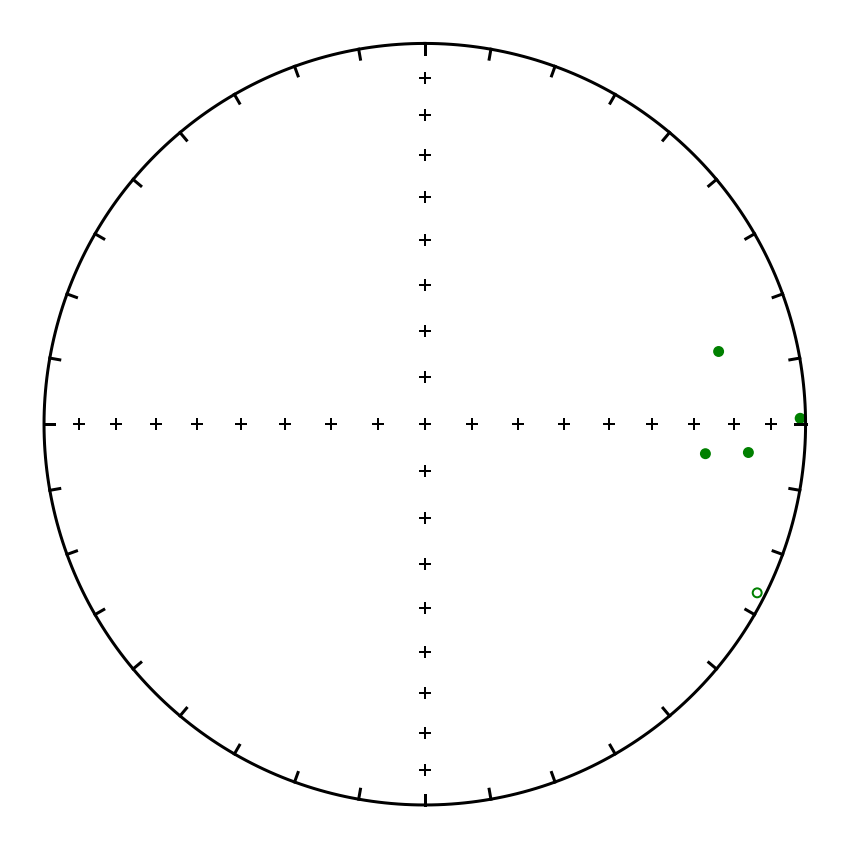

In [44]:
# hct direction of AFC are consistent and agree with having a R direction that was acquired later during the R chron, probably soon after deposition

fignum = 1
plt.figure(num=fignum,figsize=(6,6))
ipmag.plot_net(fignum)
ipmag.plot_di(AFC_spec_hct_tc['dir_dec'].tolist(),AFC_spec_hct_tc['dir_inc'].tolist(),color='green',label='AFC hct tilt corrected')

# plt.legend(loc=4)
# plt.savefig('../Figures/Pmag/AFC_hct.pdf', bbox_inches='tight')
plt.show()

### hdt component of AF1 and AF2

In [45]:
AF_hdt_tc = pd.concat([AF1_spec_hdt_tc, AF2_spec_hdt_tc]).reset_index(drop=1)
AF_hdt_tc_N = AF_hdt_tc[AF_hdt_tc['dir_dec'] > 180]
AF_hdt_tc_R = AF_hdt_tc[AF_hdt_tc['dir_dec'] < 180]
AF_hdt_tc_N_mean = ipmag.fisher_mean(AF_hdt_tc_N['dir_dec'].tolist(), AF_hdt_tc_N['dir_inc'].tolist())
AF_hdt_tc_R_mean = ipmag.fisher_mean(AF_hdt_tc_R['dir_dec'].tolist(), AF_hdt_tc_R['dir_inc'].tolist())

In [46]:
AF_hdt_tc_N_mean_pole = ipmag.fisher_mean(AF_hdt_tc_N['vgp_lon'].tolist(), AF_hdt_tc_N['vgp_lat'].tolist())
AF_hdt_tc_R_mean_pole = ipmag.fisher_mean(AF_hdt_tc_R['vgp_lon_rev'].tolist(), AF_hdt_tc_R['vgp_lat_rev'].tolist())

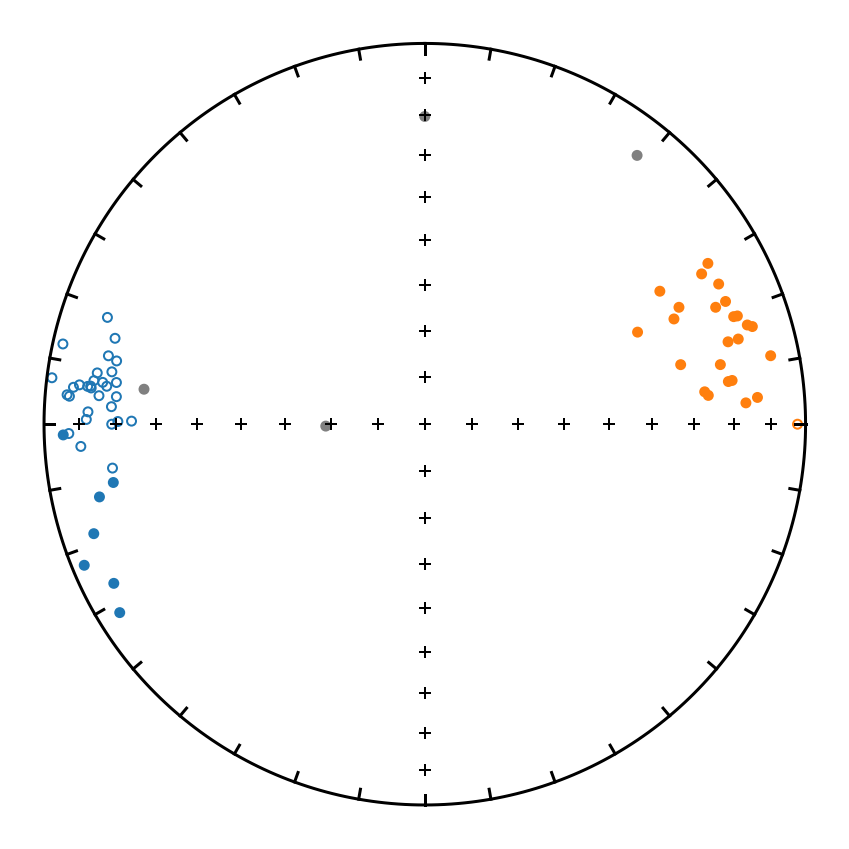

In [47]:
fignum = 1
plt.figure(num=fignum,figsize=(6,6))
ipmag.plot_net(fignum)
ipmag.plot_di(AF_hdt_tc_N['dir_dec'].tolist(),AF_hdt_tc_N['dir_inc'].tolist(),color='C0',label='AF N hdt tilt corrected')
ipmag.plot_di(AF_hdt_tc_R['dir_dec'].tolist(),AF_hdt_tc_R['dir_inc'].tolist(),color='C1',label='AF R hdt tilt corrected')
ipmag.plot_di(AF1_spec_hdt_tc_transition['dir_dec'].tolist(),AF1_spec_hdt_tc_transition['dir_inc'].tolist(),color='gray',label='transitional field directions')
ipmag.plot_di(AF2_spec_hdt_tc_transition['dir_dec'].tolist(),AF2_spec_hdt_tc_transition['dir_inc'].tolist(),color='gray',label='transitional field directions')

# ipmag.plot_di_mean(AF_hdt_tc_N_mean['dec'], AF_hdt_tc_N_mean['inc'], AF_hdt_tc_N_mean['alpha95'], color = 'C0')
# ipmag.plot_di_mean(AF_hdt_tc_R_mean['dec'], AF_hdt_tc_R_mean['inc'], AF_hdt_tc_R_mean['alpha95'], color = 'C1')

# plt.legend(loc=8, fontsize=14)
# plt.savefig('../Figures/Pmag/AF_hdt.pdf', bbox_inches='tight')
plt.show()

<Figure size 360x360 with 0 Axes>

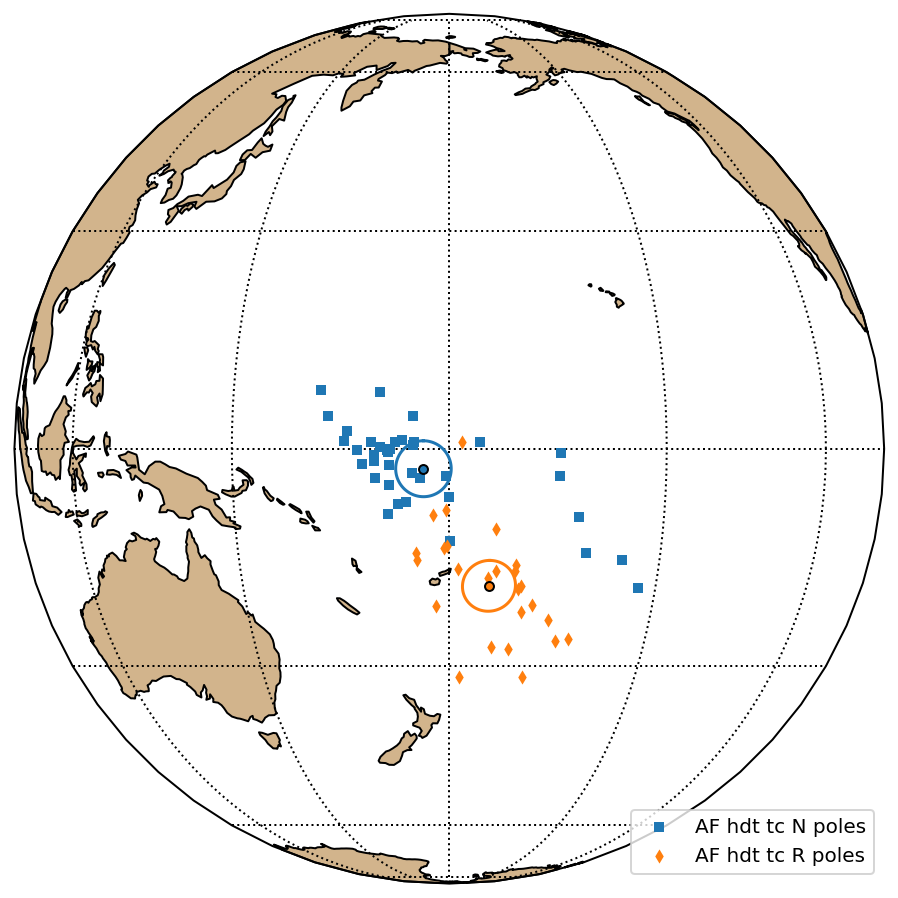

In [48]:
plt.figure(figsize=(5, 5))
map_axis=ipmag.make_orthographic_map(central_longitude=180,central_latitude=0)

ipmag.plot_vgp(map_axis, AF_hdt_tc_N['vgp_lon'].tolist(), 
               AF_hdt_tc_N['vgp_lat'].tolist(), 
               markersize = 25, 
               marker = 's', 
               color = 'C0', 
               edge='none', 
               label = 'AF hdt tc N poles')

ipmag.plot_vgp(map_axis, AF_hdt_tc_R['vgp_lon_rev'].tolist(), 
               AF_hdt_tc_R['vgp_lat_rev'].tolist(), 
               markersize = 25, 
               marker = 'd', 
               color = 'C1', 
               edge='none', 
               label = 'AF hdt tc R poles')

ipmag.plot_pole(map_axis, AF_hdt_tc_N_mean_pole['dec'], 
                AF_hdt_tc_N_mean_pole['inc'], 
                AF_hdt_tc_N_mean_pole['alpha95'], 
                color = 'C0', marker = 'o')
ipmag.plot_pole(map_axis, AF_hdt_tc_R_mean_pole['dec'], 
                AF_hdt_tc_R_mean_pole['inc'], 
                AF_hdt_tc_R_mean_pole['alpha95'], 
                color = 'C1', marker = 'o')

plt.legend(loc=4)
plt.show()

### hct component of AF1 and AF2 and AFC

- It is fascinating that the low temperature (hct) component of AF1 and AF2 do not overlap with PDF but are consistent with a reversed polarity. The hct component is E and is steeper than the reversed polarity, indicating that they are younger and could be recording the squish-corrected DRM!
- Also AFC rip-up clasts were collected near the base of AF2 and the hct component of the AFC sites also showE and down direction, we can combine the hct directions together as well!

In [49]:
# common mean test between hct component of AF1 and AF2 - they do share a common mean, as they pass a common mean test by classification of B
ipmag.common_mean_watson(AF1_spec_hct_tc[['dir_dec' ,'dir_inc']], AF2_spec_hct_tc[['dir_dec' ,'dir_inc']])

Results of Watson V test: 

Watson's V:           5.7
Critical value of V:  6.3
"Pass": Since V is less than Vcrit, the null hypothesis
that the two populations are drawn from distributions
that share a common mean direction can not be rejected.

M&M1990 classification:

Angle between data set means: 9.0
Critical angle for M&M1990:   9.5
The McFadden and McElhinny (1990) classification for
this test is: 'B'


(1, 9.037121707587325, 9.494311918302053)

In [50]:
AF_hct_tc = pd.concat([AF1_spec_hct_tc, AF2_spec_hct_tc, AFC_spec_hct_tc]).reset_index(drop=1)
AF_hct_tc_mean = ipmag.fisher_mean(AF_hct_tc['dir_dec'].tolist(),AF_hct_tc['dir_inc'].tolist())
AF_hct_tc_mean_pole = ipmag.fisher_mean(AF_hct_tc['vgp_lon_rev'].tolist(),AF_hct_tc['vgp_lat_rev'].tolist())

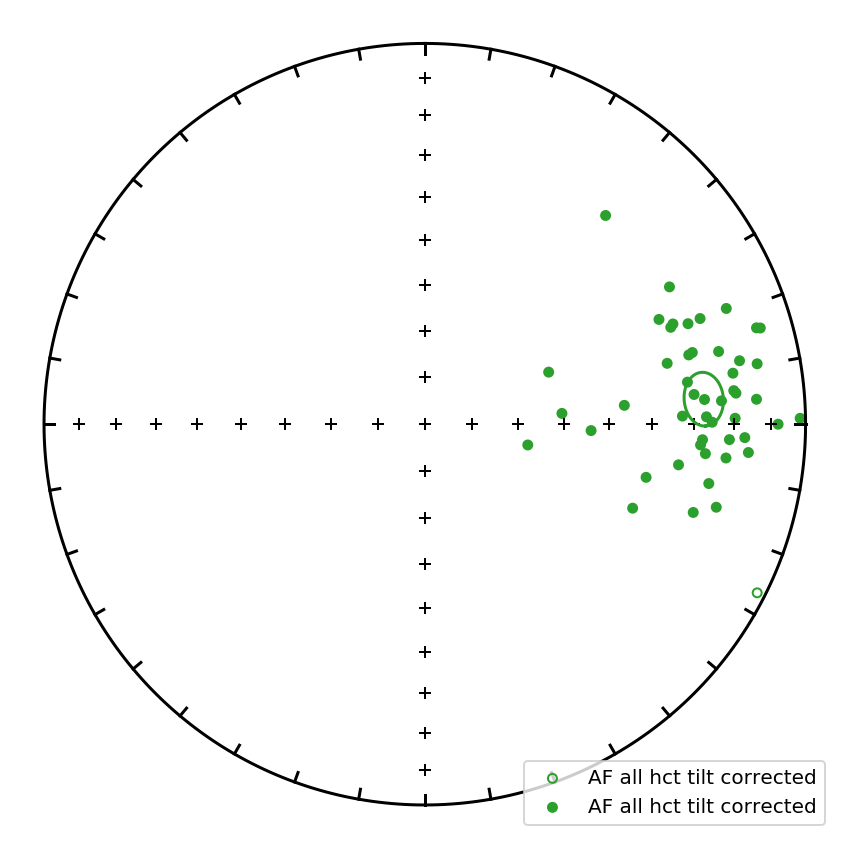

In [51]:
fignum = 1
plt.figure(num=fignum,figsize=(6,6))
ipmag.plot_net(fignum)
ipmag.plot_di(AF_hct_tc['dir_dec'].tolist(),AF_hct_tc['dir_inc'].tolist(),color='C2',label='AF all hct tilt corrected')
ipmag.plot_di_mean(AF_hct_tc_mean['dec'], AF_hct_tc_mean['inc'], AF_hct_tc_mean['alpha95'], color = 'C2')

plt.legend(loc=4)

plt.show()

<Figure size 360x360 with 0 Axes>

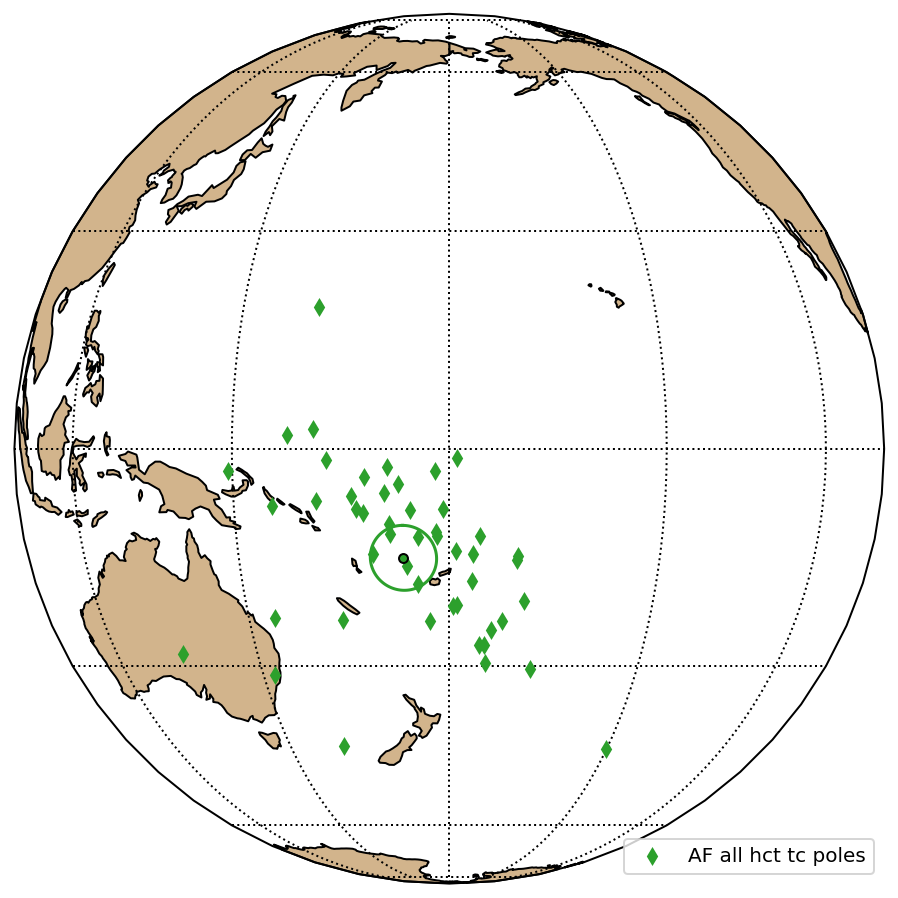

In [52]:
plt.figure(figsize=(5, 5))
map_axis=ipmag.make_orthographic_map(central_longitude=180,central_latitude=0)

ipmag.plot_vgp(map_axis, AF_hct_tc['vgp_lon_rev'].tolist(), 
               AF_hct_tc['vgp_lat_rev'].tolist(), 
               markersize = 45, 
               marker = 'd', 
               color = 'C2', 
               edge='none', 
               label = 'AF all hct tc poles')

ipmag.plot_pole(map_axis, AF_hct_tc_mean_pole['dec'], 
                AF_hct_tc_mean_pole['inc'], 
                AF_hct_tc_mean_pole['alpha95'], 
                color = 'C2', marker = 'o')


plt.legend(loc=4)
plt.show()

### HF7

- this site is the most down section near the bottom of the stratigraphic section that we measured at Hungarian Falls
- The tilt-corrected and geographic directions are N and shallowly up. This direction is at odds with any other direction that we saw at Hungarian Falls. Given that it is very close to an old bridge where heavy construction was underway. We interpret that the remanence of the sandstone at this site was remagnetized by modern bridge work and none of the original remanence is preserved
- therefore we will not include this site into our further analyses

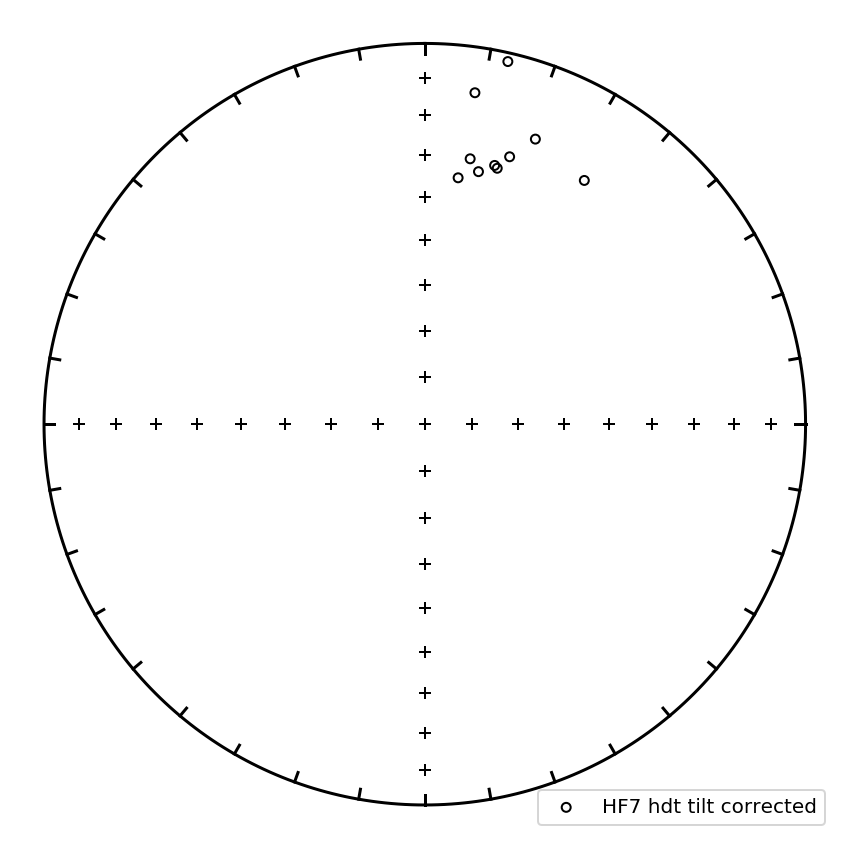

In [53]:
fignum = 1
plt.figure(num=fignum,figsize=(6,6))
ipmag.plot_net(fignum)
ipmag.plot_di(HF7_spec_hdt_tc['dir_dec'].tolist(),HF7_spec_hdt_tc['dir_inc'].tolist(),color='k',label='HF7 hdt tilt corrected')


plt.legend(loc=4)
plt.show()

### HF6

- this is the next site up section from HF7
- 8 specimens were collected from the horizon
- the hdt components are all NE and shallow, with the inclination split between up and down
- however, the hct components are almost all NE and down, consistent with data from Agate Falls whose hct are more downward in inclination

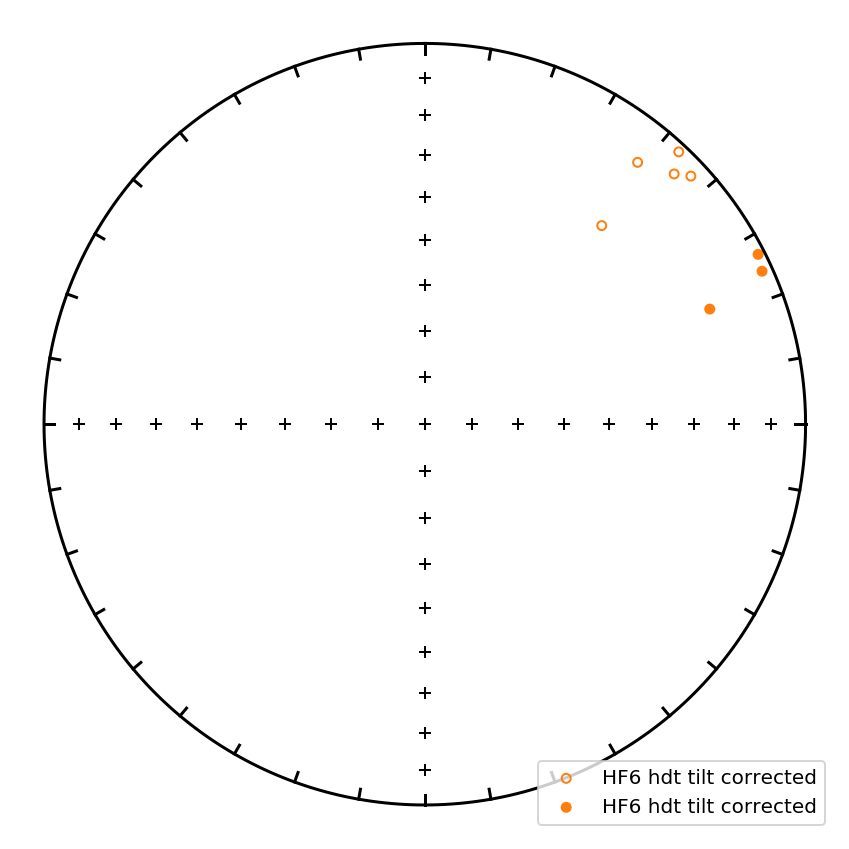

In [54]:
fignum = 1
plt.figure(num=fignum,figsize=(6,6))
ipmag.plot_net(fignum)
ipmag.plot_di(HF6_spec_hdt_tc['dir_dec'].tolist(),HF6_spec_hdt_tc['dir_inc'].tolist(),color='C1',label='HF6 hdt tilt corrected')


plt.legend(loc=4)
plt.show()

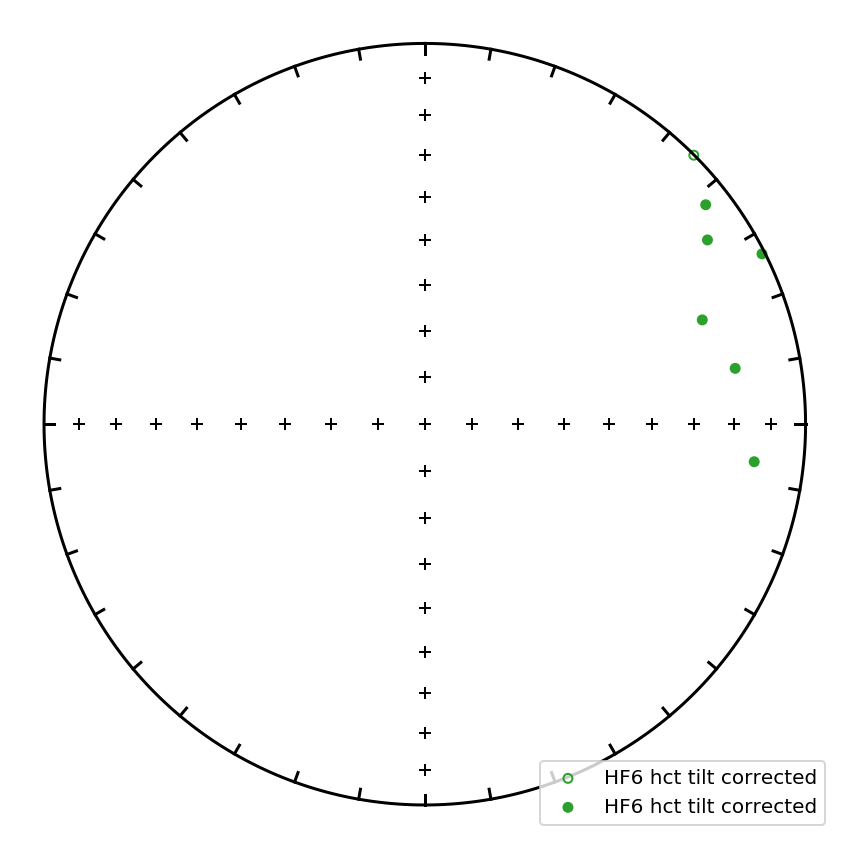

In [55]:
fignum = 1
plt.figure(num=fignum,figsize=(6,6))
ipmag.plot_net(fignum)
ipmag.plot_di(HF6_spec_hct_tc['dir_dec'].tolist(),HF6_spec_hct_tc['dir_inc'].tolist(),color='C2',label='HF6 hct tilt corrected')


plt.legend(loc=4)
plt.show()

### HF5

- only 4 specimen from this horizon
- HF5-7a, the one at the lowest strat height, has a N-like direction than all other specimens which are about 20 cm above 7a. This N-like direction could be real but may not be the same as AF N
- other specimens have E and down (R) direction
- fitted hct directions are R

In [56]:
HF5_spec_hdt_tc_N = HF5_spec_hdt_tc[HF5_spec_hdt_tc['dir_dec']>180]
HF5_spec_hdt_tc_R = HF5_spec_hdt_tc[HF5_spec_hdt_tc['dir_dec']<180]

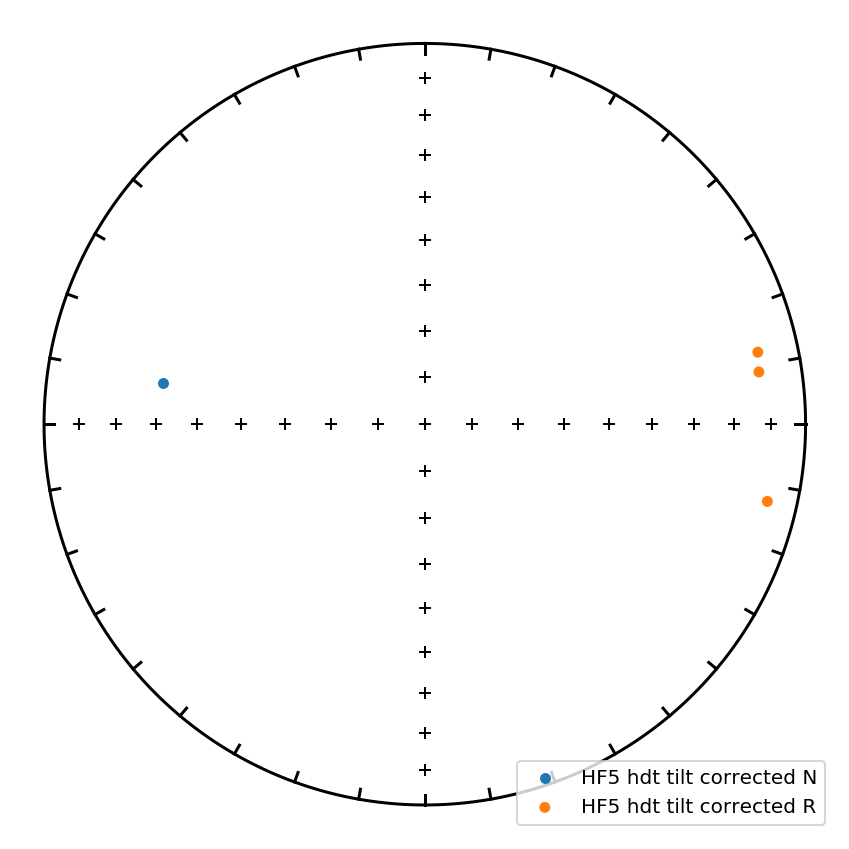

In [57]:
fignum = 1
plt.figure(num=fignum,figsize=(6,6))
ipmag.plot_net(fignum)
ipmag.plot_di(HF5_spec_hdt_tc_N['dir_dec'].tolist(),HF5_spec_hdt_tc_N['dir_inc'].tolist(),color='C0',label='HF5 hdt tilt corrected N')
ipmag.plot_di(HF5_spec_hdt_tc_R['dir_dec'].tolist(),HF5_spec_hdt_tc_R['dir_inc'].tolist(),color='C1',label='HF5 hdt tilt corrected R')


plt.legend(loc=4)
plt.show()

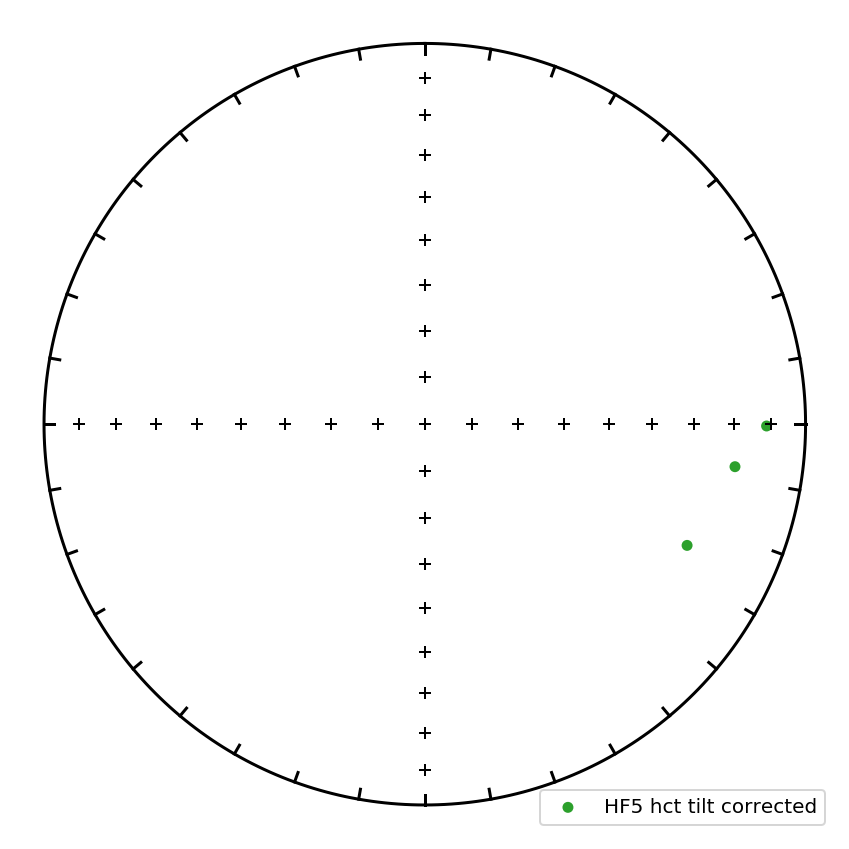

In [58]:
fignum = 1
plt.figure(num=fignum,figsize=(6,6))
ipmag.plot_net(fignum)
ipmag.plot_di(HF5_spec_hct_tc['dir_dec'].tolist(),HF5_spec_hct_tc['dir_inc'].tolist(),color='C2',label='HF5 hct tilt corrected')


plt.legend(loc=4)
plt.show()

### HF4

- 5 specimens from this horizon
- hdt are R direction
- hct are R direction

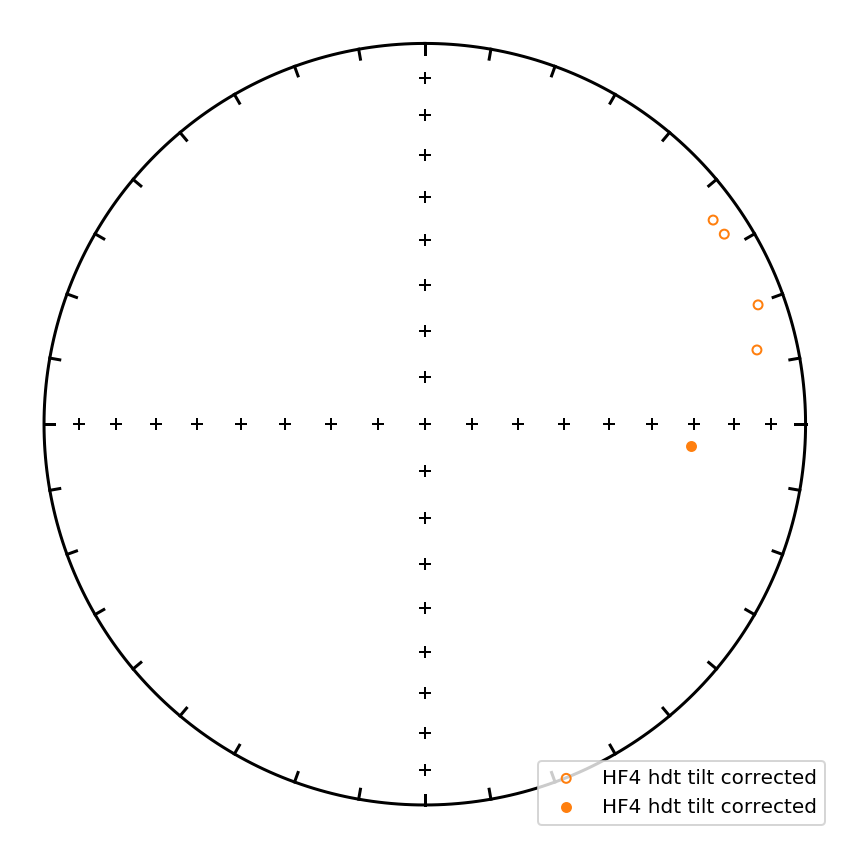

In [59]:
fignum = 1
plt.figure(num=fignum,figsize=(6,6))
ipmag.plot_net(fignum)
ipmag.plot_di(HF4_spec_hdt_tc['dir_dec'].tolist(),HF4_spec_hdt_tc['dir_inc'].tolist(),color='C1',label='HF4 hdt tilt corrected')

plt.legend(loc=4)
plt.show()

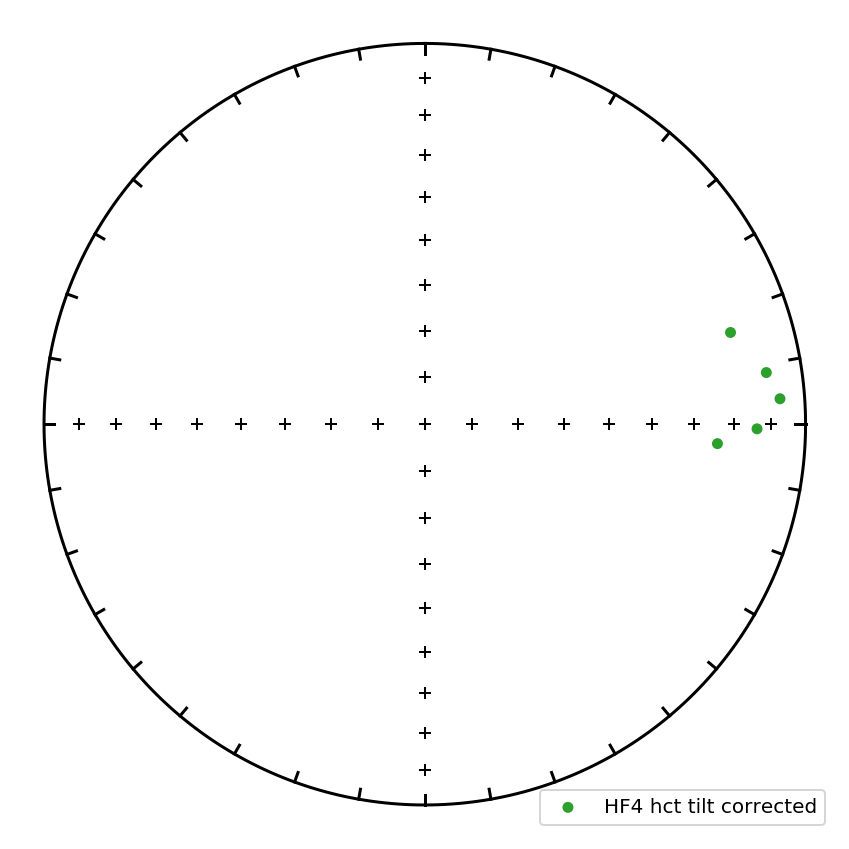

In [60]:
fignum = 1
plt.figure(num=fignum,figsize=(6,6))
ipmag.plot_net(fignum)
ipmag.plot_di(HF4_spec_hct_tc['dir_dec'].tolist(),HF4_spec_hct_tc['dir_inc'].tolist(),color='C2',label='HF4 hct tilt corrected')


plt.legend(loc=4)
plt.show()

### HF3

- 8 specimens from this horizon
- specimen 2a is at same strat level as specimen 4 and 5 but it has opposite directions (R as opposed to all other specimens of N) 
- we interpret that this specimen (2a) is off (perhaps flipped during sampling and may not necesarrily record a true reversal)

In [61]:
HF3_spec_hdt_tc = HF3_spec_hdt_tc[~HF3_spec_hdt_tc['specimen'].str.contains('2')]
HF3_spec_hct_tc = HF3_spec_hct_tc[~HF3_spec_hct_tc['specimen'].str.contains('2')]

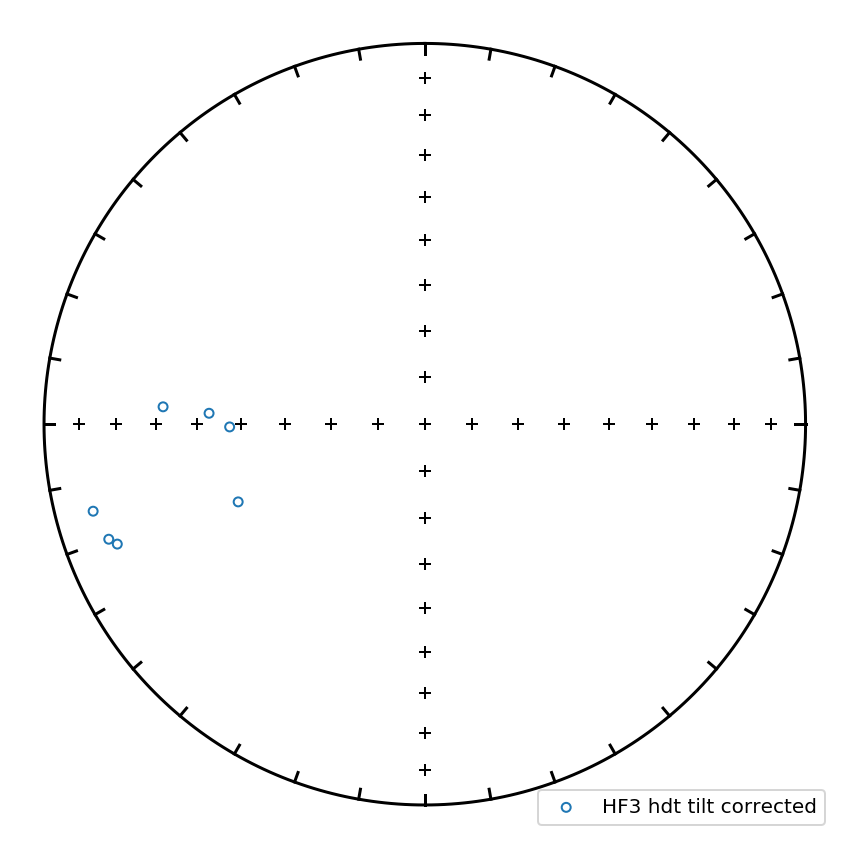

In [62]:
fignum = 1
plt.figure(num=fignum,figsize=(6,6))
ipmag.plot_net(fignum)
ipmag.plot_di(HF3_spec_hdt_tc['dir_dec'].tolist(),HF3_spec_hdt_tc['dir_inc'].tolist(),color='C0',label='HF3 hdt tilt corrected')

plt.legend(loc=4)
plt.show()

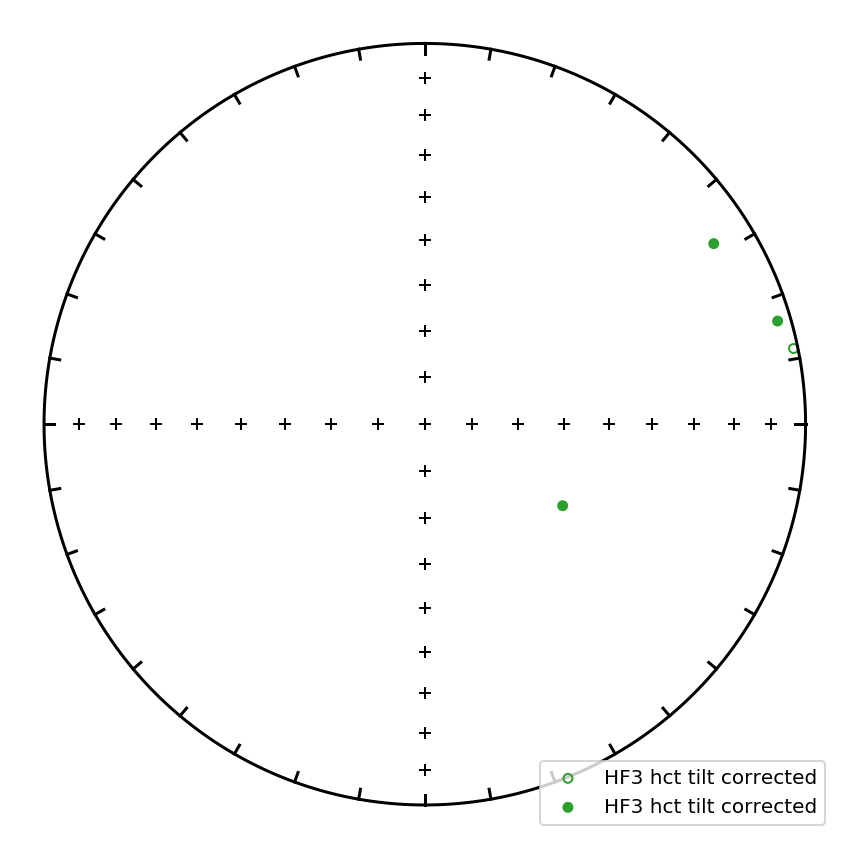

In [63]:
fignum = 1
plt.figure(num=fignum,figsize=(6,6))
ipmag.plot_net(fignum)
ipmag.plot_di(HF3_spec_hct_tc['dir_dec'].tolist(),HF3_spec_hct_tc['dir_inc'].tolist(),color='C2',label='HF3 hct tilt corrected')


plt.legend(loc=4)
plt.show()

### HF2
- 7 specimens
- all reversed directions
- both hdt and hct reversed

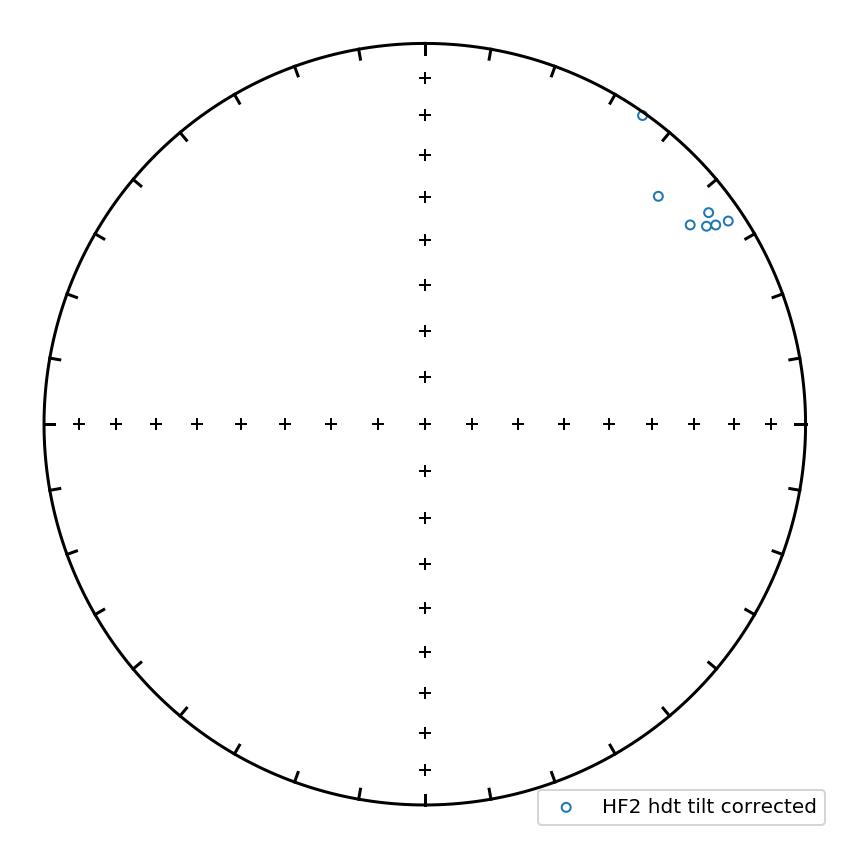

In [64]:
fignum = 1
plt.figure(num=fignum,figsize=(6,6))
ipmag.plot_net(fignum)
ipmag.plot_di(HF2_spec_hdt_tc['dir_dec'].tolist(),HF2_spec_hdt_tc['dir_inc'].tolist(),color='C0',label='HF2 hdt tilt corrected')

plt.legend(loc=4)
plt.show()

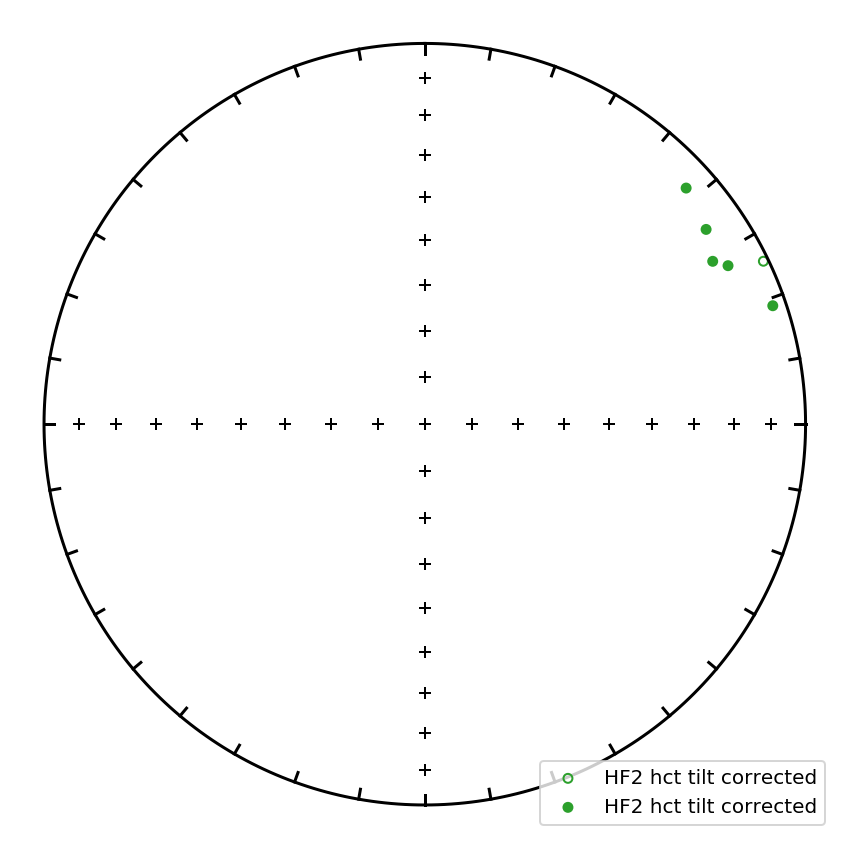

In [65]:
fignum = 1
plt.figure(num=fignum,figsize=(6,6))
ipmag.plot_net(fignum)
ipmag.plot_di(HF2_spec_hct_tc['dir_dec'].tolist(),HF2_spec_hct_tc['dir_inc'].tolist(),color='C2',label='HF2 hct tilt corrected')


plt.legend(loc=4)
plt.show()

### HF1

- top of the section, >100 specimens total collected
- hdt are quite scattered, recording both N and R and transitional in addition
- near the top of the section there is a R-N transition
- if this interpretation is correct, the pmag record is consistent with seds record that there was high energy and quick dumping of material here (given that the transitional field is consistently captured by a bunch of specimens near strat level 101-102)

- specimen 0-30 have inclinations up
- specimen 31-
- specimen 79-89 record a transitional period
- specimen 98, 100, 101 also record odd directions 
- specimen 90, 94, 85 have N direction
- specimen 114 records a N direction that stands alone, could be orientation issue, could be excursion
- specimen 121 - 125 are from the same level as 79-86, confirming odd transitional field like directions

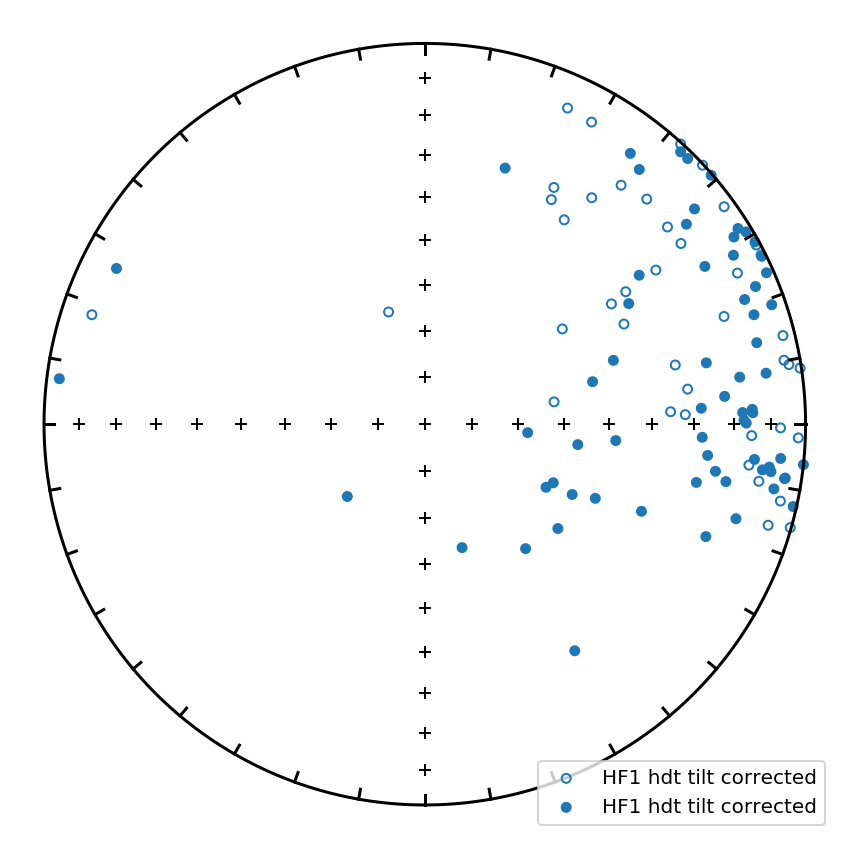

In [66]:
fignum = 1
plt.figure(num=fignum,figsize=(6,6))
ipmag.plot_net(fignum)
ipmag.plot_di(HF1_spec_hdt_tc['dir_dec'].tolist(),HF1_spec_hdt_tc['dir_inc'].tolist(),color='C0',label='HF1 hdt tilt corrected')

plt.legend(loc=4)
plt.show()

In [67]:
HF1_spec_hdt_tc_transitional = HF1_spec_hdt_tc[HF1_spec_hdt_tc['specimen'].str.contains('-79|-80|-81|-82|-83|-84|-85|-86|-87|-88|-89|-91|-95|-98|-100|-101|-102|-107|-121|-122|-123|-124|-125')]
HF1_spec_hdt_tc = HF1_spec_hdt_tc[~HF1_spec_hdt_tc['specimen'].str.contains('-79|-80|-81|-82|-83|-84|-85|-86|-87|-88|-89|-91|-95|-98|-100|-101|-102|-107|-121|-122|-123|-124|-125')]
HF1_spec_hdt_tc_N = HF1_spec_hdt_tc[HF1_spec_hdt_tc['dir_dec'] > 180]
HF1_spec_hdt_tc_R = HF1_spec_hdt_tc[HF1_spec_hdt_tc['dir_dec'] < 180]

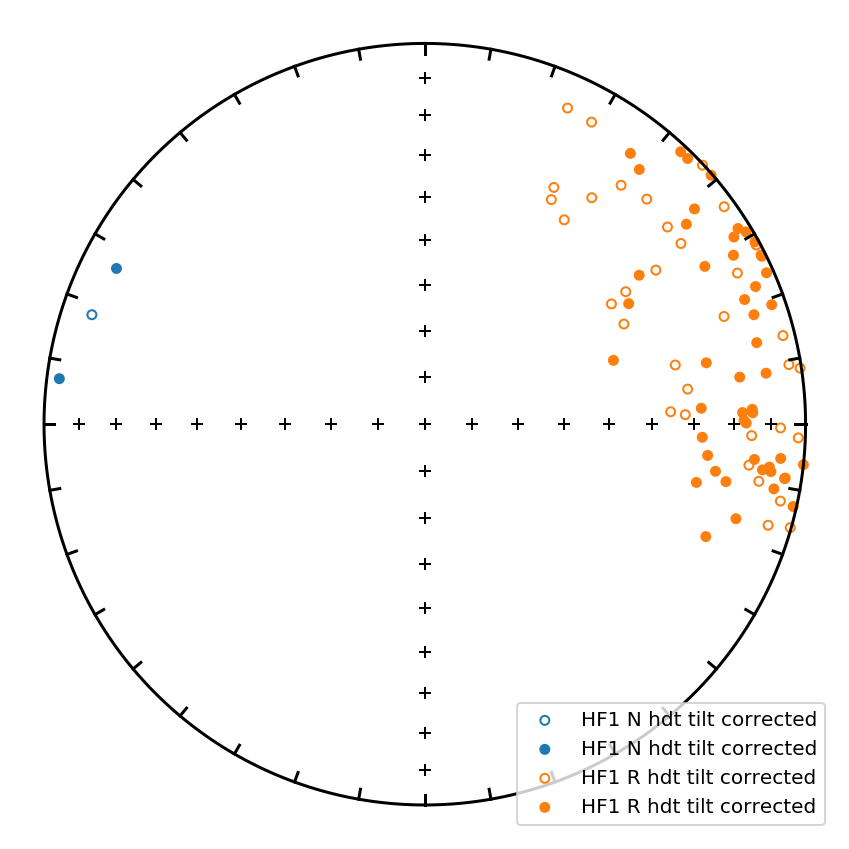

In [68]:
fignum = 1
plt.figure(num=fignum,figsize=(6,6))
ipmag.plot_net(fignum)
ipmag.plot_di(HF1_spec_hdt_tc_N['dir_dec'].tolist(),HF1_spec_hdt_tc_N['dir_inc'].tolist(),color='C0',label='HF1 N hdt tilt corrected')
ipmag.plot_di(HF1_spec_hdt_tc_R['dir_dec'].tolist(),HF1_spec_hdt_tc_R['dir_inc'].tolist(),color='C1',label='HF1 R hdt tilt corrected')

plt.legend(loc=4)
plt.show()

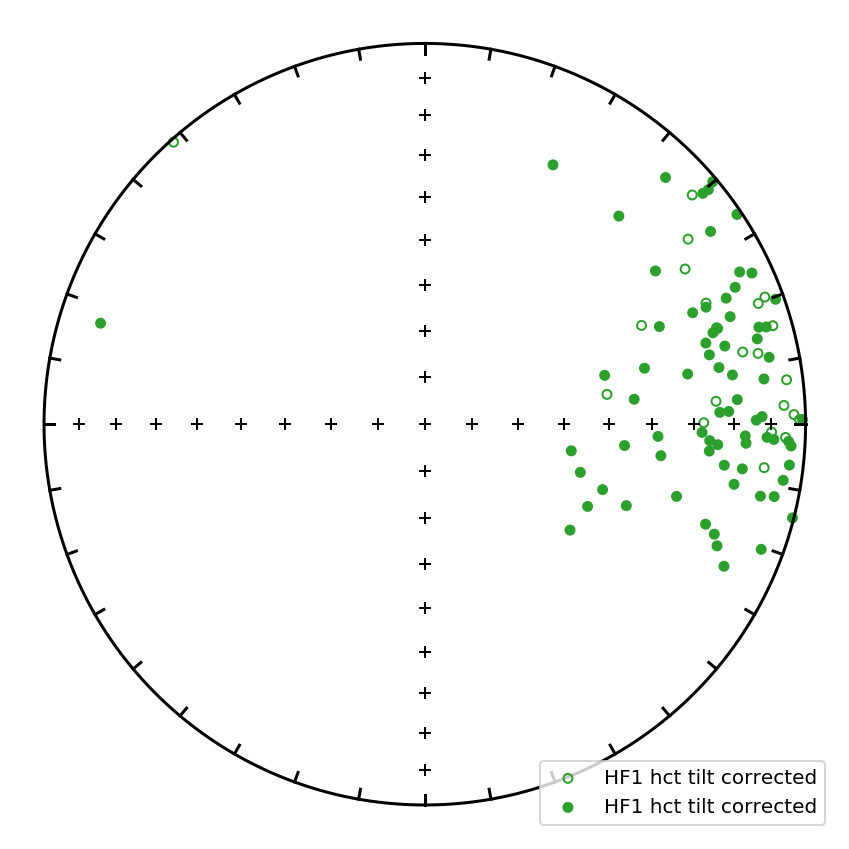

In [69]:
fignum = 1
plt.figure(num=fignum,figsize=(6,6))
ipmag.plot_net(fignum)
ipmag.plot_di(HF1_spec_hct_tc['dir_dec'].tolist(),HF1_spec_hct_tc['dir_inc'].tolist(),color='C2',label='HF1 hct tilt corrected')

plt.legend(loc=4)
plt.show()

In [70]:
HF1_spec_hct_R_tc = HF1_spec_hct_tc[HF1_spec_hct_tc['dir_dec']<180]

### HFC

- random hdt component and consistent hct component
- hct component all R direction and 

- some specimen might even have hct component that pass a conglomerate test?!

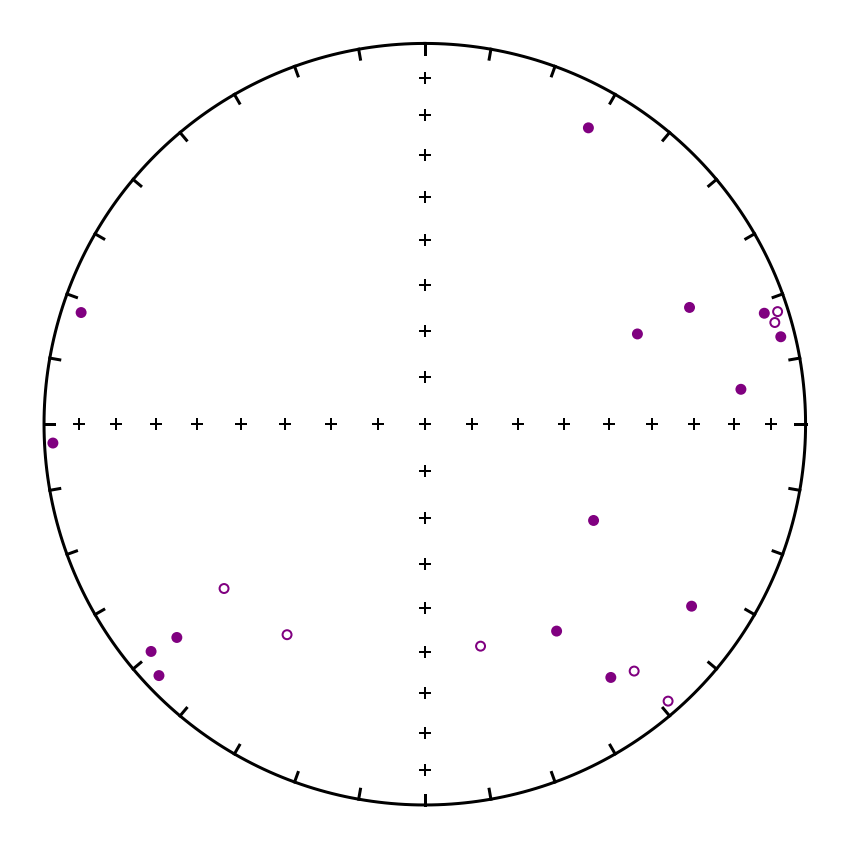

In [71]:
fignum = 1
plt.figure(num=fignum,figsize=(6,6))
ipmag.plot_net(fignum)
ipmag.plot_di(HFC_spec_hdt_tc['dir_dec'].tolist(),HFC_spec_hdt_tc['dir_inc'].tolist(),color='purple',label='HFC hdt tilt corrected')

# plt.legend(loc=4)
# plt.savefig('../Figures/Pmag/HFC_hdt.pdf', bbox_inches='tight')
plt.show()

In [72]:
HFC_hdt_tc_r = ipmag.fisher_mean(HFC_spec_hdt_tc['dir_dec'].tolist(),HFC_spec_hdt_tc['dir_inc'].tolist())['r']
HFC_hdt_tc_n = ipmag.fisher_mean(HFC_spec_hdt_tc['dir_dec'].tolist(),HFC_spec_hdt_tc['dir_inc'].tolist())['n']

ipmag.conglomerate_test_Watson(HFC_hdt_tc_r, HFC_hdt_tc_n)

R = 7.429118191103537
Ro_95 = 7.570336848516056
Ro_99 = 9.121220678542246
This population "passes" a conglomerate test as the null hypothesis of randomness cannot be rejected at the 95% confidence level


{'n': 22,
 'R': 7.429118191103537,
 'Ro_95': 7.570336848516056,
 'Ro_99': 9.121220678542246}

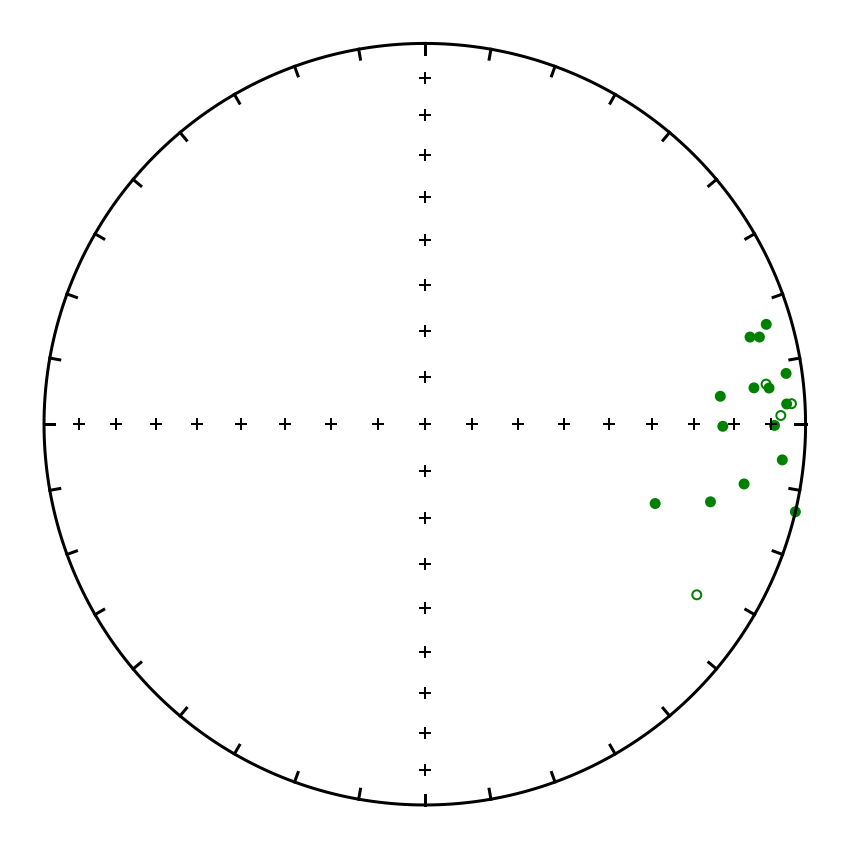

In [73]:
# hct direction of AFC are consistent and agree with having a R direction that was acquired later during the R chron, probably soon after deposition

fignum = 1
plt.figure(num=fignum,figsize=(6,6))
ipmag.plot_net(fignum)
ipmag.plot_di(HFC_spec_hct_tc['dir_dec'].tolist(),HFC_spec_hct_tc['dir_inc'].tolist(),color='green',label='HFC hct tilt corrected')


# plt.legend(loc=4)
# plt.savefig('../Figures/Pmag/HFC_hct.pdf', bbox_inches='tight')

plt.show()

### hdt component of all HF sites  

In [74]:
HF_hdt_tc = pd.concat([HF6_spec_hdt_tc, HF5_spec_hdt_tc, HF4_spec_hdt_tc, HF3_spec_hdt_tc, HF2_spec_hdt_tc, HF1_spec_hdt_tc]).reset_index(drop=1)
HF_hdt_tc_N = HF_hdt_tc[HF_hdt_tc['dir_dec'] > 180]
HF_hdt_tc_R = HF_hdt_tc[HF_hdt_tc['dir_dec'] < 180]
HF_hdt_tc_N_mean = ipmag.fisher_mean(HF_hdt_tc_N['dir_dec'].tolist(), HF_hdt_tc_N['dir_inc'].tolist())
HF_hdt_tc_R_mean = ipmag.fisher_mean(HF_hdt_tc_R['dir_dec'].tolist(), HF_hdt_tc_R['dir_inc'].tolist())

In [75]:
HF_hdt_tc_N_mean_pole = ipmag.fisher_mean(HF_hdt_tc_N['vgp_lon'].tolist(), HF_hdt_tc_N['vgp_lat'].tolist())
HF_hdt_tc_R_mean_pole = ipmag.fisher_mean(HF_hdt_tc_R['vgp_lon_rev'].tolist(), HF_hdt_tc_R['vgp_lat_rev'].tolist())

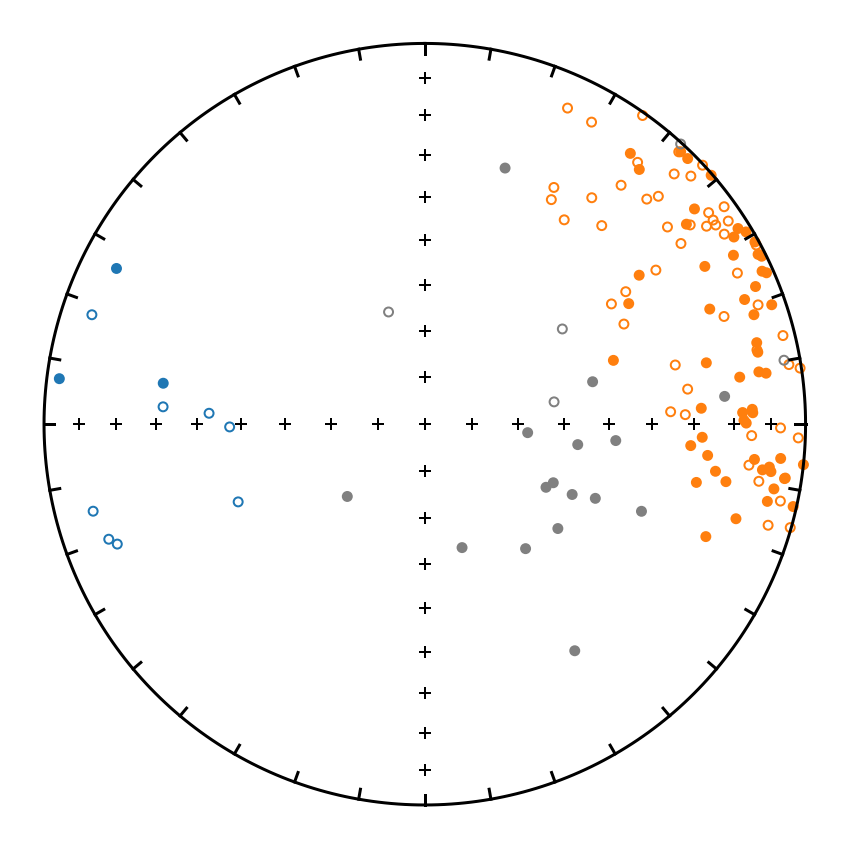

In [76]:
fignum = 1
plt.figure(num=fignum,figsize=(6,6))
ipmag.plot_net(fignum)
ipmag.plot_di(HF_hdt_tc_N['dir_dec'].tolist(),HF_hdt_tc_N['dir_inc'].tolist(),color='C0',label='HF N hdt tilt corrected')
ipmag.plot_di(HF_hdt_tc_R['dir_dec'].tolist(),HF_hdt_tc_R['dir_inc'].tolist(),color='C1',label='HF R hdt tilt corrected')
# ipmag.plot_di_mean(HF_hdt_tc_N_mean['dec'], HF_hdt_tc_N_mean['inc'], HF_hdt_tc_N_mean['alpha95'], color = 'C0')
# ipmag.plot_di_mean(HF_hdt_tc_R_mean['dec'], HF_hdt_tc_R_mean['inc'], HF_hdt_tc_R_mean['alpha95'], color = 'C1')
ipmag.plot_di(HF1_spec_hdt_tc_transitional['dir_dec'].tolist(),HF1_spec_hdt_tc_transitional['dir_inc'].tolist(),
              color='gray', label='HF transitional fields')


# plt.legend(loc=8, fontsize=14)
# plt.savefig('../Figures/Pmag/HF_hdt.pdf', bbox_inches='tight')

plt.show()

<Figure size 360x360 with 0 Axes>

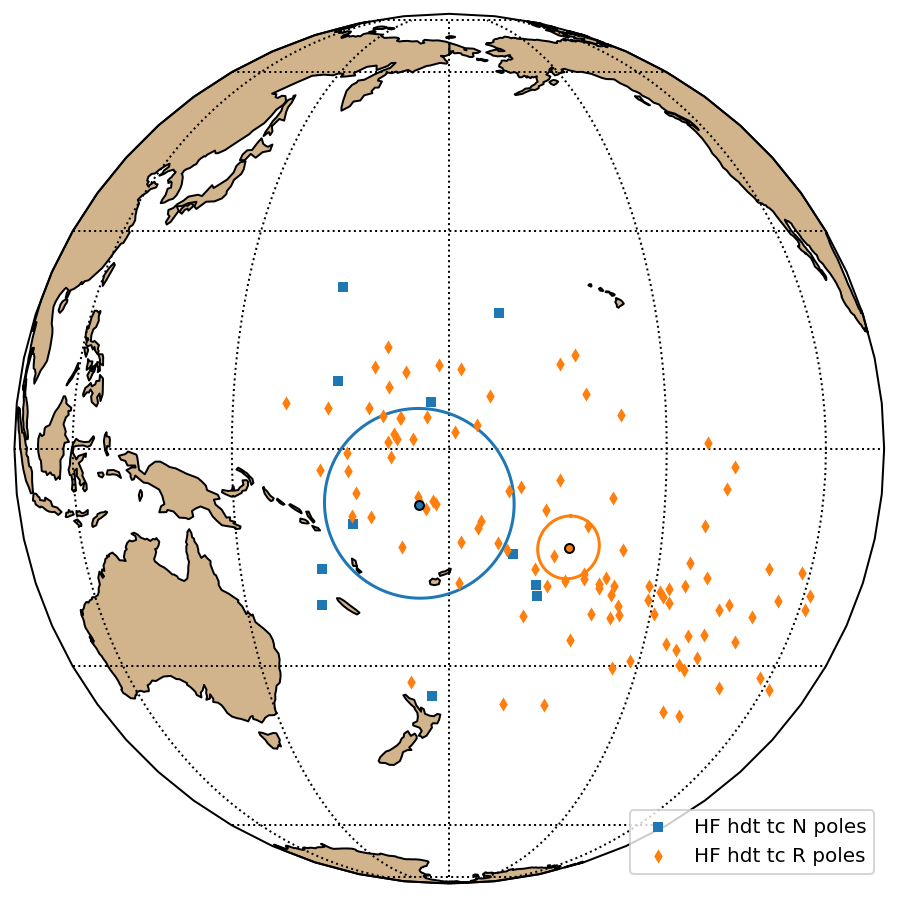

In [77]:
plt.figure(figsize=(5, 5))
map_axis=ipmag.make_orthographic_map(central_longitude=180,central_latitude=0)

ipmag.plot_vgp(map_axis, HF_hdt_tc_N['vgp_lon'].tolist(), 
               HF_hdt_tc_N['vgp_lat'].tolist(), 
               markersize = 25, 
               marker = 's', 
               color = 'C0', 
               edge='none', 
               label = 'HF hdt tc N poles')

ipmag.plot_vgp(map_axis, HF_hdt_tc_R['vgp_lon_rev'].tolist(), 
               HF_hdt_tc_R['vgp_lat_rev'].tolist(), 
               markersize = 25, 
               marker = 'd', 
               color = 'C1', 
               edge='none', 
               label = 'HF hdt tc R poles')

ipmag.plot_pole(map_axis, HF_hdt_tc_N_mean_pole['dec'], 
                HF_hdt_tc_N_mean_pole['inc'], 
                HF_hdt_tc_N_mean_pole['alpha95'], 
                color = 'C0', marker = 'o')
ipmag.plot_pole(map_axis, HF_hdt_tc_R_mean_pole['dec'], 
                HF_hdt_tc_R_mean_pole['inc'], 
                HF_hdt_tc_R_mean_pole['alpha95'], 
                color = 'C1', marker = 'o')

plt.legend(loc=4)
plt.show()

### JK2

- both hdt and hct are E and R direction with shallow inc

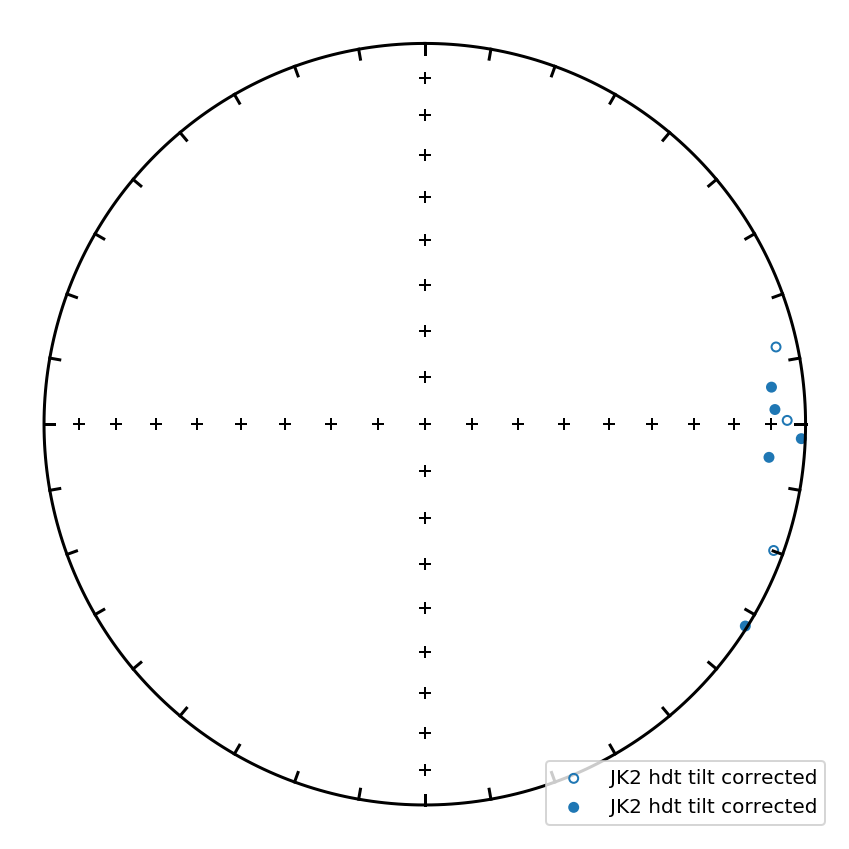

In [78]:
fignum = 1
plt.figure(num=fignum,figsize=(6,6))
ipmag.plot_net(fignum)
ipmag.plot_di(JK2_spec_hdt_tc['dir_dec'].tolist(),JK2_spec_hdt_tc['dir_inc'].tolist(),color='C0',label='JK2 hdt tilt corrected')

plt.legend(loc=4)
plt.show()

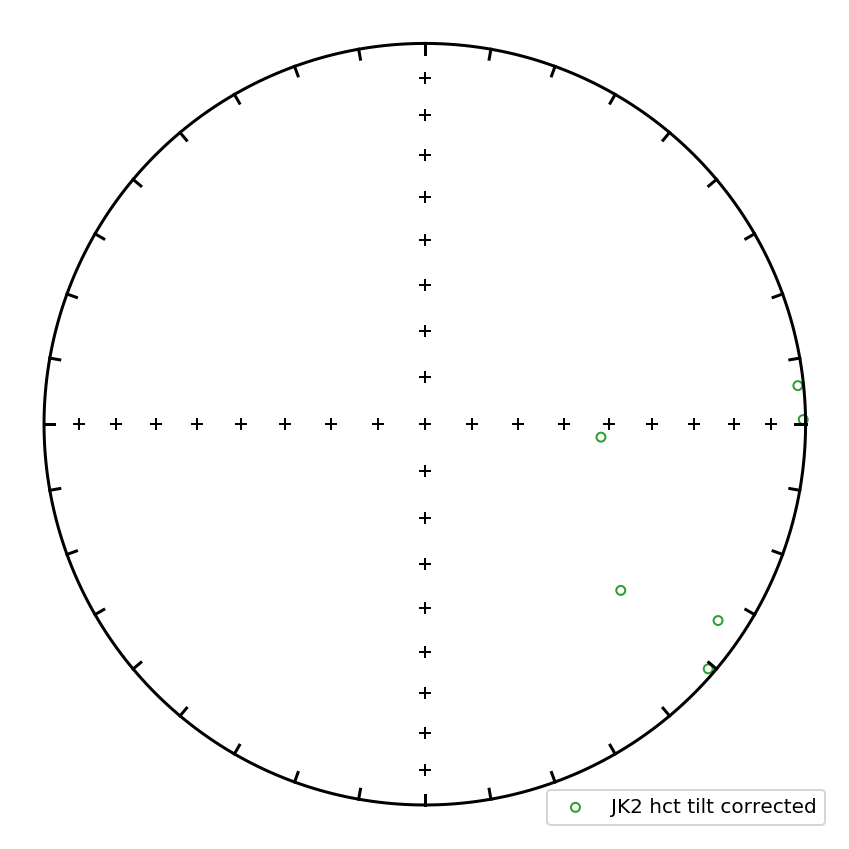

In [79]:
fignum = 1
plt.figure(num=fignum,figsize=(6,6))
ipmag.plot_net(fignum)
ipmag.plot_di(JK2_spec_hct_tc['dir_dec'].tolist(),JK2_spec_hct_tc['dir_inc'].tolist(),color='C2',label='JK2 hct tilt corrected')

plt.legend(loc=4)
plt.show()

### JK3 
- both hdt and hct are E and R direction with shallow inc
- on difference between JK3 and JK2 is that JK3 exclusively have down inclination whereas JK2 has both up and down
- the problem is that they might be very adjacent but different layers (half meter-ish) and the pmag do reflect field moving within PSV and are not problems with bed tilt control

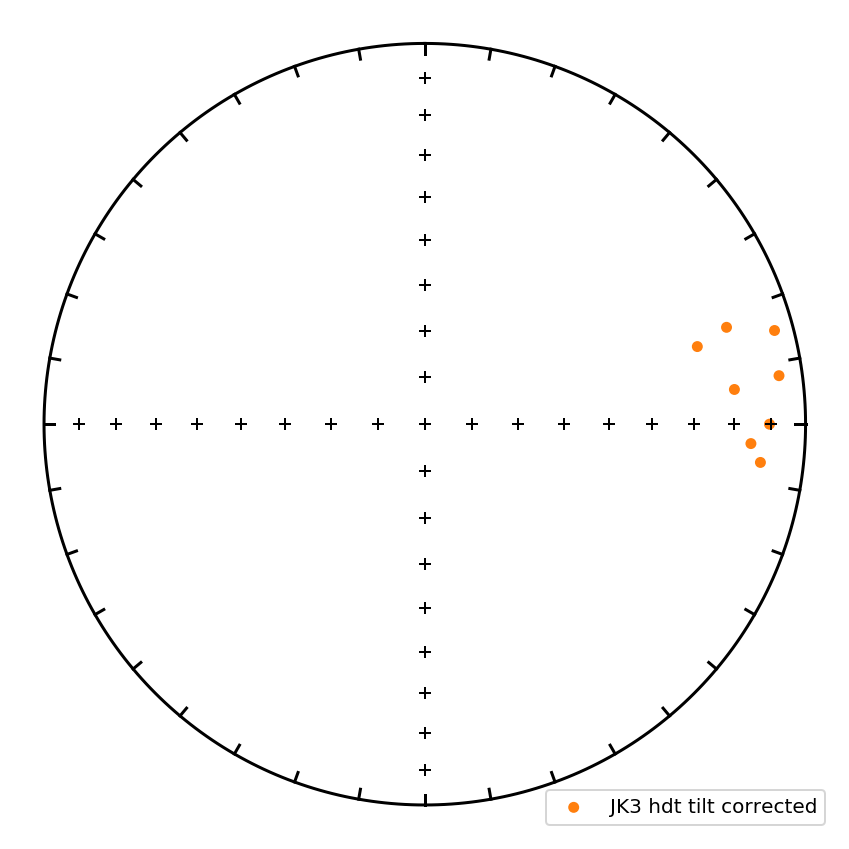

In [80]:
fignum = 1
plt.figure(num=fignum,figsize=(6,6))
ipmag.plot_net(fignum)
ipmag.plot_di(JK3_spec_hdt_tc['dir_dec'].tolist(),JK3_spec_hdt_tc['dir_inc'].tolist(),color='C1',label='JK3 hdt tilt corrected')

plt.legend(loc=4)
plt.show()

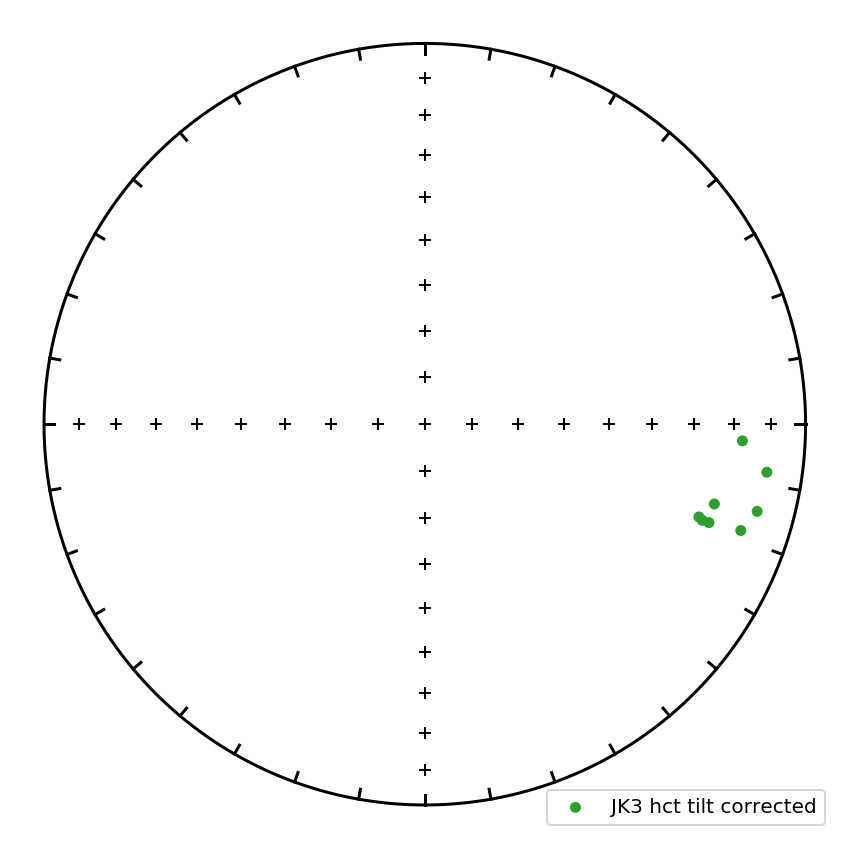

In [81]:
fignum = 1
plt.figure(num=fignum,figsize=(6,6))
ipmag.plot_net(fignum)
ipmag.plot_di(JK3_spec_hct_tc['dir_dec'].tolist(),JK3_spec_hct_tc['dir_inc'].tolist(),color='C2',label='JK3 hct tilt corrected')

plt.legend(loc=4)
plt.show()

### hdt component of JK sites

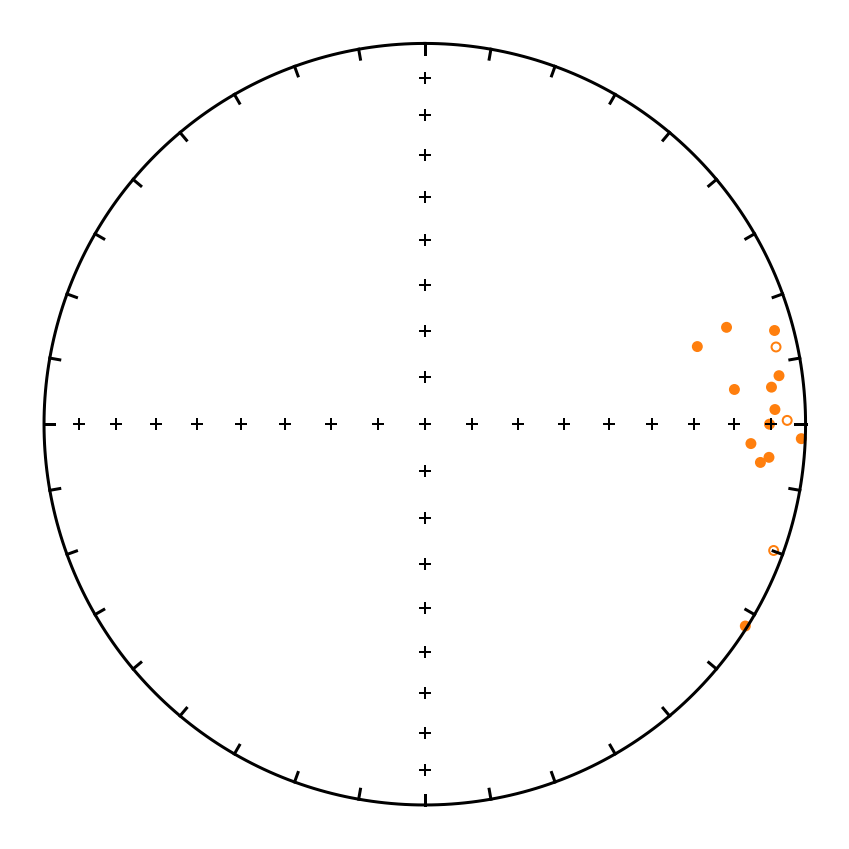

In [82]:
fignum = 1
plt.figure(num=fignum,figsize=(6,6))
ipmag.plot_net(fignum)
ipmag.plot_di(JK2_spec_hdt_tc['dir_dec'].tolist(),JK2_spec_hdt_tc['dir_inc'].tolist(),color='C1',label='Hammel Creek high-temp component')
ipmag.plot_di(JK3_spec_hdt_tc['dir_dec'].tolist(),JK3_spec_hdt_tc['dir_inc'].tolist(),color='C1')

# plt.legend(loc=8, fontsize=14)
# plt.savefig('../Figures/Pmag/JK_hdt.pdf', bbox_inches='tight')

plt.show()

### NW1 and NW2

We obtained two sites from the Natural Wall ravine. One section NW1, is along the folded natural wall near the Keweenaw Fault toward a direction away from the fault. The specimens collected from this site are mostly steeply dipping in fine to very fine sandstone with red pigmentary color caused by hematite. The other section , NW2, is slightly farther from the fault but in the general natural wall section, but is flat lying and of very fine to silt size. We are not sure about the connection between the two sites but it is likely that NW2 is stratigraphiclly higher than most of the specimens collected in the NW1 section, given that NW2 mostly is flat. 

Interesting that NW1 is of very different polarity than NW2. Overall both sites have more scattered directions than the AF1 section. Inded the grain size at NW sites are larger -> fine to lower med sand sometimes. And the demagentization results is more noisy than the AF section.

In [83]:
NW1_spec_hdt_tc_mean = ipmag.fisher_mean(NW1_spec_hdt_tc['dir_dec'].tolist(), NW1_spec_hdt_tc['dir_inc'].tolist())
NW2_spec_hdt_tc_mean = ipmag.fisher_mean(NW2_spec_hdt_tc['dir_dec'].tolist(), NW2_spec_hdt_tc['dir_inc'].tolist())

NW1_spec_hdt_tc_mean_pole = ipmag.fisher_mean(NW1_spec_hdt_tc['vgp_lon_rev'].tolist(), NW1_spec_hdt_tc['vgp_lat_rev'].tolist())
NW2_spec_hdt_tc_mean_pole = ipmag.fisher_mean(NW2_spec_hdt_tc['vgp_lon'].tolist(), NW2_spec_hdt_tc['vgp_lat'].tolist())

In [84]:
NW1_spec_hdt_tc_mean

{'dec': 123.36055218740066,
 'inc': 22.14957352656957,
 'n': 10,
 'r': 9.104050496544959,
 'k': 10.045208982530143,
 'alpha95': 16.02693127660341,
 'csd': 25.556744472227386}

In [85]:
NW2_spec_hdt_tc_mean

{'dec': 242.35212246061025,
 'inc': -7.243031258159614,
 'n': 15,
 'r': 13.349618397796275,
 'k': 8.482886613196643,
 'alpha95': 13.950926160647303,
 'csd': 27.810781172645253}

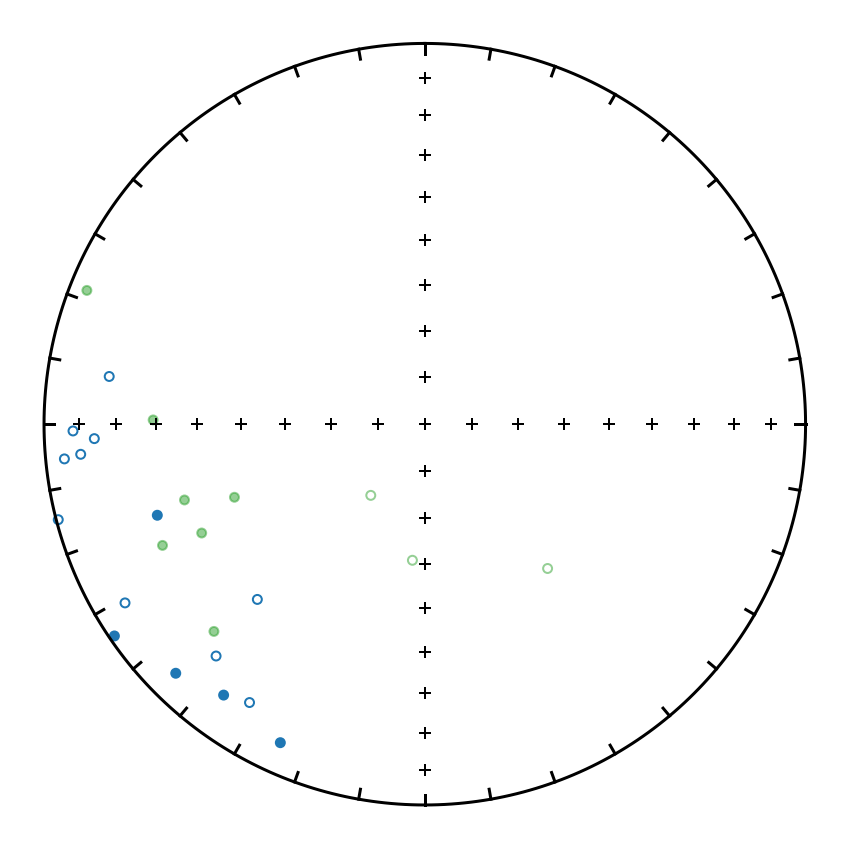

In [86]:
fignum = 1
plt.figure(num=fignum,figsize=(6,6))
ipmag.plot_net(fignum)
ipmag.plot_di(NW1_spec_hdt_gc['dir_dec'].tolist(),NW1_spec_hdt_gc['dir_inc'].tolist(),color='C2',alpha=0.5,label='NW1 directions')
ipmag.plot_di(NW2_spec_hdt_gc['dir_dec'].tolist(),NW2_spec_hdt_gc['dir_inc'].tolist(),color='C0',label='NW2 directions')
# ipmag.plot_di_mean(NW1_spec_hdt_tc_mean['dec'], NW1_spec_hdt_tc_mean['inc'], NW1_spec_hdt_tc_mean['alpha95'], color = 'C1')
# ipmag.plot_di_mean(NW2_spec_hdt_tc_mean['dec'], NW2_spec_hdt_tc_mean['inc'], NW2_spec_hdt_tc_mean['alpha95'], color = 'C0')

plt.show()

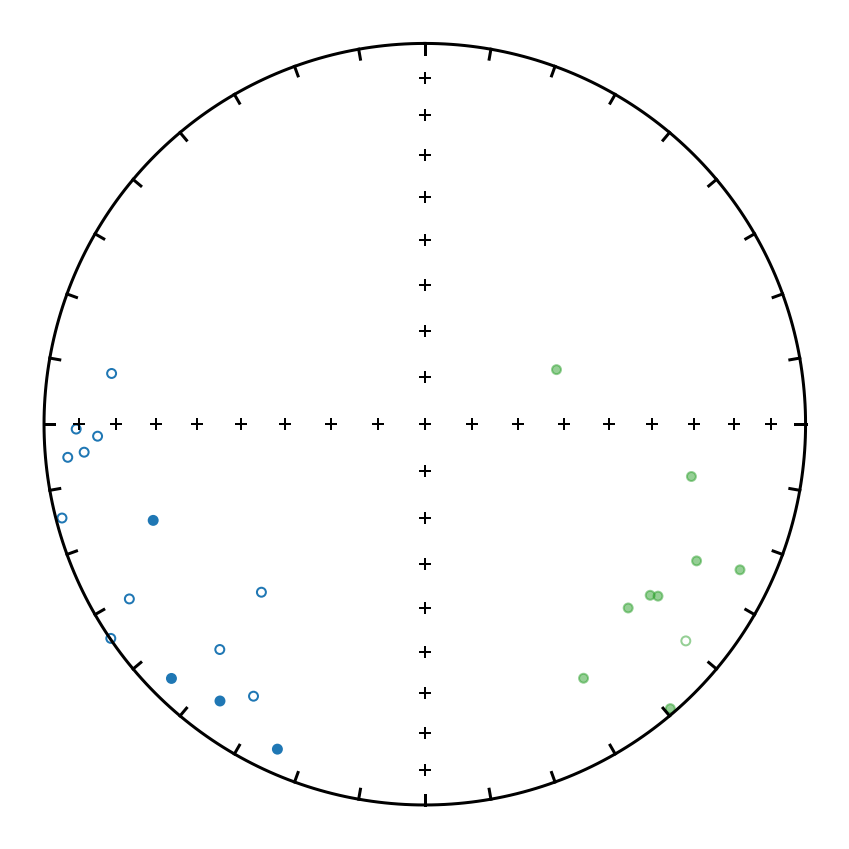

In [87]:
fignum = 1
plt.figure(num=fignum,figsize=(6,6))
ipmag.plot_net(fignum)
ipmag.plot_di(NW1_spec_hdt_tc['dir_dec'].tolist(),NW1_spec_hdt_tc['dir_inc'].tolist(),color='C2',alpha=0.5,label='NW1 directions')
ipmag.plot_di(NW2_spec_hdt_tc['dir_dec'].tolist(),NW2_spec_hdt_tc['dir_inc'].tolist(),color='C0',label='NW2 directions')
# ipmag.plot_di_mean(NW1_spec_hdt_tc_mean['dec'], NW1_spec_hdt_tc_mean['inc'], NW1_spec_hdt_tc_mean['alpha95'], color = 'C1')
# ipmag.plot_di_mean(NW2_spec_hdt_tc_mean['dec'], NW2_spec_hdt_tc_mean['inc'], NW2_spec_hdt_tc_mean['alpha95'], color = 'C0')



# plt.legend(loc=4)
# plt.title('drastically different directions captured at Natural Wall')
# plt.savefig('../Figures/Pmag/NW_hdt.pdf', bbox_inches='tight')
plt.show()

In [88]:
NW_sample_bedding_data = Jacobsville_sample_data[Jacobsville_sample_data['site'].str.contains('NW1|NW2')][['sample', 'bed_dip', 'bed_dip_direction']]

NW_sample_bedding_data.head()

sample  bed_dip  bed_dip_direction
347  NW1-1a    112.0               97.0
348  NW1-2a    112.0               97.0
349  NW1-3a    121.0               96.0
350  NW1-4a    121.0               96.0
351  NW1-5a    121.0               96.0

In [89]:
NW_spec_hdt_fold_test = pd.merge(pd.concat([NW1_spec_hdt_gc[['specimen', 'sample', 'dir_dec', 'dir_inc']], 
                                            NW2_spec_hdt_gc[['specimen', 'sample', 'dir_dec', 'dir_inc']]]), 
                                            NW_sample_bedding_data, left_on='sample', right_on='sample')
NW_spec_hdt_fold_test.head()

specimen   sample  dir_dec  dir_inc  bed_dip  bed_dip_direction
0  NW1-12a  NW1-12a    185.2    -60.6     83.0              291.0
1  NW1-13a  NW1-13a    217.2    -70.9     83.0              291.0
2  NW1-14a  NW1-14a    139.6    -48.8     83.0              291.0
3   NW1-1a   NW1-1a    291.6      5.1    112.0               97.0
4   NW1-3a   NW1-3a    252.5     34.2    121.0               96.0

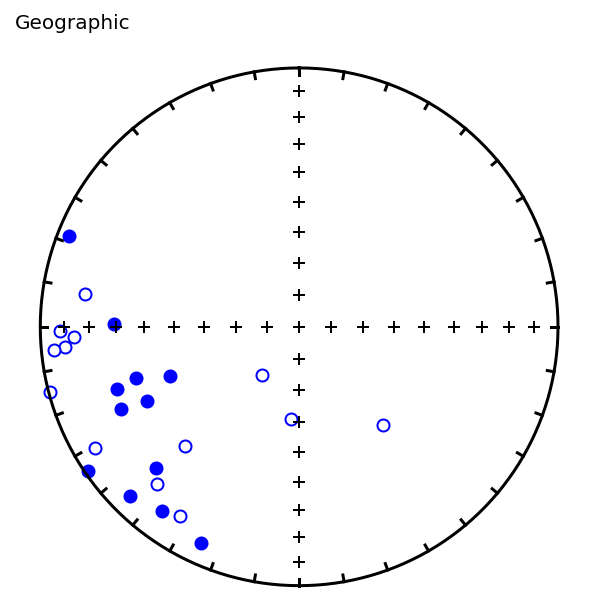

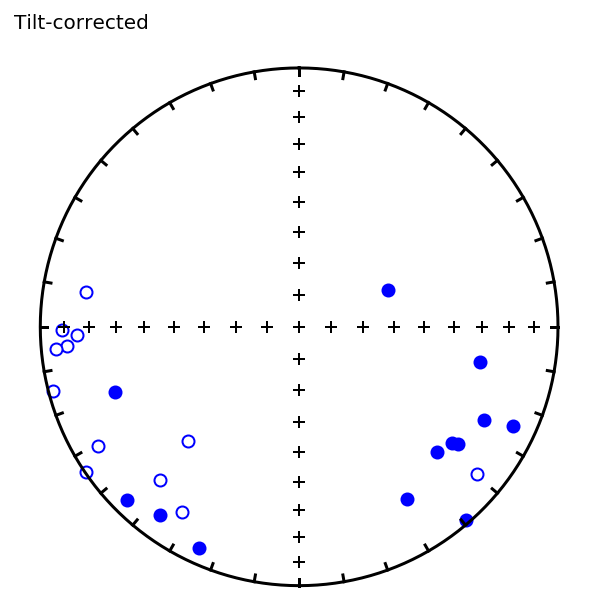

doing  1000  iterations...please be patient.....

tightest grouping of vectors obtained at (95% confidence bounds):
-10 - 119 percent unfolding
range of all bootstrap samples: 
-10  -  119 percent unfolding


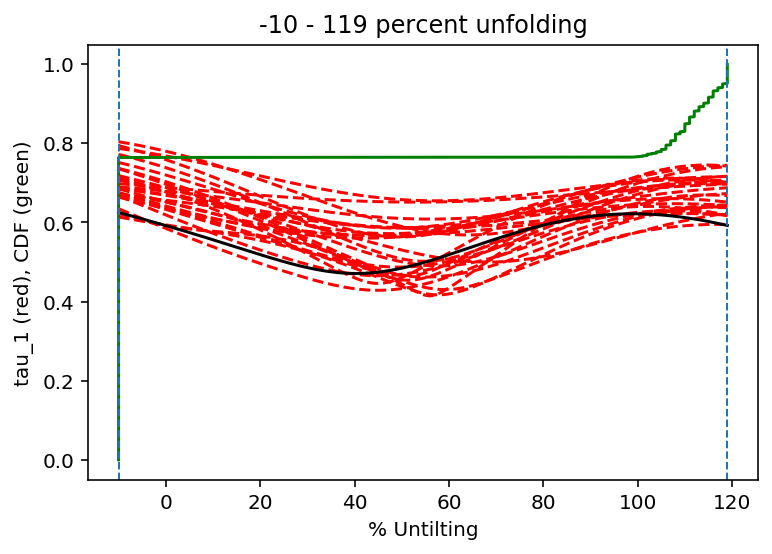

In [90]:
ipmag.bootstrap_fold_test(NW_spec_hdt_fold_test[['dir_dec', 'dir_inc', 'bed_dip_direction', 'bed_dip']].to_numpy(), 
                          save=0, save_folder='../Figures/Pmag/', fmt='pdf')

<Figure size 360x360 with 0 Axes>

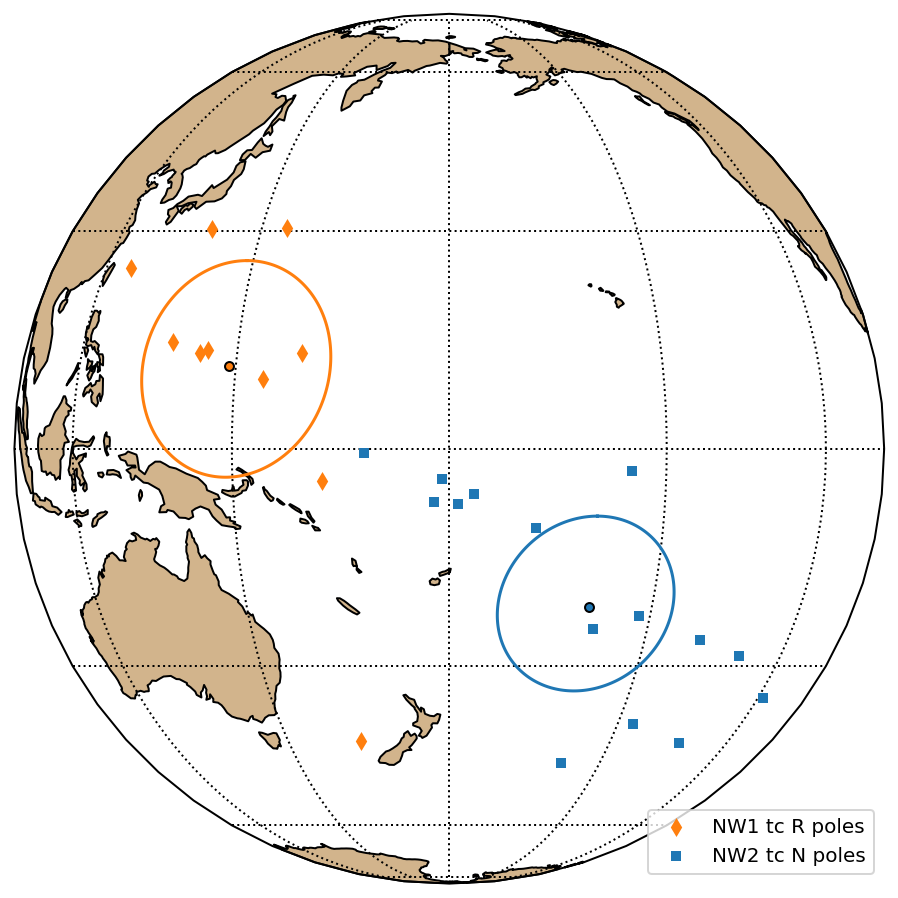

In [91]:
plt.figure(figsize=(5, 5))
map_axis=ipmag.make_orthographic_map(central_longitude=180,central_latitude=0)

ipmag.plot_vgp(map_axis, NW1_spec_hdt_tc['vgp_lon_rev'].tolist(), 
               NW1_spec_hdt_tc['vgp_lat_rev'].tolist(), 
               markersize = 45, 
               marker = 'd', 
               color = 'C1', 
               edge='none', 
               label = 'NW1 tc R poles')

ipmag.plot_vgp(map_axis, NW2_spec_hdt_tc['vgp_lon'].tolist(), 
               NW2_spec_hdt_tc['vgp_lat'].tolist(), 
               markersize = 25, 
               marker = 's', 
               color = 'C0', 
               edge='none', 
               label = 'NW2 tc N poles')

ipmag.plot_pole(map_axis, NW1_spec_hdt_tc_mean_pole['dec'], 
                NW1_spec_hdt_tc_mean_pole['inc'], 
                NW1_spec_hdt_tc_mean_pole['alpha95'], 
                color = 'C1', marker = 'o')
ipmag.plot_pole(map_axis, NW2_spec_hdt_tc_mean_pole['dec'], 
                NW2_spec_hdt_tc_mean_pole['inc'], 
                NW2_spec_hdt_tc_mean_pole['alpha95'], 
                color = 'C0', marker = 'o')

plt.legend(loc=4)
# plt.savefig('../Figures/Pmag/NW_poles.pdf')
plt.show()

### SC1

- specimen 3a may be a orienting problem. specimens near the same strat height do not record the same directions
- 74a and 75a are likely to be transitional fields as they record anomalous directions away from the N directions and sweeping toward R direction
- specimen 2,4,5,8,10 have downward inclinations
- there could be some hct component not fitted but recorded transitional field that are mixed with low temperature lt component that are not fitted or mixed fitted in SC1. They could potentially be hard to tell apart!

In [92]:
SC1_spec_lt_mean = ipmag.fisher_mean(SC1_spec_lt_gc['dir_dec'].tolist(), SC1_spec_lt_gc['dir_inc'].tolist())
SC1_spec_hdt_tc_mean = ipmag.fisher_mean(SC1_spec_hdt_tc['dir_dec'].tolist(), SC1_spec_hdt_tc['dir_inc'].tolist())
SC1_spec_hdt_tc_mean_pole = ipmag.fisher_mean(SC1_spec_hdt_tc['vgp_lon'].tolist(), SC1_spec_hdt_tc['vgp_lat'].tolist())

In [93]:
SC1_spec_hdt_tc_mean

{'dec': 256.5300037404812,
 'inc': -33.096841354947635,
 'n': 70,
 'r': 61.30095033273133,
 'k': 7.931900913225233,
 'alpha95': 6.433183947540594,
 'csd': 28.7604964750615}

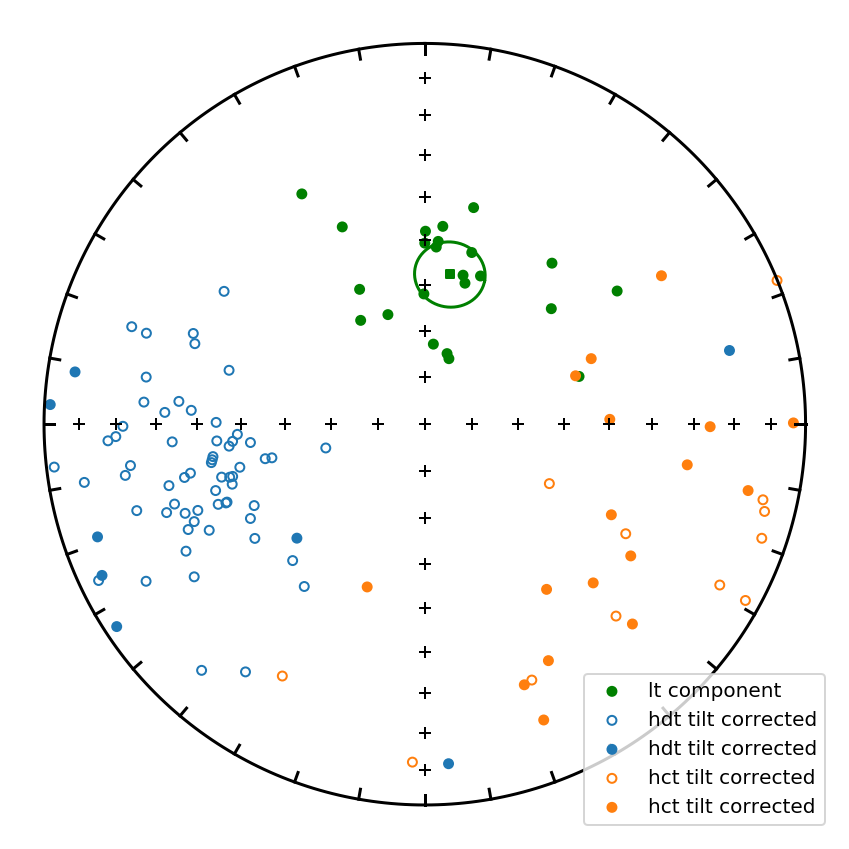

In [94]:
fignum = 1
plt.figure(num=fignum,figsize=(6,6))
ipmag.plot_net(fignum)

ipmag.plot_di(SC1_spec_lt_gc['dir_dec'].tolist(),SC1_spec_lt_gc['dir_inc'].tolist(),color='green',label='lt component')

ipmag.plot_di(SC1_spec_hdt_tc['dir_dec'].tolist(),SC1_spec_hdt_tc['dir_inc'].tolist(),color='C0',label='hdt tilt corrected')
ipmag.plot_di(SC1_spec_hct_tc['dir_dec'].tolist(),SC1_spec_hct_tc['dir_inc'].tolist(),color='C1',label='hct tilt corrected')


ipmag.plot_di_mean(SC1_spec_lt_mean['dec'],SC1_spec_lt_mean['inc'],SC1_spec_lt_mean['alpha95'],
                   color='green', marker = 's')

plt.legend(loc=4)
# plt.savefig('../Figures/SC1_directions.pdf')
plt.show()

In [95]:
SC1_spec_hdt_tc = SC1_spec_hdt_tc[~SC1_spec_hdt_tc['specimen'].str.contains('-3a|-74a|-75a')]
SC1_spec_hdt_gc = SC1_spec_hdt_gc[~SC1_spec_hdt_gc['specimen'].str.contains('-3a|-74a|-75a')]

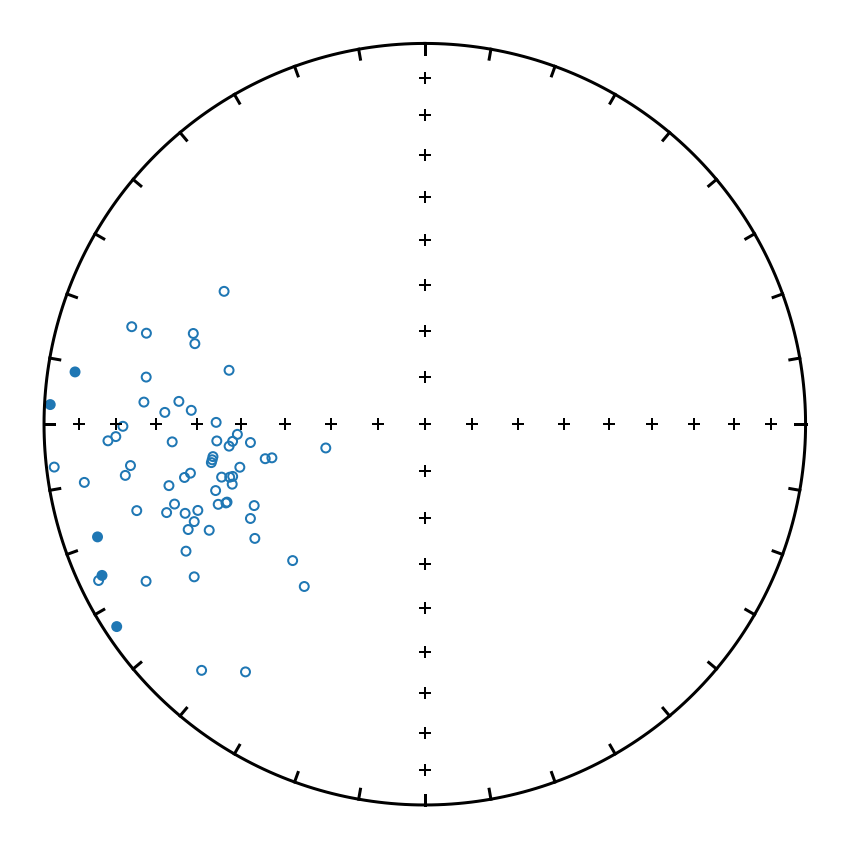

In [96]:
fignum = 1
plt.figure(num=fignum,figsize=(6,6))
ipmag.plot_net(fignum)

ipmag.plot_di(SC1_spec_hdt_tc['dir_dec'].tolist(),SC1_spec_hdt_tc['dir_inc'].tolist(),color='C0',label='SC1 N hdt tilt corrected')

# ipmag.plot_di_mean(SC1_spec_hdt_tc_mean['dec'],SC1_spec_hdt_tc_mean['inc'],SC1_spec_hdt_tc_mean['alpha95'],
#                    color='C0', marker = 's')

# plt.legend(loc=4)
# plt.savefig('../Figures/Pmag/SC_hdt.pdf', bbox_inches='tight')
plt.show()

<Figure size 360x360 with 0 Axes>

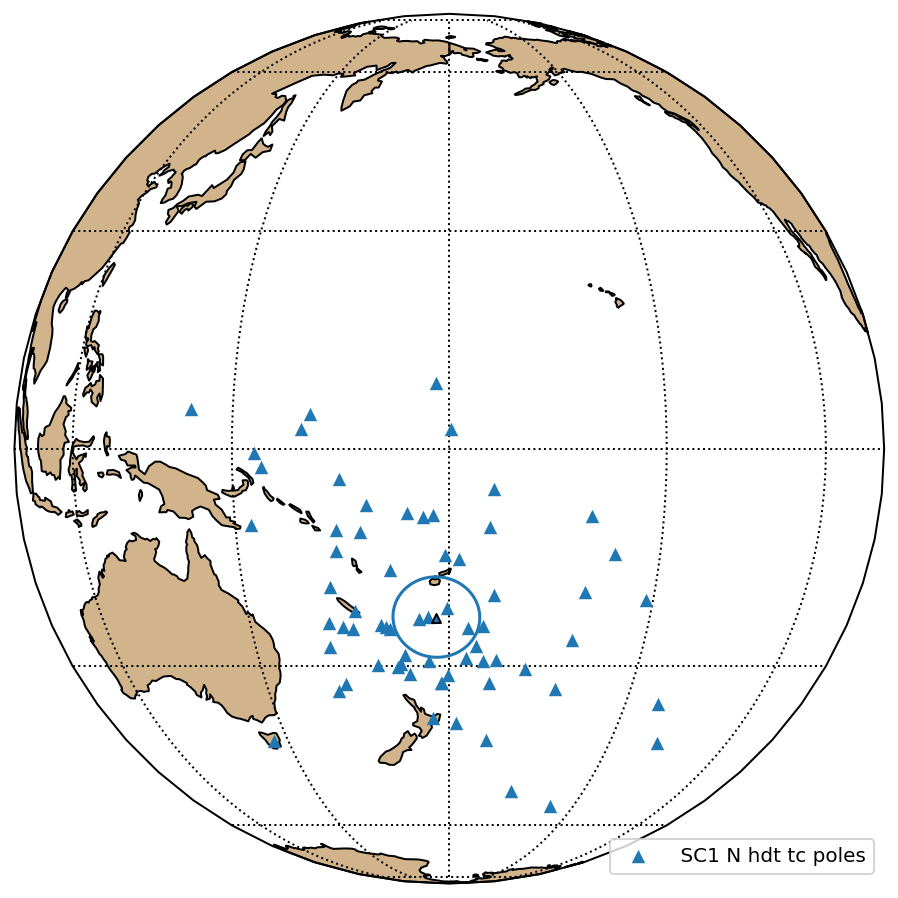

In [97]:
plt.figure(figsize=(5, 5))
map_axis=ipmag.make_orthographic_map(central_longitude=180,central_latitude=0)

ipmag.plot_vgp(map_axis, SC1_spec_hdt_tc['vgp_lon'].tolist(), 
               SC1_spec_hdt_tc['vgp_lat'].tolist(),
               markersize = 45, 
               marker = '^', 
               color = 'C0', 
               edge='none', 
               label = ' SC1 N hdt tc poles')

ipmag.plot_pole(map_axis, SC1_spec_hdt_tc_mean_pole['dec'], SC1_spec_hdt_tc_mean_pole['inc'], SC1_spec_hdt_tc_mean_pole['alpha95'], 
                color = 'C0', marker = '^')

plt.legend(loc=4)
# plt.savefig('../Figures/Pmag/SC1_poles.pdf')
plt.show()

#### E/I test on Baby Snake Creek directions

Bootstrapping.... be patient

The original inclination was: 34.79

The corrected inclination is: 42.37
with bootstrapped confidence bounds of: 32.98 to 52.29
and elongation parameter of: 1.89
The flattening factor is: 0.75
with bootstrapped confidence bounds of: 1.07 to 0.54


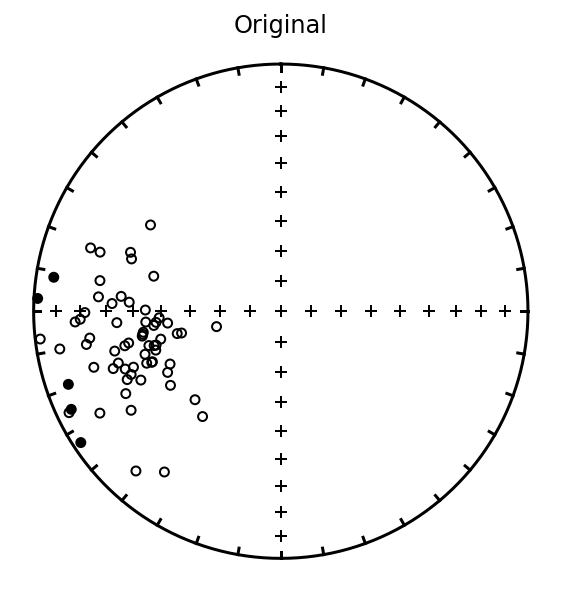

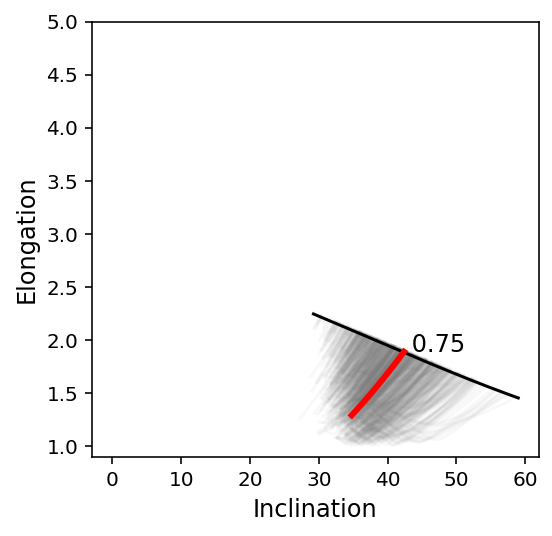

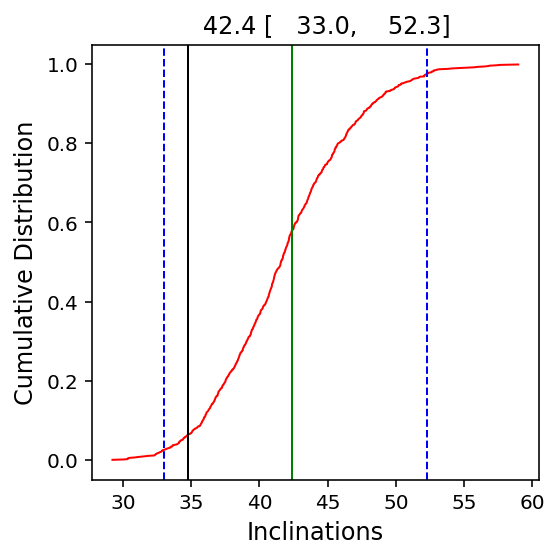

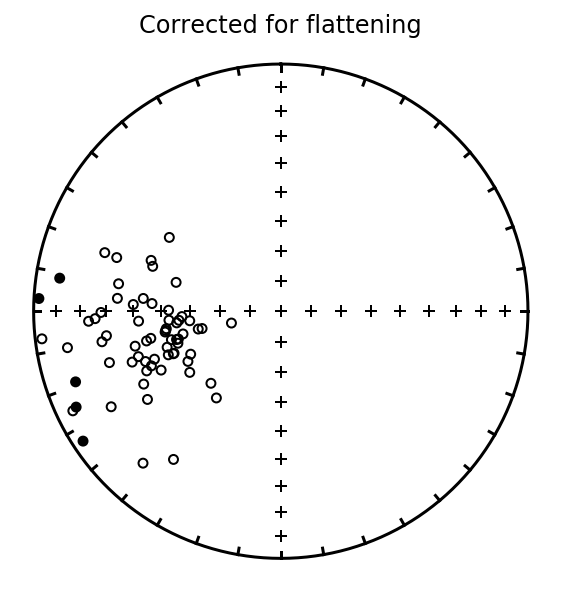

In [98]:
# E/I methods gives 0.75
ipmag.find_ei(SC1_spec_hdt_tc[['dir_dec', 'dir_inc']].to_numpy())

<Figure size 360x360 with 0 Axes>

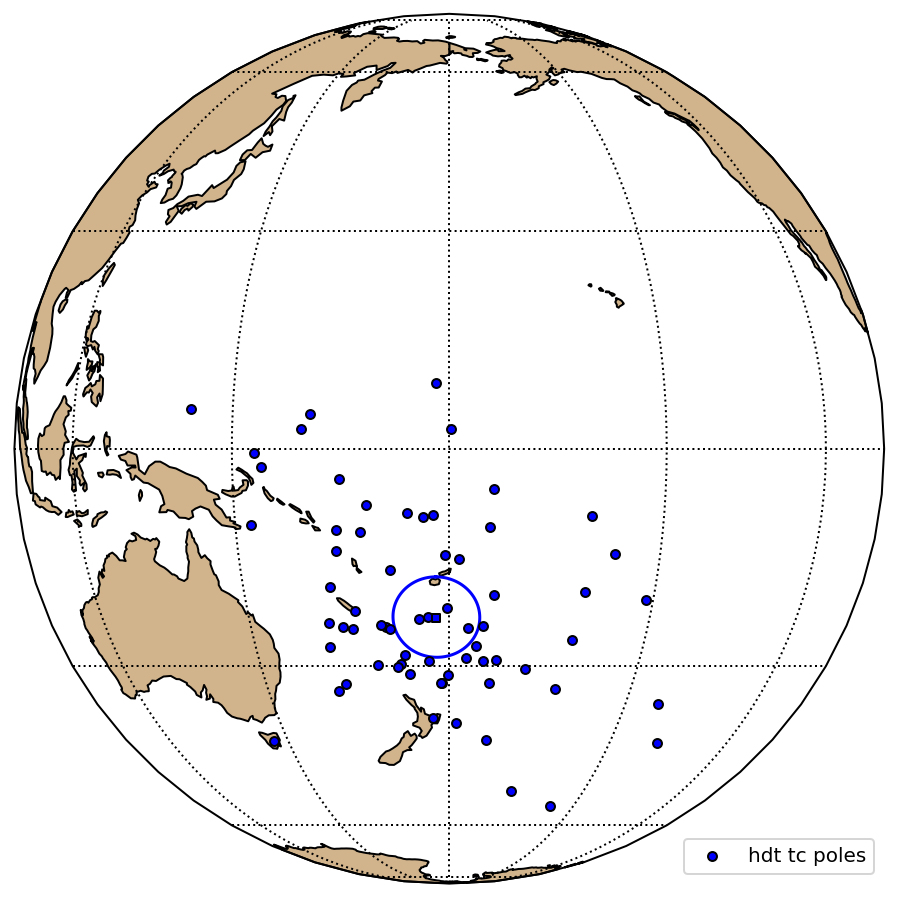

In [99]:
plt.figure(figsize=(5, 5))
map_axis=ipmag.make_orthographic_map(central_longitude=180,central_latitude=0)

ipmag.plot_vgp(map_axis, SC1_spec_hdt_tc['vgp_lon'].tolist(), SC1_spec_hdt_tc['vgp_lat'].tolist(), color = 'blue', label = 'hdt tc poles')

ipmag.plot_pole(map_axis, SC1_spec_hdt_tc_mean_pole['dec'], SC1_spec_hdt_tc_mean_pole['inc'], SC1_spec_hdt_tc_mean_pole['alpha95'], 
                color = 'blue', marker = 's')

plt.legend(loc=4)
plt.show()

#### fold test on Baby Snake Creek data

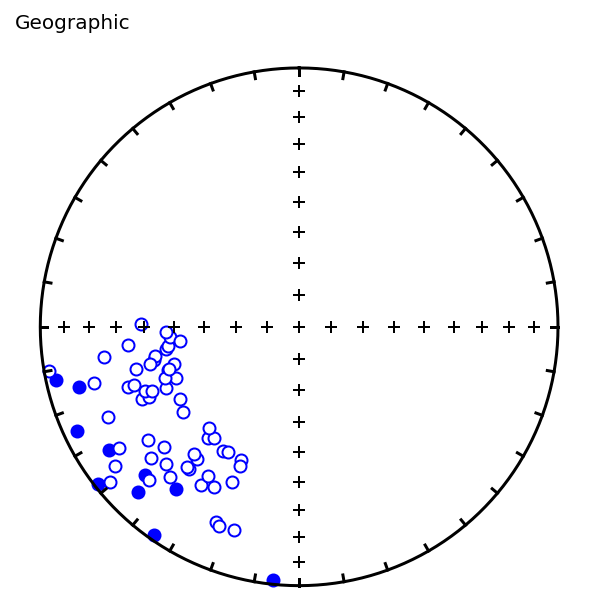

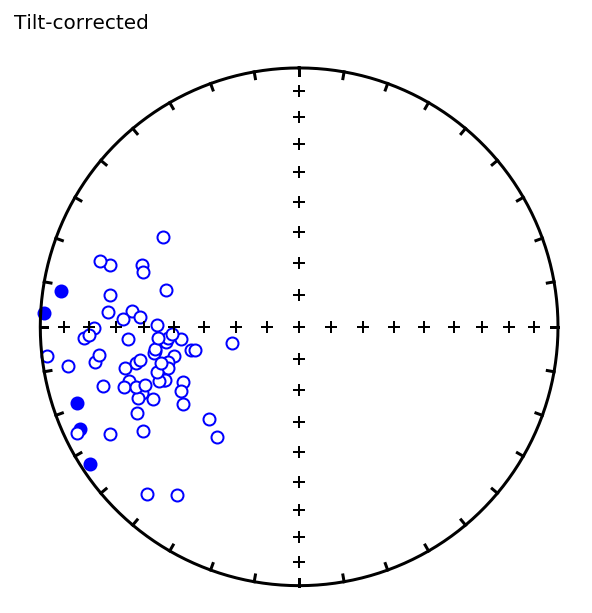

doing  1000  iterations...please be patient.....

tightest grouping of vectors obtained at (95% confidence bounds):
57 - 89 percent unfolding
range of all bootstrap samples: 
46  -  108 percent unfolding


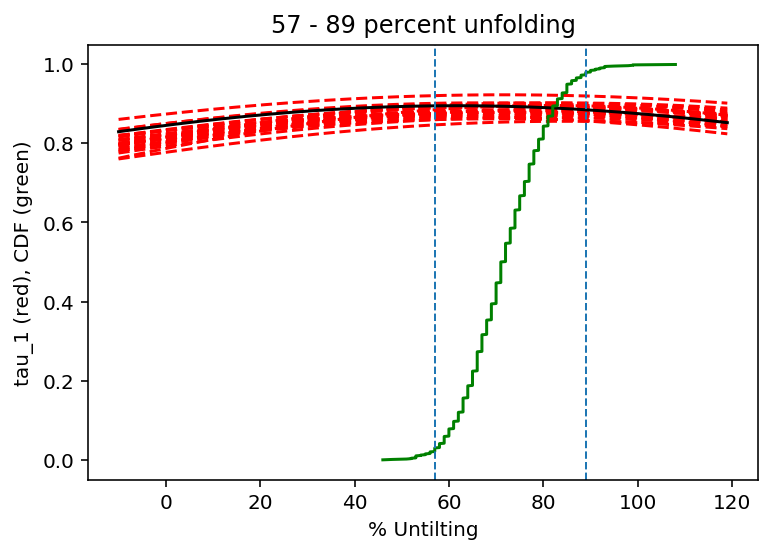

In [100]:
ipmag.bootstrap_fold_test(SC1_spec_hdt_gc[['dir_dec', 'dir_inc', 'bed_dip_direction', 'bed_dip']].to_numpy(), 
                          save=0, save_folder='../Figures/Pmag/', fmt='pdf')

## conduct a study-level tilt-test

In [101]:
study_spec = pd.concat([AF1_spec_data, AF2_spec_data, 
                           HF1_spec_data, HF2_spec_data, 
                           HF3_spec_data, HF4_spec_data, 
                           HF5_spec_data, HF6_spec_data, 
                           JK2_spec_data, JK3_spec_data, 
                           NW2_spec_data, SC1_spec_data]) 
study_spec_gc = study_spec[(study_spec['dir_comp'] == 'hdt') & (study_spec['dir_tilt_correction'] == 0)]
study_spec_gc = study_spec_gc[~study_spec_gc['specimen'].str.contains('AF1-16a|AF1-17a|AF2-5a|AF2-23a|AF2-43a|\
HF1-79|HF1-80|HF1-81|HF1-82|HF1-83|HF1-84|HF1-85|HF1-86|HF1-87|HF1-88|HF1-89|HF1-91|HF1-95|HF1-98|HF1-100|HF1-101|\
HF1-102|HF1-107|HF1-121|HF1-122|HF1-123|HF1-124|HF1-125|HF3-2|SC1-3a|SC1-74a|SC1-75a')].reset_index(drop=1)
study_spec_gc['DEC'] = [study_spec_gc['dir_dec'][i] if study_spec_gc['dir_dec'][i]>180 else (study_spec_gc['dir_dec'][i]+180)%360 for i in range(study_spec_gc.shape[0])]
study_spec_gc['INC'] = [study_spec_gc['dir_inc'][i] if study_spec_gc['dir_dec'][i]>180 else -study_spec_gc['dir_inc'][i] for i in range(study_spec_gc.shape[0])]


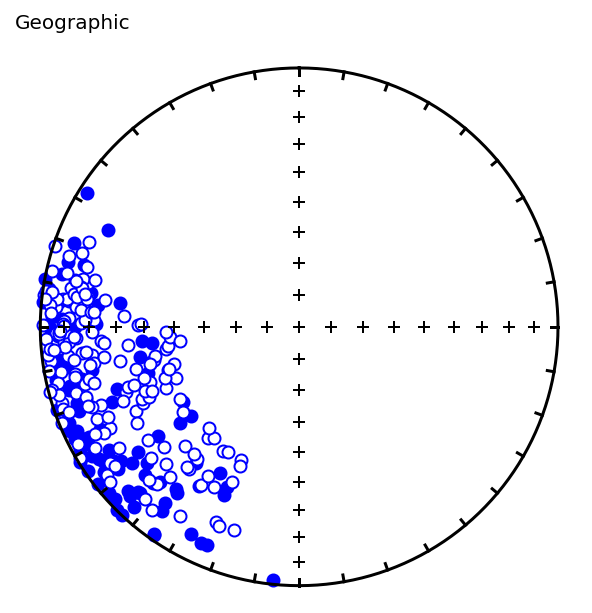

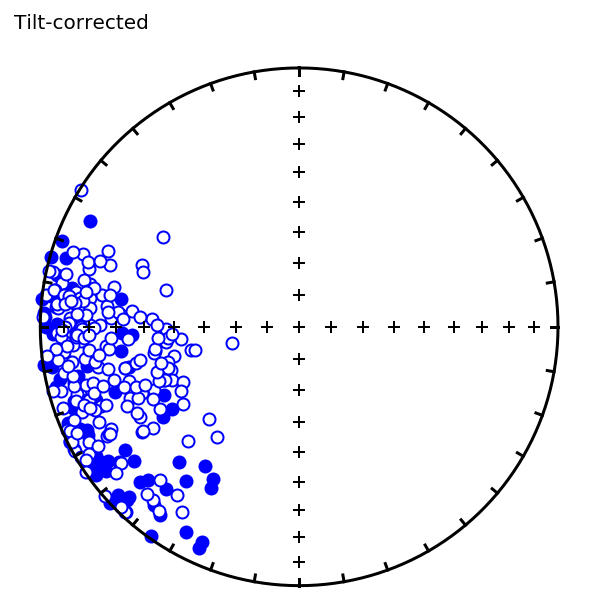

doing  1000  iterations...please be patient.....

tightest grouping of vectors obtained at (95% confidence bounds):
117 - 119 percent unfolding
range of all bootstrap samples: 
105  -  119 percent unfolding


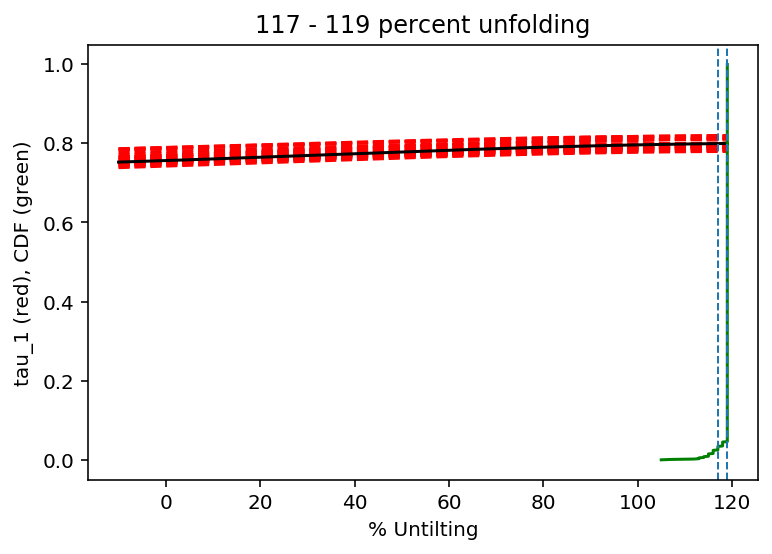

In [102]:
ipmag.bootstrap_fold_test(study_spec_gc[['DEC', 'INC', 'bed_dip_direction', 'bed_dip']].to_numpy(), 
                          save=0, save_folder='../Figures/Pmag/', fmt='pdf')

## combine hdt N and R directions respectively and calculate mean directions and pole positions

In [103]:
Jacobsville_N_spec = pd.concat([AF1_spec_hdt_tc_N, AF2_spec_hdt_tc_N, HF5_spec_hdt_tc_N, HF3_spec_hdt_tc, HF1_spec_hdt_tc_N, SC1_spec_hdt_tc, NW2_spec_hdt_tc]).reset_index(drop=1)
Jacobsville_R_spec = pd.concat([AF1_spec_hdt_tc_R, AF2_spec_hdt_tc_R, HF5_spec_hdt_tc_R, HF6_spec_hdt_tc, HF4_spec_hdt_tc, 
                                HF2_spec_hdt_tc, HF1_spec_hdt_tc_R, JK2_spec_hdt_tc, JK3_spec_hdt_tc]).reset_index(drop=1)

Jacobsville_hct_spec = pd.concat([AF1_spec_hct_tc, AF2_spec_hct_tc, AFC_spec_hct_tc, HF6_spec_hct_tc, HF5_spec_hct_tc, 
                                  HF4_spec_hct_tc, HF3_spec_hct_tc, HF2_spec_hct_tc, HF1_spec_hct_R_tc, HFC_spec_hct_tc, JK3_spec_hct_tc]).reset_index(drop=1)

Jacobsville_hdt_spec = pd.concat([Jacobsville_N_spec, Jacobsville_R_spec]).reset_index(drop=1)

Jacobsville_N_direction_mean = ipmag.fisher_mean(Jacobsville_N_spec['dir_dec'].tolist(), Jacobsville_N_spec['dir_inc'].tolist())
Jacobsville_R_direction_mean = ipmag.fisher_mean(Jacobsville_R_spec['dir_dec'].tolist(), Jacobsville_R_spec['dir_inc'].tolist())
Jacobsville_hct_direction_mean = ipmag.fisher_mean(Jacobsville_hct_spec['dir_dec'].tolist(), Jacobsville_hct_spec['dir_inc'].tolist())

Jacobsville_hct_pole_mean = ipmag.fisher_mean(Jacobsville_hct_spec['vgp_lon_rev'].tolist(), Jacobsville_hct_spec['vgp_lat_rev'].tolist())

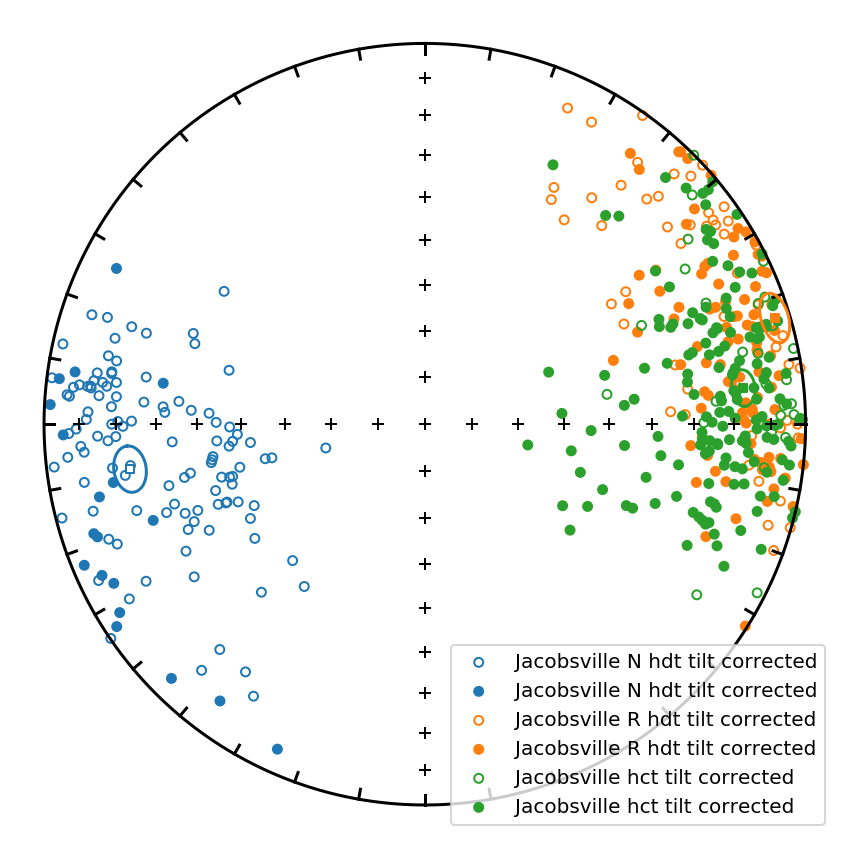

In [104]:
fignum = 1
plt.figure(num=fignum,figsize=(6,6))
ipmag.plot_net(fignum)

ipmag.plot_di(Jacobsville_N_spec['dir_dec'].tolist(),Jacobsville_N_spec['dir_inc'].tolist(),color='C0',label='Jacobsville N hdt tilt corrected')
ipmag.plot_di(Jacobsville_R_spec['dir_dec'].tolist(),Jacobsville_R_spec['dir_inc'].tolist(),color='C1',label='Jacobsville R hdt tilt corrected')
ipmag.plot_di(Jacobsville_hct_spec['dir_dec'].tolist(),Jacobsville_hct_spec['dir_inc'].tolist(),color='C2',label='Jacobsville hct tilt corrected')


ipmag.plot_di_mean(Jacobsville_N_direction_mean['dec'],Jacobsville_N_direction_mean['inc'],Jacobsville_N_direction_mean['alpha95'],
                   color='C0', marker = 's')
ipmag.plot_di_mean(Jacobsville_R_direction_mean['dec'],Jacobsville_R_direction_mean['inc'],Jacobsville_R_direction_mean['alpha95'],
                   color='C1', marker = 's')
ipmag.plot_di_mean(Jacobsville_hct_direction_mean['dec'],Jacobsville_hct_direction_mean['inc'],Jacobsville_hct_direction_mean['alpha95'],
                   color='C2', marker = 's')

plt.legend(loc=4)
# plt.savefig('../Figures/specimen_directions.pdf')
plt.show()

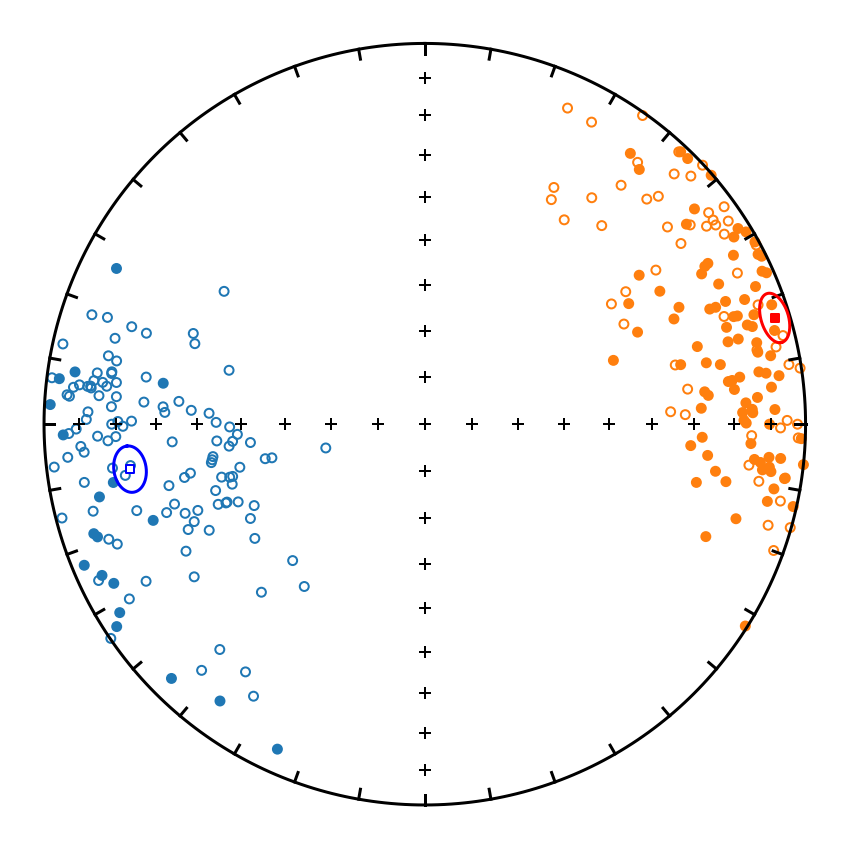

In [105]:
fignum = 1
plt.figure(num=fignum,figsize=(6,6))
ipmag.plot_net(fignum)

ipmag.plot_di(Jacobsville_N_spec['dir_dec'].tolist(),Jacobsville_N_spec['dir_inc'].tolist(),color='C0',label='high-temperature component N direction')
ipmag.plot_di(Jacobsville_R_spec['dir_dec'].tolist(),Jacobsville_R_spec['dir_inc'].tolist(),color='C1',label='high-temperature component R direction')
# ipmag.plot_di(Jacobsville_hct_spec['dir_dec'].tolist(),Jacobsville_hct_spec['dir_inc'].tolist(),color='C2',label='Jacobsville hct tilt corrected')


ipmag.plot_di_mean(Jacobsville_N_direction_mean['dec'],Jacobsville_N_direction_mean['inc'],Jacobsville_N_direction_mean['alpha95'],
                   color='b', marker = 's')
ipmag.plot_di_mean(Jacobsville_R_direction_mean['dec'],Jacobsville_R_direction_mean['inc'],Jacobsville_R_direction_mean['alpha95'],
                   color='r', marker = 's')
# ipmag.plot_di_mean(Jacobsville_hct_direction_mean['dec'],Jacobsville_hct_direction_mean['inc'],Jacobsville_hct_direction_mean['alpha95'],
#                    color='C2', marker = 's')

# plt.legend(loc=8, fontsize=12)
# plt.savefig('../Figures/Pmag/Jacobsville_all_directions.pdf', bbox_inches='tight')
plt.show()

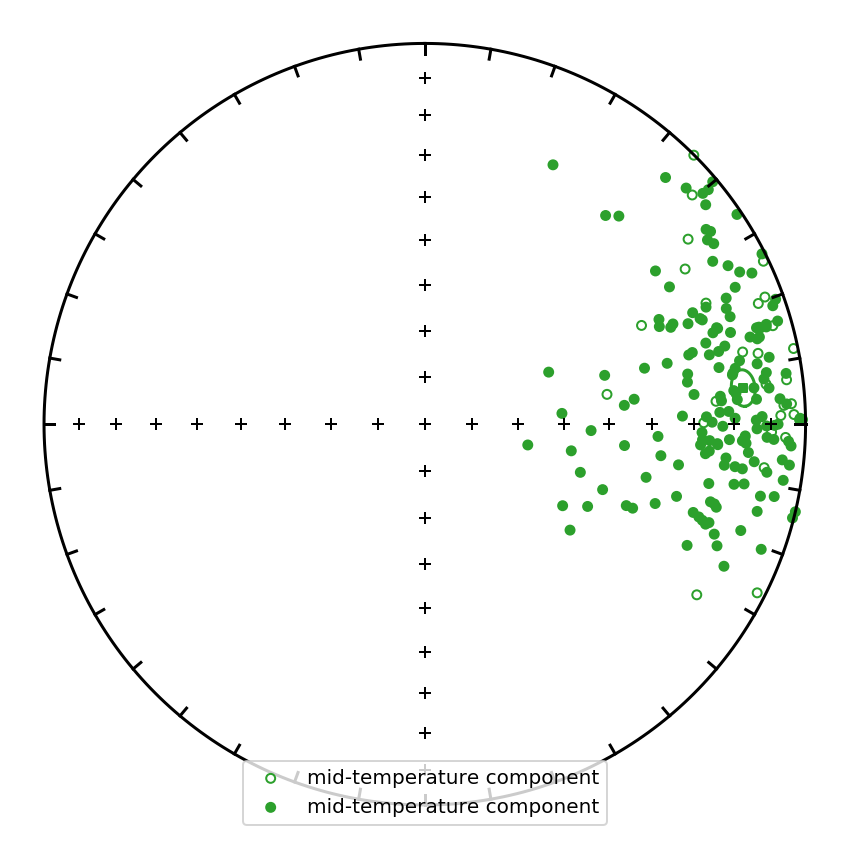

In [106]:
fignum = 1
plt.figure(num=fignum,figsize=(6,6))
ipmag.plot_net(fignum)

ipmag.plot_di(Jacobsville_hct_spec['dir_dec'].tolist(),Jacobsville_hct_spec['dir_inc'].tolist(),color='C2',label='mid-temperature component')

ipmag.plot_di_mean(Jacobsville_hct_direction_mean['dec'],Jacobsville_hct_direction_mean['inc'],Jacobsville_hct_direction_mean['alpha95'],
                   color='C2', marker = 's')

plt.legend(loc=8)
# plt.savefig('../Figures/Pmag/Jacobsville_hct_directions.pdf', bbox_inches='tight')
plt.show()

### test E/I on N and R directions

Bootstrapping.... be patient

The original inclination was: 23.26

The corrected inclination is: 31.74
with bootstrapped confidence bounds of: 25.25 to 38.53
and elongation parameter of: 2.19
The flattening factor is: 0.67
with bootstrapped confidence bounds of: 0.91 to 0.54


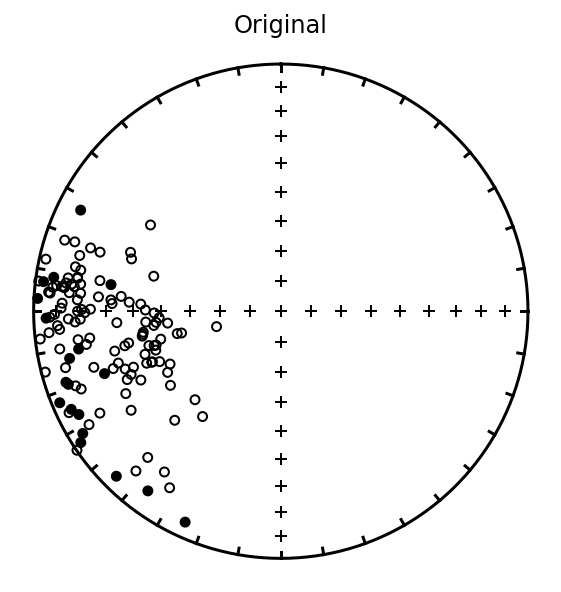

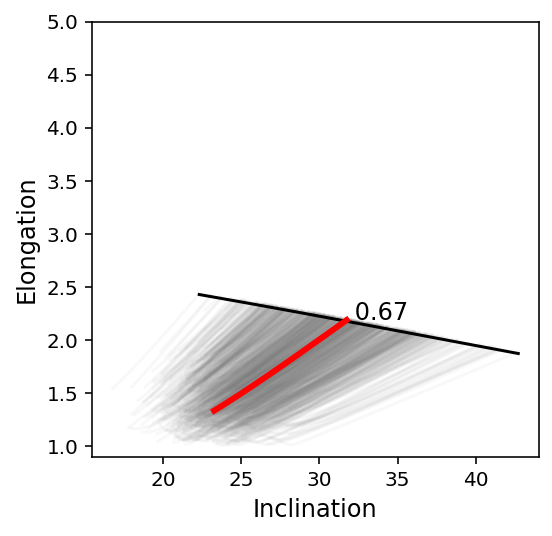

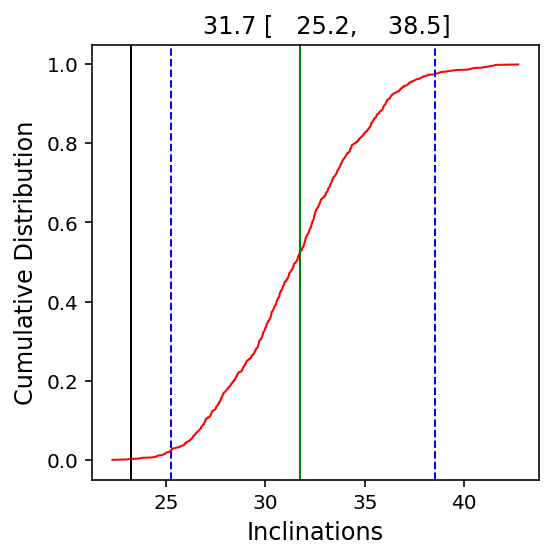

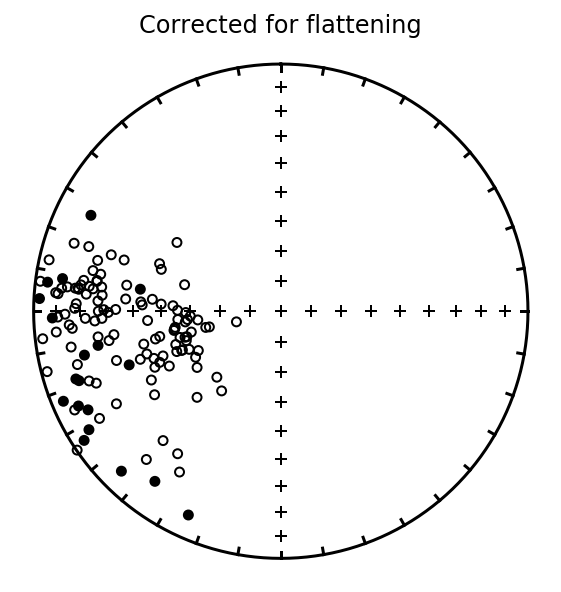

In [107]:
ipmag.find_ei(Jacobsville_N_spec[['dir_dec', 'dir_inc']].to_numpy())

Bootstrapping.... be patient

The original inclination was: 5.36

The corrected inclination is: 11.91
with bootstrapped confidence bounds of: 5.73 to 18.49
and elongation parameter of: 2.69
The flattening factor is: 0.52
with bootstrapped confidence bounds of: 0.93 to 0.28


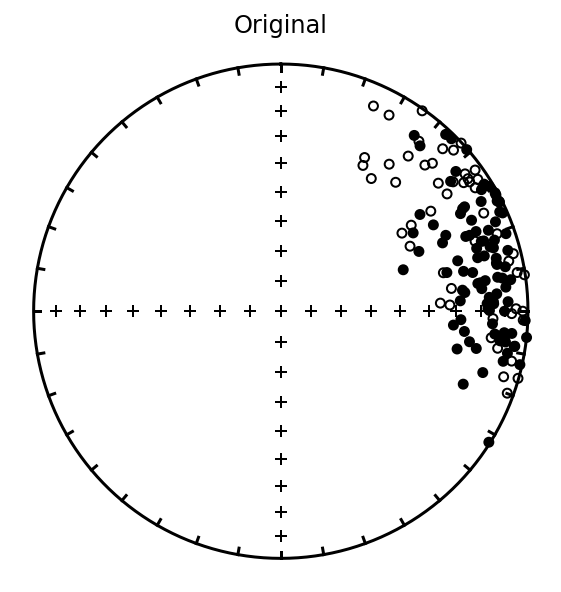

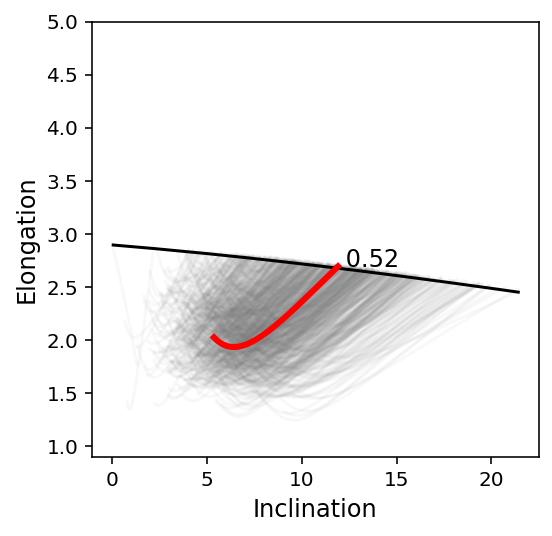

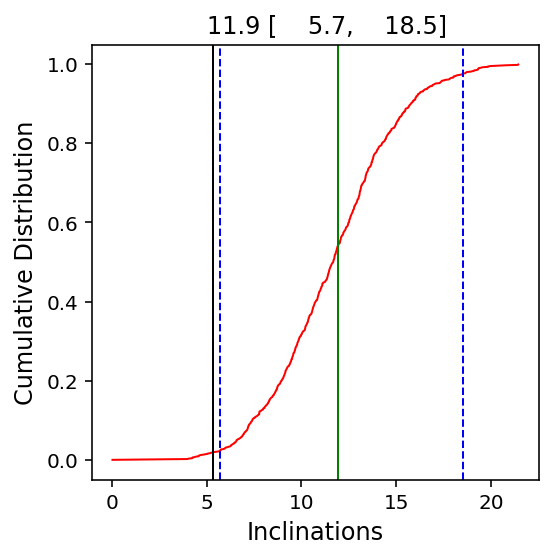

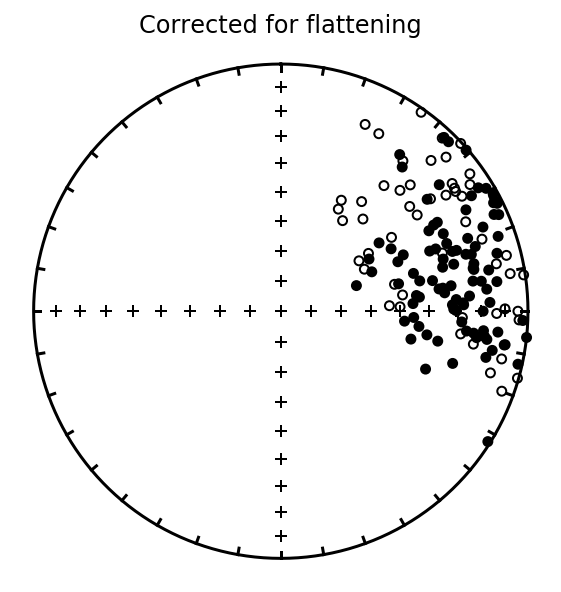

In [108]:
ipmag.find_ei(Jacobsville_R_spec[['dir_dec', 'dir_inc']].to_numpy())

### test if inclination-corrected directions pass common mean test

In [109]:
Jacobsville_N_spec['dir_inc_cor'] = ipmag.unsquish(Jacobsville_N_spec['dir_inc'].tolist(), 0.67)
Jacobsville_R_spec['dir_inc_cor'] = ipmag.unsquish(Jacobsville_R_spec['dir_inc'].tolist(), 0.52)
Jacobsville_dir_inc_cor = pd.concat([Jacobsville_N_spec[['dir_dec', 'dir_inc_cor']], Jacobsville_R_spec[['dir_dec', 'dir_inc_cor']]]).reset_index(drop=1)

In [110]:
Jacobsville_N_spec['vgp_lon_cor'] = pmag.dia_vgp(Jacobsville_N_spec[['dir_dec', 'dir_inc_cor', 'dir_alpha95', 'latitude', 'longitude']].to_numpy())[0]
Jacobsville_N_spec['vgp_lat_cor'] = pmag.dia_vgp(Jacobsville_N_spec[['dir_dec', 'dir_inc_cor', 'dir_alpha95', 'latitude', 'longitude']].to_numpy())[1]
Jacobsville_R_spec['vgp_lon_cor'] = (np.array(pmag.dia_vgp(Jacobsville_R_spec[['dir_dec', 'dir_inc_cor', 'dir_alpha95', 'latitude', 'longitude']].to_numpy())[0])+180)%360
Jacobsville_R_spec['vgp_lat_cor'] = -np.array(pmag.dia_vgp(Jacobsville_R_spec[['dir_dec', 'dir_inc_cor', 'dir_alpha95', 'latitude', 'longitude']].to_numpy())[1])

In [111]:
Jacobsville_N_dir_inc_cor_mean = ipmag.fisher_mean(Jacobsville_N_spec['dir_dec'].tolist(),Jacobsville_N_spec['dir_inc_cor'].tolist())
Jacobsville_R_dir_inc_cor_mean = ipmag.fisher_mean(Jacobsville_R_spec['dir_dec'].tolist(),Jacobsville_R_spec['dir_inc_cor'].tolist())

In [112]:
Jacobsville_N_pole_cor_mean = ipmag.fisher_mean(Jacobsville_N_spec['vgp_lon_cor'].tolist(),Jacobsville_N_spec['vgp_lat_cor'].tolist())
Jacobsville_R_pole_cor_mean = ipmag.fisher_mean(Jacobsville_R_spec['vgp_lon_cor'].tolist(),Jacobsville_R_spec['vgp_lat_cor'].tolist())

In [113]:
Jacobsville_N_dir_inc_cor_mean

{'dec': 261.49429199077764,
 'inc': -29.820588175306447,
 'n': 130,
 'r': 113.68654667433533,
 'k': 7.907583846582286,
 'alpha95': 4.706098718154862,
 'csd': 28.804684059992997}

In [114]:
Jacobsville_R_dir_inc_cor_mean

{'dec': 73.25823191710138,
 'inc': 8.250000084474776,
 'n': 148,
 'r': 122.41881497311813,
 'k': 5.7464108814945725,
 'alpha95': 5.316660444252841,
 'csd': 33.78988245318129}

In [115]:
Jacobsville_N_pole_cor_mean

{'dec': 175.14790887546,
 'inc': -19.05506868024321,
 'n': 130,
 'r': 119.0151415940556,
 'k': 11.74343766963736,
 'alpha95': 3.773941500922667,
 'csd': 23.636730056477774}

In [116]:
Jacobsville_R_pole_cor_mean

{'dec': 191.07076089557467,
 'inc': -14.543946889711126,
 'n': 148,
 'r': 132.76524168460222,
 'k': 9.648987988961201,
 'alpha95': 3.9391995646677027,
 'csd': 26.076189951040668}

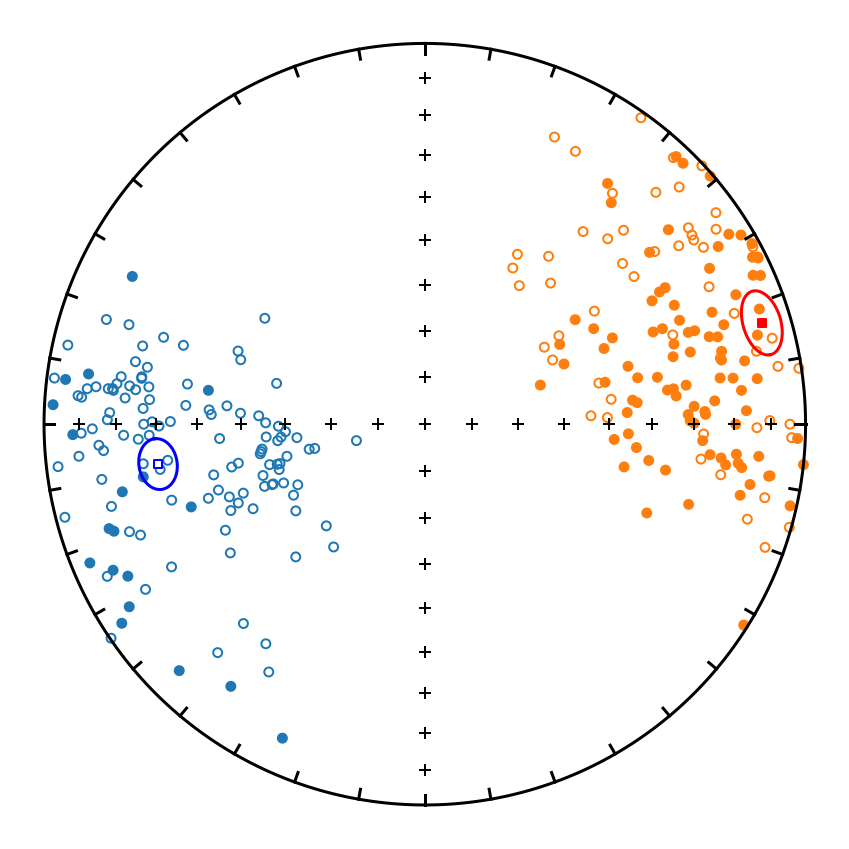

In [117]:
fignum = 1
plt.figure(num=fignum,figsize=(6,6))
ipmag.plot_net(fignum)

ipmag.plot_di(Jacobsville_N_spec['dir_dec'].tolist(),Jacobsville_N_spec['dir_inc_cor'].tolist(),color='C0',label='high-temperature component N direction')
ipmag.plot_di(Jacobsville_R_spec['dir_dec'].tolist(),Jacobsville_R_spec['dir_inc_cor'].tolist(),color='C1',label='high-temperature component R direction')


ipmag.plot_di_mean(Jacobsville_N_dir_inc_cor_mean['dec'],Jacobsville_N_dir_inc_cor_mean['inc'],Jacobsville_N_dir_inc_cor_mean['alpha95'],
                   color='b', marker = 's')
ipmag.plot_di_mean(Jacobsville_R_dir_inc_cor_mean['dec'],Jacobsville_R_dir_inc_cor_mean['inc'],Jacobsville_R_dir_inc_cor_mean['alpha95'],
                   color='r', marker = 's')


# plt.legend(loc=8, fontsize=12)
# plt.savefig('../Figures/Pmag/Jacobsville_dual_polarity_inc_cor.pdf', bbox_inches='tight')
plt.show()

In [118]:
ipmag.reversal_test_MM1990(di_block=Jacobsville_dir_inc_cor.to_numpy())

Results of Watson V test: 

Watson's V:           62.9
Critical value of V:  6.1
"Fail": Since V is greater than Vcrit, the two means can
be distinguished at the 95% confidence level.

M&M1990 classification:

Angle between data set means: 22.9
Critical angle for M&M1990:   7.1



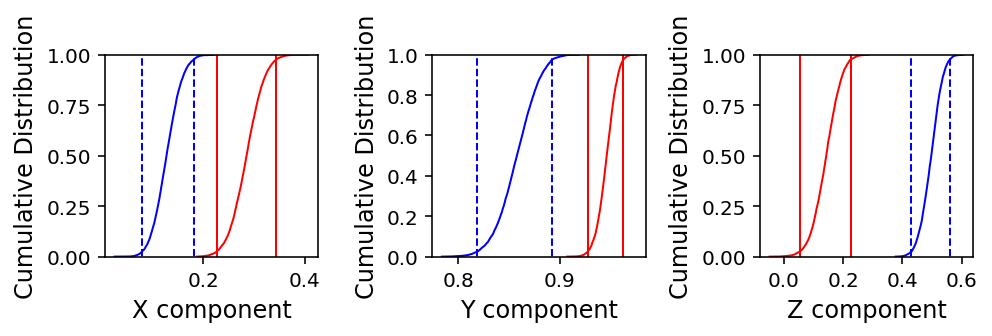

In [119]:
ipmag.reversal_test_bootstrap(di_block=Jacobsville_dir_inc_cor.to_numpy())

## test if Jacobsville reversed share a common mean with Chequamegan reversed

In [120]:
McCabe1983a = pd.read_csv('../Data/Pmag_compiled/McCabe1983a_sites.txt', header=1, sep='\t')
McCabe1983a.head()

site  location      Area  dir_dec  dir_inc  dir_k  dir_n_samples  \
0     1  Bayfield  Bayfield     77.6     30.8   29.7             10   
1     2  Bayfield  Bayfield     89.2     27.7   29.7              5   
2     3  Bayfield  Bayfield     81.8     18.3   22.7              9   
3     4  Bayfield  Bayfield     80.5     15.7   14.6              6   
4     6  Bayfield  Bayfield     87.5     15.6   21.7              8   

   dir_n_specimens  dir_n_total_specimens  dir_alpha95  lat  lon   Plon  Plat  \
0               10                     10          9.0  NaN  NaN  176.4 -20.4   
1                5                      5         14.3  NaN  NaN  169.5 -11.2   
2                9                      9         11.0  NaN  NaN  178.7 -12.5   
3                6                      6         18.2  NaN  NaN  180.7 -12.3   
4                8                      8         12.2  NaN  NaN  175.8  -7.5   

   grain_size  sample_color  
0         NaN           NaN  
1         NaN           NaN  
2         NaN           NaN  
3         NaN           NaN  
4         NaN           NaN

In [121]:
McCabe1983a_pole_mean = ipmag.fisher_mean(McCabe1983a['Plon'], McCabe1983a['Plat'])
McCabe1983a_pole_mean

{'dec': 177.74424043725244,
 'inc': -12.35214808096987,
 'n': 10,
 'r': 9.920024462271519,
 'k': 112.53441059133834,
 'alpha95': 4.573478508913342,
 'csd': 7.635585570476109}

In [122]:
ipmag.common_mean_watson(McCabe1983a[['dir_dec', 'dir_inc']].to_numpy(), Jacobsville_R_spec[['dir_dec', 'dir_inc']].to_numpy())

Results of Watson V test: 

Watson's V:           45.8
Critical value of V:  6.4
"Fail": Since V is greater than Vcrit, the two means can
be distinguished at the 95% confidence level.

M&M1990 classification:

Angle between data set means: 17.5
Critical angle for M&M1990:   6.6



(0, 17.5113600577391, 6.563874172189193)

In [123]:
ipmag.common_mean_watson(McCabe1983a[['dir_dec', 'dir_inc']].to_numpy(), Jacobsville_R_spec[['dir_dec', 'dir_inc_cor']].to_numpy())

Results of Watson V test: 

Watson's V:           23.2
Critical value of V:  6.4
"Fail": Since V is greater than Vcrit, the two means can
be distinguished at the 95% confidence level.

M&M1990 classification:

Angle between data set means: 14.2
Critical angle for M&M1990:   7.5



(0, 14.244571501041667, 7.453627421130642)

## combine N and R directions and reassess overall inclination shallowing

In [124]:
Jacobsville_hdt_spec['DEC'] = [Jacobsville_hdt_spec['dir_dec'][i] if Jacobsville_hdt_spec['dir_dec'][i] > 180 else (Jacobsville_hdt_spec['dir_dec'][i]+180)%360 for i in range(Jacobsville_hdt_spec['dir_dec'].shape[0])]
Jacobsville_hdt_spec['INC'] = [Jacobsville_hdt_spec['dir_inc'][i] if Jacobsville_hdt_spec['dir_dec'][i] > 180 else -Jacobsville_hdt_spec['dir_inc'][i] for i in range(Jacobsville_hdt_spec['dir_dec'].shape[0])]


Bootstrapping.... be patient

The original inclination was: 13.8

The corrected inclination is: 21.56
with bootstrapped confidence bounds of: 17.19 to 25.54
and elongation parameter of: 2.46
The flattening factor is: 0.61
with bootstrapped confidence bounds of: 0.79 to 0.51


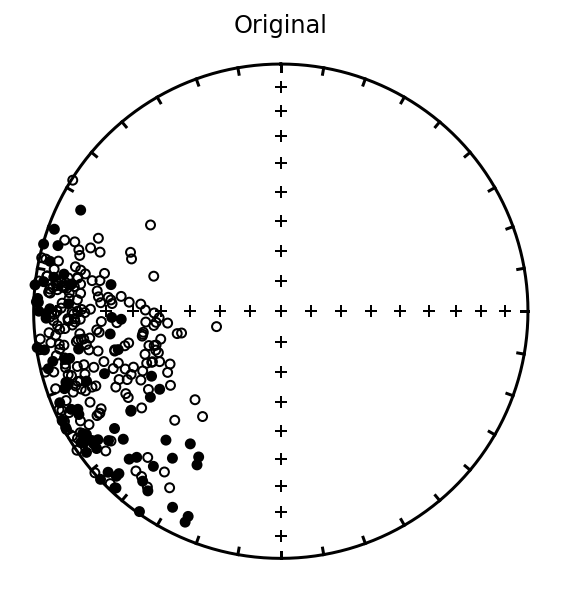

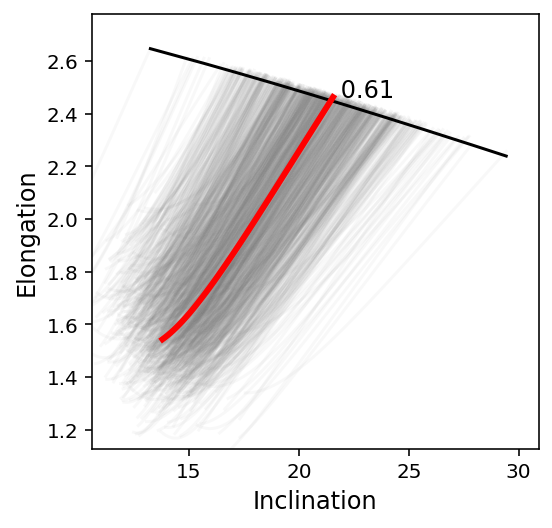

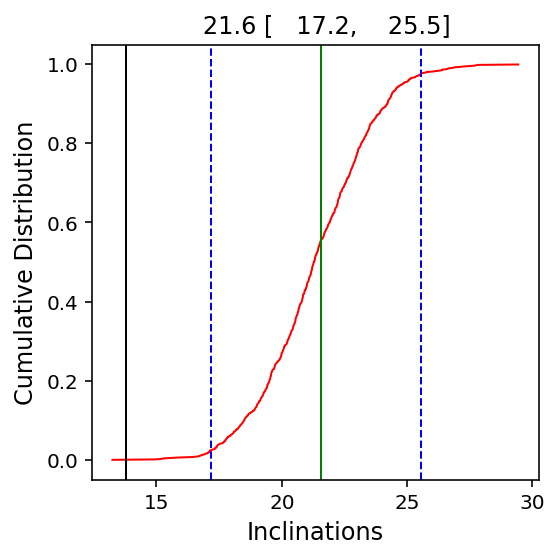

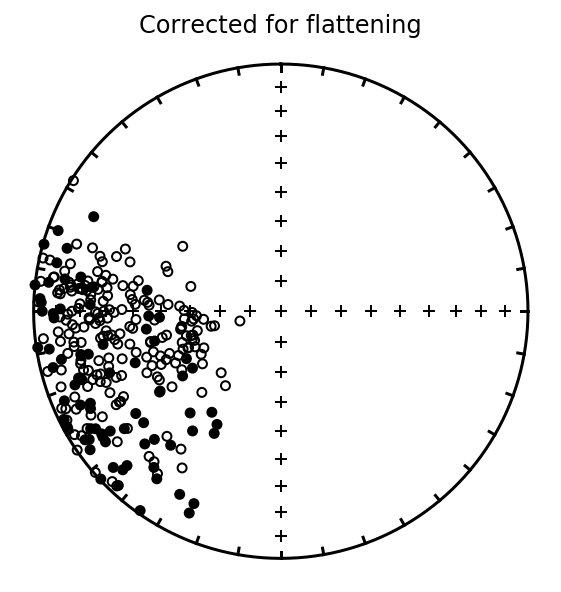

In [151]:
ht_tc_ei_corrected, EI_incs, EI_elongs, EI_fs  = ipmag.find_ei(Jacobsville_hdt_spec[['DEC', 'INC']].to_numpy(), 
                                                               return_new_dirs=1, return_values=True,save=1, save_folder='../Figures/Pmag',fmt='png', tight_axes=1)

In [126]:
Jacobsville_hdt_spec['INC_COR'] = ipmag.unsquish(Jacobsville_hdt_spec['INC'], 0.61)
Jacobsville_hdt_spec_inc_cor_mean = ipmag.fisher_mean(Jacobsville_hdt_spec['DEC'].tolist(),Jacobsville_hdt_spec['INC_COR'].tolist())

In [127]:
Jacobsville_hdt_spec_inc_cor_mean

{'dec': 256.8383363770618,
 'inc': -18.73449831390522,
 'n': 278,
 'r': 232.38798012729418,
 'k': 6.072960609353688,
 'alpha95': 3.743989395600232,
 'csd': 32.868870988970905}

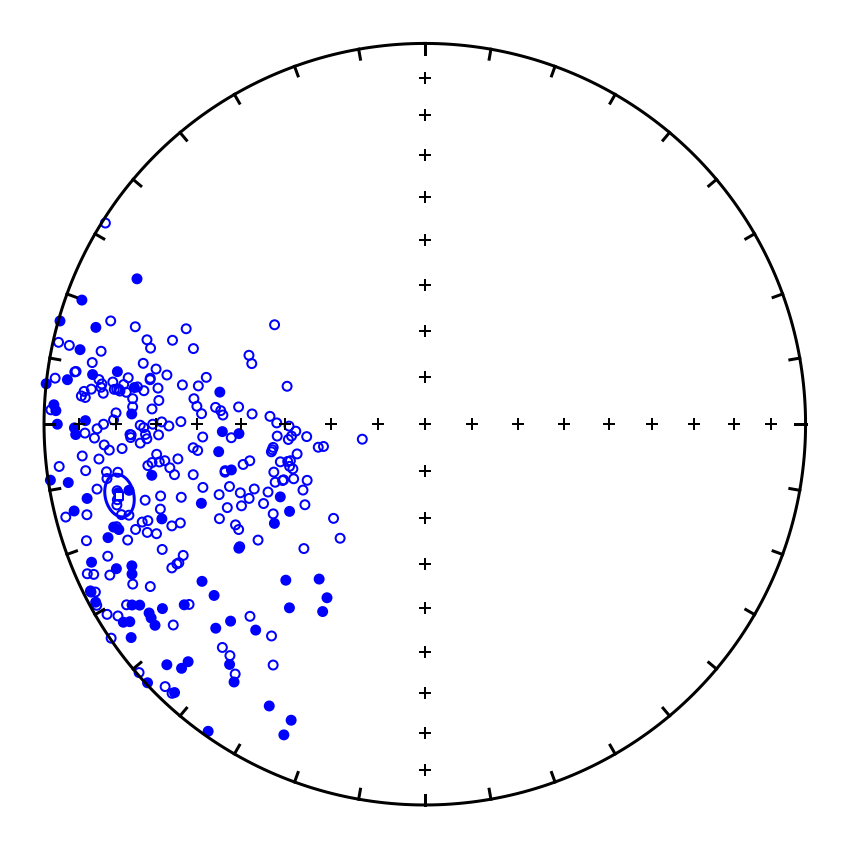

In [128]:
fignum = 1
plt.figure(num=fignum,figsize=(6,6))
ipmag.plot_net(fignum)

ipmag.plot_di(Jacobsville_hdt_spec['DEC'].tolist(),Jacobsville_hdt_spec['INC_COR'].tolist(),color='b',label='Jacobsville overall inc corrected direction')

ipmag.plot_di_mean(Jacobsville_hdt_spec_inc_cor_mean['dec'],Jacobsville_hdt_spec_inc_cor_mean['inc'],Jacobsville_hdt_spec_inc_cor_mean['alpha95'],
                   color='b', marker = 's')

# plt.legend(loc=8, fontsize=12)
# plt.savefig('../Figures/Pmag/Jacobsville_all_directions_inc_cor.pdf', bbox_inches='tight')
plt.show()

## Jacobsville Fisher mean pole

In [129]:
# first calculate vgp from inclination corrected directions
Jacobsville_hdt_spec['vgp_lon_cor'] = pmag.dia_vgp(Jacobsville_hdt_spec[['DEC', 'INC_COR', 'dir_alpha95', 'latitude', 'longitude']].to_numpy())[0]
Jacobsville_hdt_spec['vgp_lat_cor'] = pmag.dia_vgp(Jacobsville_hdt_spec[['DEC', 'INC_COR', 'dir_alpha95', 'latitude', 'longitude']].to_numpy())[1]

Jacobsville_hdt_spec['Plon_cor'] = [Jacobsville_hdt_spec['vgp_lon_rev'][i] if Jacobsville_hdt_spec['dir_dec'][i]<180 else Jacobsville_hdt_spec['vgp_lon'][i] \
                                    for i in range(Jacobsville_hdt_spec.shape[0])]
Jacobsville_hdt_spec['Plat_cor'] = [Jacobsville_hdt_spec['vgp_lat_rev'][i] if Jacobsville_hdt_spec['dir_dec'][i]<180 else Jacobsville_hdt_spec['vgp_lat'][i] \
                                    for i in range(Jacobsville_hdt_spec.shape[0])]

In [130]:
Jacobsville_hdt_mean_pole_cor = ipmag.fisher_mean(Jacobsville_hdt_spec['Plon_cor'], Jacobsville_hdt_spec['Plat_cor'])
Jacobsville_hdt_mean_pole_cor

{'dec': 186.26653369710272,
 'inc': -14.291584247189835,
 'n': 278,
 'r': 256.0572963320861,
 'k': 12.623786211224639,
 'alpha95': 2.4736299931882058,
 'csd': 22.797656378154343}

## Jacobsville Kent mean pole

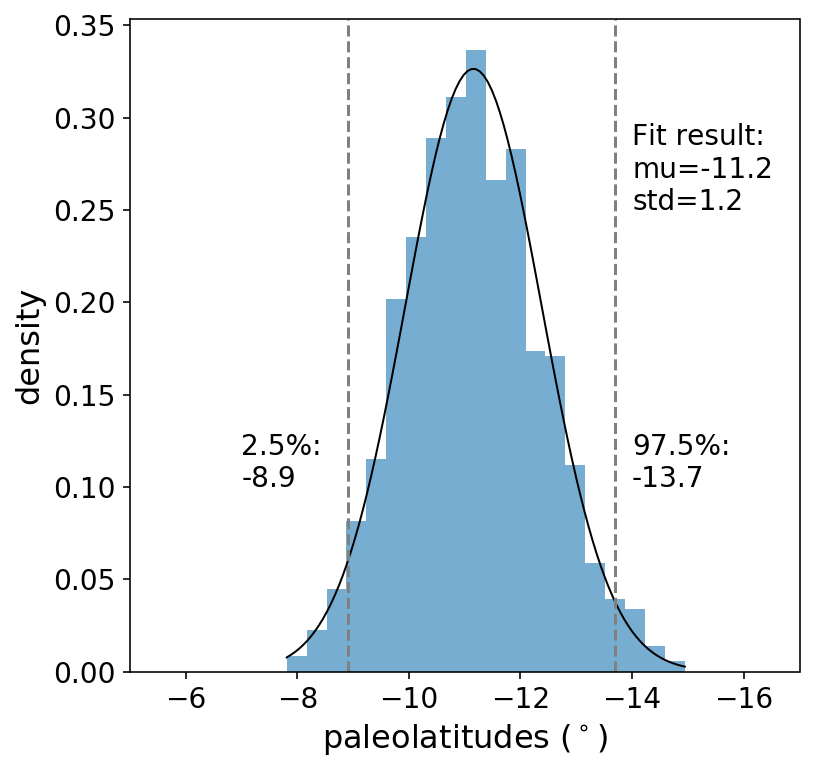

In [131]:
EI_plats = -pmag.plat(EI_incs)
lower, upper = np.round(np.percentile(EI_plats, [2.5, 97.5]), 1)
mu, std = norm.fit(EI_plats)
x = np.linspace(min(EI_plats), max(EI_plats), 100)
p = norm.pdf(x, mu, std)

plt.figure(figsize=(6,6))
plt.hist(EI_plats, bins=20, alpha=0.6, density=1)
plt.plot(x, p, 'k', linewidth=1)

plt.text(-14, 0.25, 'Fit result:\nmu='+str(round(mu,1))+'\nstd='+str(round(std, 1)), fontsize=14)

plt.axvline(x=lower, color = 'gray', ls='--')
plt.axvline(x=upper, color = 'gray', ls='--')

plt.text(-7, 0.10, '2.5%:\n'+str(upper), fontsize=14)
plt.text(-14, 0.10, '97.5%:\n'+str(lower), fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(-5, -17)
plt.xlabel('paleolatitudes ($^\circ$)', fontsize=16)
plt.ylabel('density', fontsize=16)
# plt.savefig('../Figures/Pmag/EI_Plat_histogram.pdf', bbox_inches='tight')

plt.show()

In [132]:
st.kstest(EI_plats, norm(loc=mu, scale=std).cdf)

KstestResult(statistic=0.018052607650995534, pvalue=0.9003440655907834)

<Figure size 576x576 with 0 Axes>

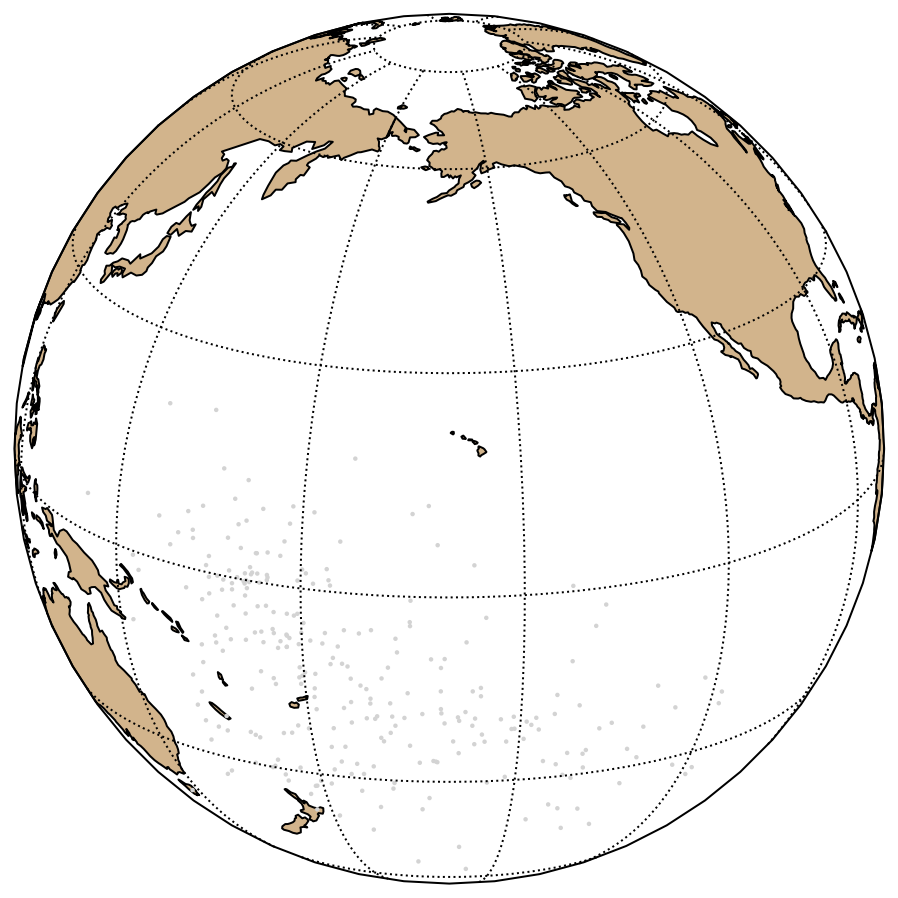

In [133]:
plt.figure(figsize=(8,8))
m = ipmag.make_orthographic_map(200, 20)
plot_vgp(m, Jacobsville_hdt_spec['Plon_cor'], Jacobsville_hdt_spec['Plat_cor'], color='lightgrey', edge='none', markersize=5, alpha=1)

# plt.savefig('../code_output/bootstrap_pole_resample.png', dpi=300, bbox_inches='tight')
plt.show()

In [134]:
specimens_ht_tc_decs = Jacobsville_hdt_spec['DEC'].tolist()
specimens_ht_tc_alpha95s = Jacobsville_hdt_spec['dir_alpha95'].tolist()
slons = Jacobsville_hdt_spec['longitude'].tolist()
slats = Jacobsville_hdt_spec['latitude'].tolist()

mean_lons = []
mean_lats = []

for f in EI_fs:
    unsquish_incs = ipmag.unsquish(Jacobsville_hdt_spec['dir_inc'].tolist(), f)
    unsquish_VGPs = pmag.dia_vgp(np.array([specimens_ht_tc_decs, unsquish_incs, specimens_ht_tc_alpha95s, slats, slons]).T)
    unsquish_lons, unsquish_lats = unsquish_VGPs[0], unsquish_VGPs[1]
    unsquish_VGPs_mean = ipmag.fisher_mean(unsquish_lons, unsquish_lats)
    resampled_lons, resampled_lats = ipmag.fisher_mean_resample(alpha95=unsquish_VGPs_mean['alpha95'], n=100, 
                                                   dec=unsquish_VGPs_mean['dec'], inc=unsquish_VGPs_mean['inc'], di_block=0)
    mean_lons.extend(resampled_lons)
    mean_lats.extend(resampled_lats)

In [135]:
kent_distribution_95 = ipmag.kent_distribution_95(dec=mean_lons,inc=mean_lats) 
kent_distribution_95

{'dec': 186.32613004793535,
 'inc': -14.199196016692765,
 'n': 100000,
 'Zdec': 109.25383075442295,
 'Zinc': 41.48280413757106,
 'Edec': 261.6376932010964,
 'Einc': 45.06093458505846,
 'Zeta': 2.972678691710591,
 'Eta': 3.308247732230898}

In [136]:
Kewee_track_poles = pd.read_csv('../Data/Keweenawan_track/keweenawan_pole_means.csv')
Upper_Freda_pole = Kewee_track_poles[Kewee_track_poles['Polarity'] == 'Freda'].reset_index(drop=1)
Nonesuch_pole = Kewee_track_poles[Kewee_track_poles['Polarity'] == 'Nonesuch'].reset_index(drop=1)

ERROR! Session/line number was not unique in database. History logging moved to new session 2551


<Figure size 576x576 with 0 Axes>

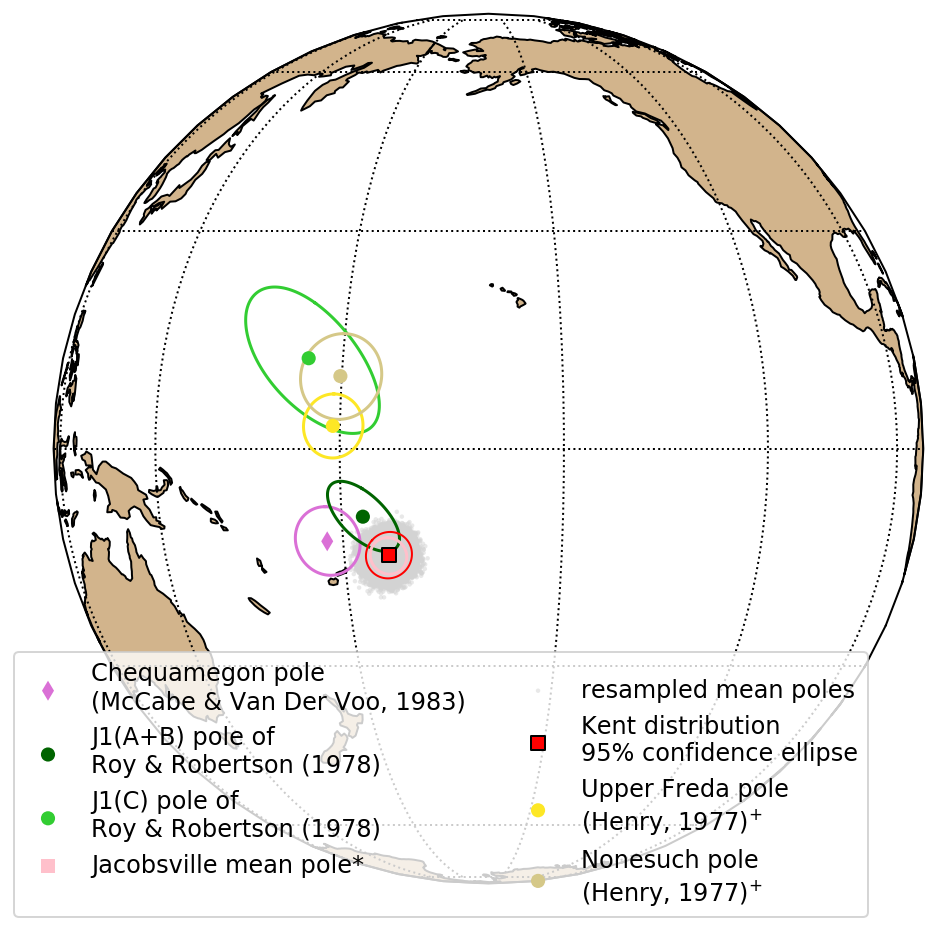

In [153]:
plt.figure(figsize=(8,8))
m = ipmag.make_orthographic_map(200, 0)

ipmag.plot_pole(m, 177.7, -12.3, 4.6, 
                color = 'orchid', marker = 'd', markersize=50, edgecolor='none', label='Chequamegon pole\n(McCabe & Van Der Voo, 1983)')
plot_pole_dp_dm(m, 183, -9, 271.6, 47, 3,6, pole_color='darkgreen', pole_edgecolor='none', markersize=50, pole_label='J1(A+B) pole of\nRoy & Robertson (1978)', legend=0);
plot_pole_dp_dm(m, 175, 12, 271.6, 47, 6,13, pole_color='limegreen', pole_edgecolor='none', markersize=50, pole_label='J1(C) pole of\nRoy & Robertson (1978)', legend=0);

# ipmag.plot_pole(m, Jacobsville_N_pole_cor_mean['dec'], Jacobsville_N_pole_cor_mean['inc'], Jacobsville_N_pole_cor_mean['alpha95'], 
#                 color = 'C0', marker = 's', markersize=50, edgecolor='none', label='Jacobsville N pole*')
# ipmag.plot_pole(m, Jacobsville_R_pole_cor_mean['dec'], Jacobsville_R_pole_cor_mean['inc'], Jacobsville_R_pole_cor_mean['alpha95'], 
#                 color = 'C1', marker = 's', markersize=50, edgecolor='none', label='Jacobsville R pole*')

ipmag.plot_pole(m, Jacobsville_hdt_mean_pole_cor['dec'], Jacobsville_hdt_mean_pole_cor['inc'], Jacobsville_hdt_mean_pole_cor['alpha95'], 
                color = 'pink', markersize=50, edgecolor='none', marker = 's',label='Jacobsville mean pole*')

plot_vgp(m, mean_lons, mean_lats, color='lightgrey', edge='none', markersize=5, alpha=0.5, label='resampled mean poles')

plot_pole_ellipse(m,kent_distribution_95, lower=0, markersize=50, color='r', label='Kent distribution\n95% confidence ellipse')

ipmag.plot_pole(m, Upper_Freda_pole['PLon'][0], Upper_Freda_pole['PLat'][0], Upper_Freda_pole['A95'][0], 
                color = '#fde725', marker = 'o', markersize=50, edgecolor='none', label='Upper Freda pole\n(Henry, 1977)$^{+}$')
ipmag.plot_pole(m, Nonesuch_pole['PLon'][0], Nonesuch_pole['PLat'][0], Nonesuch_pole['A95'][0], 
                color = '#D5C888', marker = 'o', markersize=50, edgecolor='none', label='Nonesuch pole\n(Henry, 1977)$^{+}$')

plt.legend(bbox_to_anchor=(0.95, 0.28), fontsize=12, ncol=2)
plt.savefig('../Figures/Pmag/bootstrap_pole_resample_NR_combined.png', dpi=300, bbox_inches='tight')
plt.show()

## Pole position in context of Keweenawan Track and Grenville Loop


In [138]:
Brown2012a = pd.read_csv('../Data/Pmag_compiled/Brown2012a.csv')
Brown2012a['PLon'] = [Brown2012a['vgp_lon'][i] if Brown2012a['dir_inc'][i]<0 else Brown2012a['vgp_lon'][i]+180 for i in range(Brown2012a.shape[0])]
Brown2012a['PLat'] = [Brown2012a['vgp_lat'][i] if Brown2012a['dir_inc'][i]<0 else -Brown2012a['vgp_lat'][i] for i in range(Brown2012a.shape[0])]

Brown2012a_gneiss = Brown2012a[Brown2012a['location'].str.contains('gneiss')].reset_index(drop=1)
Brown2012a_anorthosite = Brown2012a[Brown2012a['location'].str.contains('anorthosite|associated')].reset_index(drop=1)
Brown2012a_granite = Brown2012a[Brown2012a['location'].str.contains('granites')].reset_index(drop=1)

Brown2012a_gneiss_mean_pole = ipmag.fisher_mean(Brown2012a_gneiss['PLon'], Brown2012a_gneiss['PLat'])
Brown2012a_anorthosite_mean_pole = ipmag.fisher_mean(Brown2012a_anorthosite['PLon'], Brown2012a_anorthosite['PLat'])
Brown2012a_granite_mean_pole = ipmag.fisher_mean(Brown2012a_granite['PLon'], Brown2012a_granite['PLat'])
# Brown2012a

In [139]:
Halls2015_A = pd.read_csv('../Data/Pmag_compiled/Halls2015_A.csv')
# Halls2015_A = Halls2015_A[Halls2015_A['a95']<10]
Halls2015_A = Halls2015_A[Halls2015_A['site'] != 'TG*']
Halls2015_A = ipmag.vgp_calc(Halls2015_A, tilt_correction='no',
    site_lon='longitude',
    site_lat='latitude',
    dec_is='Dec',
    inc_is='Inc',)
Halls2015_A_mean_pole = ipmag.fisher_mean(Halls2015_A['vgp_lon_rev'].tolist(), Halls2015_A['vgp_lat_rev'].tolist())

Haliburton_pole = Halls2015_A[Halls2015_A['unit'].str.contains('Haliburton')].reset_index(drop=1)
Wilberforce_pole = Halls2015_A[Halls2015_A['unit'].str.contains('Wilberforce')].reset_index(drop=1)

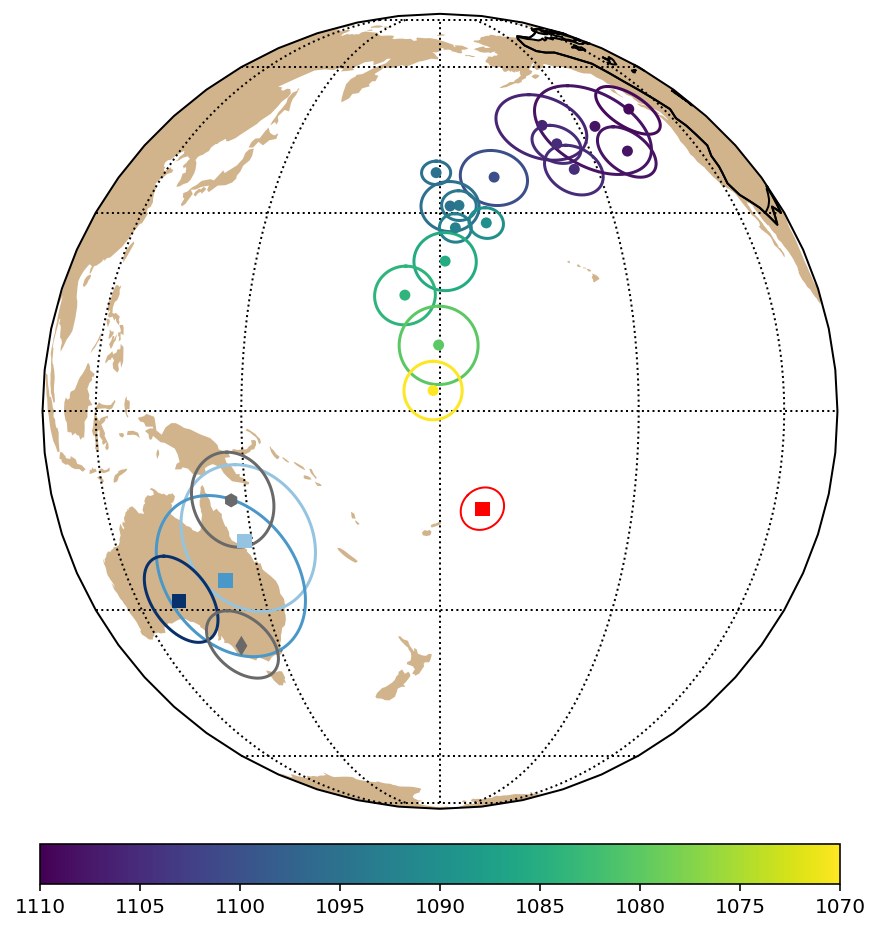

In [140]:
m = ipmag.make_orthographic_map(central_latitude=0,central_longitude=180, land_edge_color='none', grid_lines=True,
    lat_grid=[-80.0, -60.0, -30.0, 0.0, 30.0, 60.0, 80.0],
    lon_grid=[-180.0, -150.0, -120.0, -90.0, -60.0, -30.0, 0.0, 30.0, 60.0, 90.0, 120.0, 150.0, 180.0])
m.add_feature(Laurentia_outline)
plt.figure(num=1,figsize=(10, 10))

# viridis = cm = plt.get_cmap('viridis') 
vmin=1070
vmax=1110
cNorm = colors.Normalize(vmin, vmax)
Keween_scalarMap = matplotlib.cm.ScalarMappable(norm=cNorm, cmap='viridis_r')
Grenville_scalarMap = matplotlib.cm.ScalarMappable(norm=colors.Normalize(940, 990), cmap='Blues')

for n in range(Kewee_track_poles.shape[0]):
    rgba = Keween_scalarMap.to_rgba(Kewee_track_poles['AgeNominal'][n])
    hex_color = colors.rgb2hex(rgba)
#     print(hex_color)
    ipmag.plot_pole(m,Kewee_track_poles['PLon'][n],Kewee_track_poles['PLat'][n],Kewee_track_poles['A95'][n],
                    color=hex_color, markersize=30, edgecolor='none')

ipmag.plot_pole(m, Brown2012a_gneiss_mean_pole['dec'], Brown2012a_gneiss_mean_pole['inc'], Brown2012a_gneiss_mean_pole['alpha95'], 
                color = colors.rgb2hex(Grenville_scalarMap.to_rgba(960)), edgecolor='none', marker = 's', markersize=50,  label='Adirondack gneiss')
ipmag.plot_pole(m, Brown2012a_anorthosite_mean_pole['dec'], Brown2012a_anorthosite_mean_pole['inc'], Brown2012a_anorthosite_mean_pole['alpha95'], 
                color = colors.rgb2hex(Grenville_scalarMap.to_rgba(970)), edgecolor='none', marker = 's', markersize=50, label='Adirondack anorthositic rocks')
ipmag.plot_pole(m, Brown2012a_granite_mean_pole['dec'], Brown2012a_granite_mean_pole['inc'], Brown2012a_granite_mean_pole['alpha95'], 
                color = colors.rgb2hex(Grenville_scalarMap.to_rgba(990)), edgecolor='none', marker = 's', markersize=50, label='Adirondack granites')

# ipmag.plot_vgp(m, Jacobsville_N_spec['vgp_lon'].tolist(), Jacobsville_N_spec['vgp_lat'].tolist(), 
#                edge='none', color = 'C0', label = 'hdt N tc VGPs')
# ipmag.plot_vgp(m, Jacobsville_R_spec['vgp_lon_rev'].tolist(), Jacobsville_R_spec['vgp_lat_rev'].tolist(), 
#                 edge='none', color = 'C1', label = 'hdt R tc VGPs')
# ipmag.plot_vgp(m, Jacobsville_hct_spec['vgp_lon_rev'].tolist(), Jacobsville_hct_spec['vgp_lat_rev'].tolist(), 
#                 edge='none', color = 'C2', label = 'hct tc VGPs')

# ipmag.plot_pole(m, Jacobsville_N_pole_mean['dec'], Jacobsville_N_pole_mean['inc'], Jacobsville_N_pole_mean['alpha95'], 
#                 color = 'purple', marker = 's', label='mean pole for Jacobsville hdt N pole')
# ipmag.plot_pole(m, Jacobsville_R_pole_mean['dec'], Jacobsville_R_pole_mean['inc'], Jacobsville_R_pole_mean['alpha95'], 
#                 color = 'orchid', marker = 's', label='mean pole for Jacobsville hdt R pole')
# ipmag.plot_pole(m, Jacobsville_hct_pole_mean['dec'], Jacobsville_hct_pole_mean['inc'], Jacobsville_hct_pole_mean['alpha95'], 
#                 color = 'green', marker = 's', label='mean pole for Jacobsville hct pole')


# ipmag.plot_pole(m, McCabe1983a_pole_mean['dec'], McCabe1983a_pole_mean['inc'], McCabe1983a_pole_mean['alpha95'], 
#                 color = 'orange', edgecolor='none', markersize=50, marker = 's', label='Chequamegan Formation\n(McCabe and Van Der Voo, 1983)')
ipmag.plot_pole(m, Haliburton_pole['vgp_lon'][0], Haliburton_pole['vgp_lat'][0], Haliburton_pole['a95'][0], 
                color = 'dimgray', edgecolor='none', markersize=50, marker = 'd', label = 'Haliburton intrusions\n(Buchan & Dunlop, 1976)')
ipmag.plot_pole(m, Wilberforce_pole['vgp_lon'][0], Wilberforce_pole['vgp_lat'][0], Wilberforce_pole['a95'][0], 
                color = 'dimgray', edgecolor='none', markersize=50, marker = 'h', label = 'Wilberforce intrusions\n(Palmer & Carmichael, 1973)')

cbar=plt.colorbar(Keween_scalarMap,orientation='horizontal',fraction=0.046, pad=0.04)
cbar.ax.invert_xaxis()
plot_pole_ellipse(m,kent_distribution_95, lower=0, edgecolor='none', markersize=50, color='r', label='Jacobsville mean pole\n(inclination corrected)')

# plt.legend(bbox_to_anchor=(1 ,0.6), ncol=1, fontsize=12)
# plt.savefig('../Figures/Pmag/Jacobsville_pole_plot.pdf', bbox_inches='tight')
plt.show()

In [141]:
degree2distance = 110.567

In [142]:
pmag.angle([Jacobsville_hdt_mean_pole_cor['dec'], Jacobsville_hdt_mean_pole_cor['inc']], [Haliburton_pole['vgp_lon'][0], Haliburton_pole['vgp_lat'][0]])

array([45.268570078116845])

In [143]:
Jacobsville_Haliburton_arc = np.round(pmag.angle([Jacobsville_hdt_mean_pole_cor['dec'], Jacobsville_hdt_mean_pole_cor['inc']], 
                                                 [Haliburton_pole['vgp_lon'][0], Haliburton_pole['vgp_lat'][0]])*degree2distance, 1)
Jacobsville_Haliburton_arc

array([5005.2])

In [144]:
pmag.angle([Jacobsville_hdt_mean_pole_cor['dec'], Jacobsville_hdt_mean_pole_cor['inc']], [Wilberforce_pole['vgp_lon'][0], Wilberforce_pole['vgp_lat'][0]])

array([37.77647031453509])

In [145]:
Jacobsville_Wilberforce_arc = np.round(pmag.angle([Jacobsville_hdt_mean_pole_cor['dec'], Jacobsville_hdt_mean_pole_cor['inc']], 
                                                  [Wilberforce_pole['vgp_lon'][0], Wilberforce_pole['vgp_lat'][0]])*degree2distance, 1)
Jacobsville_Wilberforce_arc

array([4176.8])

## average motion between Jacobsville and Freda

In [146]:
Jac_Freda_arc_dis = np.round(pmag.angle([Upper_Freda_pole['PLon'][0], Upper_Freda_pole['PLat'][0]], [Jacobsville_hdt_mean_pole_cor['dec'], Jacobsville_hdt_mean_pole_cor['inc']]),1)
Jac_Freda_arc_dis

array([18.7])

In [147]:
Jac_Freda_arc_dis/(1070-992)

array([0.23974358974359])

In [148]:
np.round(pmag.angle([Upper_Freda_pole['PLon'][0], Upper_Freda_pole['PLat'][0]], [Haliburton_pole['vgp_lon'][0], Haliburton_pole['vgp_lat'][0]]),1)

array([52.3])

In [149]:
np.round(pmag.angle([Upper_Freda_pole['PLon'][0], Upper_Freda_pole['PLat'][0]], [Wilberforce_pole['vgp_lon'][0], Wilberforce_pole['vgp_lat'][0]]),1)

array([35.2])